# Table of contents
1. [Requirements](#Requirements)
2. [Setup](#Setup)
   1. [Patterns](#Patterns)
   2. [Directory Structure](#Directory_Structure)
   3. [Component Details](#Component_Details)
   4. [PDF Gen](#PDF_Gen)
4. [Testbenching](#Testbenching)
   1. [Rules](#Rules)
   2. [Gen Testbench](#Generate_Testbench)
   3. [Run Testbench](#Run_Testbench)
5. [Resource Usage Analysis](#Resource_Usage_Analysis)
6. [Vivado Script](#Vivado_Script)
7. [Timing Analysis](#Timing_Analysis)
8. [Power Analysis](#Power_Analysis)
9. [Waveform Analysis](#Waveform_Analysis)
10. [Full Benchmark Walkthrough](#Full_Benchmark)
11. [Centralized Benchmarking](#Centralized)

# Requirements

In [1]:
#!pip install pyvips fusesoc jinja2 ply pyverilog numpy pandas matplotlib deap cocotb simpy vunit-hdl networkx pyreadline3 ipython-genutils
#!pip install git+https://github.com/ics-jku/wal.git --user
#!pip install pyreadline3
#!pip install --upgrade ipykernel notebook

In [2]:
import os, json, random, shutil, re, subprocess, time, itertools, functools, statistics, inspect, heapq, math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from pprint import pprint

In [3]:
# Vivado doesn't work in jupyter
# Relevant commands provided below to setup and run the scripts in batch mode: vivado -mode batch

# Verify Vivado in PATH
vivado_path = shutil.which('vivado')
if vivado_path:
    vivado_path = vivado_path[:-3] + "bat"
    print(f"Vivado found at: {vivado_path}")
else:
    print("Vivado not found in PATH.")

Vivado found at: C:\Xilinx\Vivado\2024.1\bin\vivado.bat


Python setup instructions

Open cmd

Yosys: 
cd oss-cad-suite/bin

environment.bat

cd ../..

Py Env setup:
Documents\sim\Scripts\activate 

cd OneDrive - NVIDIA Corporation\Documents 

jupyter notebook

In [341]:
# For fun
from IPython import get_ipython
import nbformat

notebook_path = os.path.join(os.getcwd(), 'benchmarking.ipynb')#get_ipython().get_parent().get('metadata', {}).get('path', None)
if notebook_path is None:
    raise ValueError("Couldn't determine notebook path.")

with open(notebook_path, 'r') as f:
    notebook = nbformat.read(f, as_version=4)
    
# Count lines in code cells
count = 0
for cell in notebook.cells:
    if cell.cell_type == 'code':
        count += len(cell.source.split('\n'))

print(f"Total lines in code cells: {count}")

src_dir = os.path.join(os.getcwd(), 'src')
verilog_line_count = 0

# Walk through the src_dir and count the lines in Verilog files
for root, dirs, files in os.walk(src_dir):
    for file in files:
        if file.endswith('.v') or file.endswith('.sv'):  # Check for Verilog files
            file_path = os.path.join(root, file)
            with open(file_path, 'r') as verilog_file:
                lines = verilog_file.readlines()
                verilog_line_count += len(lines)

print(f"Total lines in Verilog files: {verilog_line_count}")

# Add the Verilog lines count to the notebook lines count
total_lines = count + verilog_line_count

print(f"Total lines in code cells and Verilog files: {total_lines}")

Total lines in code cells: 5483
Total lines in Verilog files: 2189
Total lines in code cells and Verilog files: 7672


# Setup

## Patterns

In [314]:
class Pattern:
    def __init__(self, pattern, *args):
        self.pattern = pattern

    def matches(self, filename):
        raise NotImplementedError("This method should be implemented by subclasses")

    def __str__(self):
        #print(inspect.getsourcelines(self.matches))
        return ''.join(inspect.getsourcelines(self.matches)[0])

class SubstringPattern(Pattern):
    def matches(self, filename):
        return self.pattern in filename

    def exact_match(self, filename):
        return self.pattern == filename

class Substring_CountPattern(Pattern):
    def __init__(self, pattern, count_vars={}):
        self.pattern = pattern
        self.count_vars = count_vars
        
    def matches(self, filename):
        found = False
        if self.pattern in filename:
            found = True

        for var, count_range in self.count_vars.items():
            
            if filename.count(var) <= count_range[0] or filename.count(var) >= count_range[1]:
                found = False
                
        return found

class StringMatchPattern(Pattern):
    
    def matches(self, filename):
        #print(self.pattern, filename)
        return self.pattern == filename

class RegexPattern(Pattern):
    def matches(self, filename):
        return re.search(self.pattern, filename) is not None

lines = str(SubstringPattern(''))
print(lines)

    def matches(self, filename):
        return self.pattern in filename



## Directory_Structure

In [292]:
# Submodule identified when the module instantiation is followed by // Module

def identify_submodules(verilog_file):
    submodule_names = []
    with open(verilog_file, 'r') as f:
        lines = f.readlines()

    for i, line in enumerate(lines):
        if "// Module" in line:
            # Find the submodule name by scanning backward to the line with the instantiation
            for j in range(i, 0, -1):
                #if 'carry_skip_adder' in verilog_file:
                    #print(lines[j], ('(' in lines[j]), (not ')' in lines[j]), submodule_names)
                    #time.sleep(1)
                    
                if (('(' in lines[j]) and ((not ')' in lines[j]) or ((lines[j].count('(') > 1) and ('#' in lines[j])))) or ('(' in lines[j] and ')' in lines[j] and ';' in lines[j]):
                    
                    submodule_name = lines[j].strip().split()[0]
                    submodule_names.append(submodule_name)
                    break

    return submodule_names

def filter_filenames(source_dir, patterns=None, filenames=None, subs=False):
    if filenames is None:
        all_files = os.listdir(source_dir)
    else:
        all_files = filenames

    if patterns:
        filtered_files = []
        for file in all_files:
            for pattern in patterns:
                if pattern.matches(file):
                    filtered_files.append(file)
                    break
    else:
        filtered_files = all_files

    #print("Filtered files before subs:", filtered_files)

    if subs:
        final_files = []
        for file in filtered_files:
            final_files.append(file)
            submodules = identify_submodules(os.path.join(source_dir, file))
            #print("Submodules found:", submodules)
            final_files.extend(submodules)
    else:
        final_files = filtered_files

    final_files = [os.path.join(src_folder, f) for f in final_files if not 'for' in f and f in all_files]
    final_files = [f + '.v' if not '.v' in f else f for f in final_files]

    return list(set(final_files))

def create_directory_structure(component_names, src_folder, dest_folder, hierarchy):
    for verilog_file in component_names:
        print("Creating directory structure for:", verilog_file)
        module_name = os.path.splitext(os.path.basename(verilog_file))[0]
        component_dir = os.path.join(dest_folder, module_name)
        os.makedirs(component_dir, exist_ok=True)
        shutil.copy(verilog_file, component_dir)
    
        submodules = list(np.unique(identify_submodules(verilog_file)))
        #print("Submodules found: ", submodules)
        hierarchy[module_name] = submodules
    
        for submodule in submodules:
            submodule_file = os.path.join(src_folder, f"{submodule}.v")
            if os.path.exists(submodule_file):
                create_directory_structure([submodule_file], src_folder, component_dir, hierarchy)

        #print_directory_structure(dest_folder)
        #print()

    return hierarchy

def print_directory_structure(path, indent=0):
    hierarchy = {}
    
    def build_hierarchy(path, hierarchy):
        for root, dirs, files in os.walk(path):
            level = root.replace(path, '').count(os.sep)
            indent = ' ' * 4 * level
            print(f"{indent}{os.path.basename(root)}/")
            subindent = ' ' * 4 * (level + 1)
            for f in files:
                print(f"{subindent}{f}")
            current_level = hierarchy
            parts = root.replace(path, '').split(os.sep)
            for part in parts:
                if part:
                    current_level = current_level.setdefault(part, {})
            for d in dirs:
                current_level[d] = {}
            for f in files:
                current_level[f] = None

    build_hierarchy(path, hierarchy)
    return hierarchy

In [420]:
if "simulation" in os.getcwd():
    os.chdir("..")

print(os.getcwd())

src_folder = "src"
dest_folder = "main_generated"
component_names = filter_filenames(src_folder, patterns=[SubstringPattern("alu")], filenames=None, subs=True)
component_names

C:\Users\ugheewala\OneDrive - NVIDIA Corporation\Documents\Projects\benchmarking


['src\\alu.v']

In [421]:
if "simulation" in os.getcwd():
    os.chdir("..")

print(os.getcwd())

hierarchy = {}
hierarchy = create_directory_structure(component_names, src_folder, dest_folder, hierarchy)
#print(hierarchy)
hierarchy = print_directory_structure(dest_folder)
#print(hierarchy)

with open('hierarchy.json', 'w') as f:
    json.dump(hierarchy, f, indent=4)

C:\Users\ugheewala\OneDrive - NVIDIA Corporation\Documents\Projects\benchmarking
Creating directory structure for: src\alu.v
main_generated/
    benchmarking_report.pdf
    preview_initial_benchmarking_report.pdf
    preview_temp_summary.pdf_benchmarking_report.pdf
    preview_temp_summary.pdf_ripple_carry_adder_resusage_report.pdf
    ripple_carry_adder_resusage_report.pdf
    adder_subtractor/
        adder_subtractor.v
        adder_subtractor_compilation_output.txt
        adder_subtractor_details.json
        adder_subtractor_details_N1.json
        adder_subtractor_details_N2.json
        adder_subtractor_details_N3.json
        adder_subtractor_details_N4.json
        adder_subtractor_details_N5.json
        adder_subtractor_details_N6.json
        adder_subtractor_details_N7.json
        adder_subtractor_details_N8.json
        adder_subtractor_N1_simulation_output.txt
        adder_subtractor_N2_simulation_output.txt
        adder_subtractor_N3_simulation_output.txt
        ad

## Verilog_Module_Template

In [422]:
"""
input a,  // Implicit wire
input wire b,  // Explicit wire
input reg cin,  // Explicit reg
output sum,  // Implicit wire
output wire cout  // Explicit wire
"""

"""
// Module Definition
module <module_name> #(parameter <param_name> = <default_value>) (
     // Input signals
    input wire signed [<bit_width_start, bit_width_end>] <signal_name>, // <comment>
    input wire unsigned [<bit_width_start, bit_width_end>] <signal_name>, // <comment>
    input reg  signed [<bit_width_start, bit_width_end>] <signal_name>, // <comment>
    input reg  unsigned [<bit_width_start, bit_width_end>] <signal_name>, // <comment>
    
    // Output signals
    output wire signed [<bit_width_start, bit_width_end>] <signal_name>, // <comment>
    output wire unsigned [<bit_width_start, bit_width_end>] <signal_name>, // <comment>
    output reg  signed [<bit_width_start, bit_width_end>] <signal_name>, // <comment>
    output reg  unsigned [<bit_width_start, bit_width_end>] <signal_name>, // <comment>
    
    // Internal signals (internal wires or registers)
    wire signed [<bit_width_start, bit_width_end>] <signal_name>, // <comment>
    wire unsigned [<bit_width_start, bit_width_end>] <signal_name>, // <comment>
    reg  signed [<bit_width_start, bit_width_end>] <signal_name>, // <comment>
    reg  unsigned [<bit_width_start, bit_width_end>] <signal_name>, // <comment>
);

endmodule
"""

# Your comments, parameter names and signal names can't contain any keywords

'\n// Module Definition\nmodule <module_name> #(parameter <param_name> = <default_value>) (\n     // Input signals\n    input wire signed [<bit_width_start, bit_width_end>] <signal_name>, // <comment>\n    input wire unsigned [<bit_width_start, bit_width_end>] <signal_name>, // <comment>\n    input reg  signed [<bit_width_start, bit_width_end>] <signal_name>, // <comment>\n    input reg  unsigned [<bit_width_start, bit_width_end>] <signal_name>, // <comment>\n    \n    // Output signals\n    output wire signed [<bit_width_start, bit_width_end>] <signal_name>, // <comment>\n    output wire unsigned [<bit_width_start, bit_width_end>] <signal_name>, // <comment>\n    output reg  signed [<bit_width_start, bit_width_end>] <signal_name>, // <comment>\n    output reg  unsigned [<bit_width_start, bit_width_end>] <signal_name>, // <comment>\n    \n    // Internal signals (internal wires or registers)\n    wire signed [<bit_width_start, bit_width_end>] <signal_name>, // <comment>\n    wire unsig

## Component_Details

In [423]:
def preprocess_lines(lines):
    preprocessed_lines = []
    for line in lines:
        line = line.strip()
        if 'input' in line or 'output' in line:
            # Ensure proper separation of signal name
            parts = line.split()
            preprocessed_line = ' '.join(parts)
            preprocessed_lines.append(preprocessed_line)
        else:
            preprocessed_lines.append(line)
    return preprocessed_lines

def log_format_error(line, component_name):
    print(f"Format error in {component_name}: {line}")

def find_component_directory(component_name, hierarchy='hierarchy.json', base_dir="generated"):
    for root, dirs, files in os.walk(base_dir):
        if component_name in dirs:#f"{component_name}.v" in files:
            d = dirs[dirs.index(component_name)]
            return os.path.join(base_dir, d)
    return None

In [424]:
def detect_component_details(component_name, subs=False, hierarchy_file='hierarchy.json', base_dir='main_generated', 
                             clk_name='clk', rst_name='rst', src_dir='src', link_patterns=[], patterns=[], module_patterns=module_patterns):
    with open(hierarchy_file, 'r') as f:
        hierarchy = json.load(f)
    
    def find_verilog_file(module, path="generated"):
        for root, dirs, files in os.walk(path):
            for file in files:
                if file == f"{module}.v":
                    return os.path.join(root, file)
        return None

    def extract_details(verilog_file, comp_name, clk_name, rst_name):
        with open(verilog_file, 'r') as f:
            content = f.read()

        component_details = {
            "component_name": comp_name,
            "parameters": [],
            "inputs": [],
            "outputs": [],
            "internals": {},
            "mode": "combinational",
            "module_variations": {}
        }

        # Extract parameters
        parameter_pattern = re.compile(r'parameter\s+(\w+)\s*=\s*([\w\']+)')
        parameters = list(set(parameter_pattern.findall(content)))
        parameters.sort(key=lambda x: (x[0] != 'N', x[0]))
        component_details["parameters"] = []
        for param in parameters:
            component_details["parameters"].append({"name": param[0], "value": param[1]})

        param_names = [param[0] for param in parameters]

        lines = content.splitlines()
        #lines = preprocess_lines(lines)

        clk_detected = False
        rst_detected = False
        
        for line in lines:
            if 'input' in line or 'output' in line:
                parts = line.split(' ')

                if '//' in parts:
                    parts = parts[:parts.index('//')]

                parts = [p for p in parts if p != '']

                #print(parts, len(parts))
                #time.sleep(1)
                
                signal_type = parts[0]
                data_type = 'wire'  # Default data type
                sign_type = 'unsigned'  # Default sign type
                bit_width = '1'  # Default bit width
                signal_name = parts[-1].replace(',', '').replace(';', '')  # Remove trailing commas or semicolons
    
                if 'signed' in parts:
                    sign_type = 'signed'
                if 'reg' in parts and not 'output' in line:
                    data_type = 'reg'
    
                # Handle bit width if specified
                if len(parts) == 4:
                    for part in parts:
                        if '[' in part and ']' in part:
                            bit_width = part.strip('[]')
                            break
                elif len(parts) > 4:
                    part = ''.join(parts[3:len(parts)-1])
                    #print(part)
                    if '[' in part and ']' in part:
                        bit_width = part.strip('[]')
                elif len(parts) == 3:
                    part = parts[1]
                    #print(part)
                    if '[' in part and ']' in part:
                        bit_width = part.strip('[]')
                    
                signal_info = (signal_type, data_type, sign_type, bit_width, signal_name)
                #print(signal_info)
                #time.sleep(1)

                if signal_type == 'input':
                    component_details["inputs"].append(signal_info)
                    
                    # Check if clk or rst are present
                    if signal_name == clk_name:
                        clk_detected = True
                    elif signal_name == rst_name:
                        rst_detected = True
                        
                elif signal_type == 'output':
                    component_details["outputs"].append(signal_info)

            elif 'wire' in line:
                wire_pattern = re.findall(r'wire\s*(\[.*\])?\s*([\w_, ]+);', line)
                if wire_pattern:
                    width, wire_names = wire_pattern[0]
                    wire_list = [w.strip() for w in wire_names.split(',')]

                    #print(wire_list, width)

                    for wire in wire_list:
                        component_details["internals"][wire] = width if width else '1'

                        # Check if wire matches any of the provided patterns
                        for pattern in patterns:
                            if pattern.matches(wire):
                                # Link part of the wire name to module types using link_patterns
                                for link_pattern, module_type in zip(link_patterns, ['adder', 'subtractor', 'multiplier', 'divider', 'shifter']):
                                    if link_pattern.matches(module_type) and pattern.matches(wire):
                                        component_details["module_variations"].setdefault(module_type, []).append(wire)
                

        # If clk or rst is detected, set the mode to sequential
        if clk_detected or rst_detected:
            component_details["mode"] = "sequential"

        return component_details
    
    verilog_file = find_verilog_file(component_name)
    if not verilog_file:
        raise FileNotFoundError(f"Component {component_name} not found in the hierarchy.")

    comp_dir = find_component_directory(component_name, hierarchy_file, base_dir)
    #print("Comp Dir for", component_name, ":", comp_dir)
    details_filename = os.path.join(comp_dir, f'{component_name}_details.json')

    component_details = extract_details(verilog_file, component_name, clk_name, rst_name)

    #pprint(component_details["module_variations"])

    for module_type in component_details["module_variations"]:
        if module_patterns:
            component_details["module_variations"][module_type] = [os.path.basename(f)[:-2] for f in filter_filenames(src_folder, patterns=[module_patterns[module_type]], filenames=None, subs=False)]

        else:
            component_details["module_variations"][module_type] = [os.path.basename(f)[:-2] for f in filter_filenames(src_folder, patterns=[SubstringPattern(module_type)], filenames=None, subs=False)]

    total_configurations = math.prod([len(variations) for variations in component_details['module_variations'].values()])
    component_details['total_configurations'] = total_configurations
    
    print(f"Total possible configurations for {component_details['component_name']}: {total_configurations}")
    
    if subs and component_name in hierarchy:
        component_details['submodules'] = {}
        for submodule, submodule_hierarchy in hierarchy[component_name].items():
            if isinstance(submodule_hierarchy, dict):
                submodule_details = detect_component_details(submodule, subs, hierarchy_file, comp_dir, clk_name, rst_name)
                component_details['submodules'][submodule] = submodule_details

    with open(details_filename, "w") as f:
        f.write(json.dumps(component_details, indent=4))

    print("Details for", component_name, "saved to", details_filename)

    return component_details

component_name = "alu"
print("Getting component details for", component_name)

patt = SubstringPattern('out')
patterns = [patt]

count_vars = {
    '_': [1, 3]
}

link_patterns = [SubstringPattern('adder'), SubstringPattern('subtractor'),
                 SubstringPattern('multiplier'), SubstringPattern('divider'), SubstringPattern('shifter')]

module_patterns = {
    'adder': Substring_CountPattern('adder', count_vars),
    'subtractor': Substring_CountPattern('subtractor', count_vars),
    'multiplier': SubstringPattern('multiplier'),
    'divider': SubstringPattern('divider'),
    'shifter': SubstringPattern('shifter')
}

component_details = detect_component_details(component_name, True, link_patterns=link_patterns, module_patterns=module_patterns, patterns=patterns)
pprint(component_details)

Getting component details for alu


FileNotFoundError: Component alu not found in the hierarchy.

In [425]:
def get_components_details(component_names, subs):
    gen_details = {}
    
    for i in range(len(component_names)):
        component_name = component_names[i]
        print("Getting component details for", component_name)
        
        component_details = detect_component_details(component_name, subs[i])
        gen_details.update(component_details)
        
        #print(json.dumps(component_details, indent=4))
        print()

    return gen_details

In [426]:
if "simulation" in os.getcwd():
    os.chdir("..")

print(os.getcwd())

component_names = [os.path.basename(f)[:-2] for f in filter_filenames(src_folder, patterns=[SubstringPattern("alu")], filenames=None, subs=True)]
print(component_names)

subs = [True for c in component_names]

components_details = get_components_details(component_names, subs)
pprint(components_details)

C:\Users\ugheewala\OneDrive - NVIDIA Corporation\Documents\Projects\benchmarking
['alu']
Getting component details for alu


FileNotFoundError: Component alu not found in the hierarchy.

## Configurations

In [328]:
def parse_module_ports_and_headers(module_name, src_dir='src'):
    file_path = os.path.join(src_dir, module_name + '.v')
    
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"Module {module_name} not found at {file_path}")

    with open(file_path, 'r') as file:
        content = file.readlines()
    
    in_module = False
    port_list_started = False
    module_ports = {}
    module_name_extracted = None

    for line in content:
        line = line.strip()
        #print(line)
        
        # Check if we have entered the module definition
        if 'module' in line and not in_module:
            in_module = True
            parts = line.split()
            module_name_extracted = parts[1].split('(')[0]  # Extract the module name
            continue
        
        # Skip parameter definitions
        if "#(" in line:
            continue

        # If we're in the module header, we start parsing the ports
        if in_module:
            if "(" in line and not port_list_started:
                port_list_started = True  # Start of the port list
                line = line.split("(")[1]  # Remove the starting '(' for the port list

            # If we reach the end of the port list, stop processing
            if ");" in line:
                line = line.split(");")[0]  # Remove the trailing ');'
                port_list_started = False

            # Process each port in the list
            ports = line.split(',')
            for port in ports:
                port = port.strip()

                # Extract port type (input/output), signed/unsigned, width, and signal name
                parts = port.split()
                signal_type = parts[0]  # input/output
                signed = 'unsigned'
                width = '1'
                signal_name = parts[-1].replace(',', '').replace(';', '')  # Signal name

                if 'signed' in parts:
                    signed = 'signed'

                # Handle bit width, if specified
                for part in parts:
                    if '[' in part and ']' in part:
                        width = part.strip('[]')

                # Store the port details
                module_ports[signal_name] = {
                    'type': signal_type,
                    'signed': signed,
                    'width': width
                }

            # If we reached the end of the port list, exit
            if not port_list_started:
                break

    return module_name_extracted, module_ports

def test_module_parsers(component_details, src_dir='src'):
    module_variations = component_details.get('module_variations', {})
    
    for module_type, modules in module_variations.items():
        print(f"Testing {module_type} modules:")
        
        for module in modules:
            try:
                module_name, port_details = parse_module_ports_and_headers(module, src_dir)
                print(f"\nModule: {module_name}")
                print(f"Ports: {port_details}")
            except Exception as e:
                raise(e)
                print(f"Error parsing module {module}: {e}")
        print("\n" + "-"*50 + "\n")

# Now, test for all the modules in the component_details
test_module_parsers(component_details)

Testing adder modules:


IndexError: list index out of range

In [ ]:
def generate_alu_configuration(component_details, selected_config, output_dir='generated_alus'):
    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)
    
    alu_name = f"alu_config_{selected_config}"
    verilog_file = os.path.join(output_dir, f"{alu_name}.v")
    
    # Write the new ALU Verilog file based on the selected configuration
    with open(verilog_file, 'w') as file:
        file.write(f"// ALU Configuration: {selected_config}\n")
        file.write(f"module {alu_name} #(parameter WIDTH = 32) (\n")
        file.write("    input [WIDTH-1:0] A, B,\n")
        file.write("    input [3:0] opcode,\n")
        file.write("    input [2:0] sel,\n")
        file.write("    output reg [WIDTH-1:0] result,\n")
        file.write("    output reg zero, carry, overflow, sign\n")
        file.write(");\n\n")
        
        # Instantiate selected modules
        for module_type, selected_module in selected_config.items():
            module_name, port_details = parse_module_ports_and_headers(selected_module)
            
            # Instantiate the module
            file.write(f"    // Instantiate {module_name}\n")
            file.write(f"    {module_name} {module_type}_inst (\n")
            
            # Write the connections for each port
            for port, details in port_details.items():
                if port.startswith('A') or port.startswith('B'):
                    file.write(f"        .{port}(A),\n")  # Simplified for demo purposes
                else:
                    file.write(f"        .{port}(),\n")  # Placeholder for other ports
            file.write("    );\n\n")
        
        # Final logic for ALU (simplified)
        file.write("    always @(*) begin\n")
        file.write("        case (opcode)\n")
        file.write("            4'b0000: result = adder_out;\n")
        file.write("            4'b0001: result = subtractor_out;\n")
        file.write("            4'b0010: result = A & B;\n")
        file.write("            // More cases...\n")
        file.write("        endcase\n")
        file.write("    end\n\n")
        
        file.write("endmodule\n")
    
    print(f"Generated ALU Verilog file at: {verilog_file}")

    return verilog_file

## Page_Templates

In [14]:
class PageTemplate:
    def __init__(self, pdf_report):
        self.pdf_report = pdf_report
        self.doc = pdf_report.doc
        self.styles = pdf_report.styles
        self.page_size = self.doc.pagesize
        self.current_page_height = pdf_report.current_page_height
        self.elements = []
        self.entry_counter = {}
        self.toc = []

    def add_heading(self, text, level=1):
        style = self.styles[f'Heading{level}']
        self.add_element(Paragraph(text, style))
        self.add_element(Spacer(1, 0.2 * inch))

        # Create a unique identifier for each TOC entry
        entry_id = f"{text}_{self.entry_counter.get(text, 0)}"
        self.toc.append((text, level, None, entry_id, len(self.elements)))
        self.entry_counter[text] = self.entry_counter.get(text, 0) + 1

    def add_element(self, element):
        #print("In Page Template's add_element")#, str(element))
        frame = Frame(self.doc.leftMargin, self.doc.bottomMargin, self.doc.width, self.current_page_height)
        element_height = element.wrap(frame._width, frame._height)[1]

        #print(f"Current page height: {self.current_page_height}, Element height: {element_height}")

        if self.current_page_height - element_height < 0 and not 'PageBreak' in str(element):
            self.elements.append(PageBreak())
            self.current_page_height = self.doc.height - self.doc.topMargin - self.doc.bottomMargin
            #print(f"Adding PageBreak. New page height after element: {self.current_page_height - element_height}")
            element_height = element.wrap(frame._width, self.current_page_height)[1]

        elif 'PageBreak' in str(element):
            #print(self.doc, self.page_size, self.doc.pagesize, frame._width, frame._height, self.doc.height)
            self.current_page_height = self.doc.height - self.doc.topMargin - self.doc.bottomMargin
            self.current_page_height += element_height
            
        self.elements.append(element)
        self.current_page_height -= element_height
        #print(f"Element added. Remaining page height: {self.current_page_height}\n")

    def generate_page(self, data):
        raise NotImplementedError("Subclasses should implement this method to generate the page.")

In [15]:
from reportlab.platypus import Preformatted

class RuleTemplate(PageTemplate):
    def generate_page(self, rule):
        self.add_element(Paragraph(f"Rule: {rule.name}", self.styles['Heading2']))
        self.add_element(Paragraph("Input Variables: " + ", ".join(rule.input_vars), self.styles['BodyText']))
        self.add_element(Paragraph("Output Variables: " + ", ".join(rule.output_vars), self.styles['BodyText']))
        self.add_element(Paragraph("Bit Width: " + str(rule.bit_width), self.styles['BodyText']))
        self.add_element(Paragraph("Pattern: " + rule.pattern.__class__.__name__, self.styles['BodyText']))
        self.add_element(Preformatted(str(rule.pattern), self.styles['Code']))
        
        #formatted_code = f"<pre>{str(rule).replace('\n', '<br />').replace(' ', '&nbsp;')}</pre>"
        #self.add_element(Paragraph(formatted_code, self.styles['Code']))

        self.add_element(Paragraph("Generate expected values function:", self.styles['BodyText']))
        self.add_element(Preformatted(str(rule), self.styles['Code']))
        
        #self.add_element(Paragraph(f"<pre>{str(rule)}</pre>", self.styles['Code']))

# Sample usage with PDFReportGenerator
"""
pdf_report = PDFReportGenerator("test_report.pdf")
rule = AdderRule()
template = RuleTemplate(pdf_report)
template.generate_page(rule)
pdf_report.elements.extend(template.elements)
pdf_report.save()
webbrowser.open(os.path.join(os.getcwd(), pdf_report.filename))
"""

'\npdf_report = PDFReportGenerator("test_report.pdf")\nrule = AdderRule()\ntemplate = RuleTemplate(pdf_report)\ntemplate.generate_page(rule)\npdf_report.elements.extend(template.elements)\npdf_report.save()\nwebbrowser.open(os.path.join(os.getcwd(), pdf_report.filename))\n'

In [16]:
class LogsTemplate(PageTemplate):
    def generate_page(self, logs):
        self.add_element(Paragraph("Logs", self.styles['Heading2']))
        for log in logs:
            self.add_element(Paragraph(log, self.styles['BodyText']))

"""
pdf_report = PDFReportGenerator("test_report.pdf")
logs = [
    "Log entry 1: This is the first log message.",
    "Log entry 2: This is the second log message.",
    "Log entry 3: This is the third log message.",
    "Log entry 4: This is the fourth log message."
]
template = LogsTemplate(pdf_report)
template.generate_page(logs)
pdf_report.elements.extend(template.elements)
pdf_report.save()
webbrowser.open(os.path.join(os.getcwd(), pdf_report.filename))
"""

'\npdf_report = PDFReportGenerator("test_report.pdf")\nlogs = [\n    "Log entry 1: This is the first log message.",\n    "Log entry 2: This is the second log message.",\n    "Log entry 3: This is the third log message.",\n    "Log entry 4: This is the fourth log message."\n]\ntemplate = LogsTemplate(pdf_report)\ntemplate.generate_page(logs)\npdf_report.elements.extend(template.elements)\npdf_report.save()\nwebbrowser.open(os.path.join(os.getcwd(), pdf_report.filename))\n'

In [17]:
class TestbenchSummaryTemplate(PageTemplate):
    def generate_page(self, data):
        self.add_heading("Testbench Summary", level=2)
        self.add_element(Spacer(1, 0.5 * inch))

        table_data = [["Component", "Total Tests", "Passed", "Failed"]]
        
        for component, results in data.items():
            #print(component, results)
            #time.sleep(5)

            """
            for result in results:
                if result["expected"] != result["actual"]:
                    print(result)
                    time.sleep(1)
            """
            
            total_tests = len(results)
            passed = sum(1 for result in results if result["expected"] == result["actual"])
            failed = total_tests - passed
            table_data.append([component, total_tests, passed, failed])
                
        table = Table(table_data)
        table.setStyle([
            ('BACKGROUND', (0, 0), (-1, 0), colors.grey),
            ('TEXTCOLOR', (0, 0), (-1, 0), colors.whitesmoke),
            ('ALIGN', (0, 0), (-1, -1), 'CENTER'),
            ('FONTNAME', (0, 0), (-1, 0), 'Helvetica-Bold'),
            ('BOTTOMPADDING', (0, 0), (-1, 0), 12),
            ('BACKGROUND', (0, 1), (-1, -1), colors.beige),
            ('GRID', (0, 0), (-1, -1), 1, colors.black),
        ])
        
        self.add_element(table)
        self.add_element(Spacer(1, 0.5 * inch))

        self.add_element(PageBreak())

        self.pdf_report.toc += self.toc

        return self.elements

"""
pdf_report = PDFReportGenerator("test_report.pdf")
print("Adding Title page")
pdf_report.add_title_page("Test TB Summary")
summary_template = TestbenchSummaryTemplate(pdf_report)

# Simulate test results for multiple components
data = {
    "full_adder": [
        {"test_case": 0, "inputs": {"a": "1", "b": "1", "cin": "1"}, "expected": {"sum": "10", "cout": "1"}, "actual": {"sum": "10", "cout": "1"}},
        {"test_case": 1, "inputs": {"a": "0", "b": "1", "cin": "0"}, "expected": {"sum": "01", "cout": "0"}, "actual": {"sum": "01", "cout": "0"}}
    ],
    "ripple_carry_adder": [
        {"test_case": 0, "inputs": {"a": "1", "b": "0", "cin": "1"}, "expected": {"sum": "01", "cout": "0"}, "actual": {"sum": "01", "cout": "0"}},
        {"test_case": 1, "inputs": {"a": "1", "b": "1", "cin": "0"}, "expected": {"sum": "10", "cout": "0"}, "actual": {"sum": "10", "cout": "0"}}
    ]
}

pdf_report.set_summary_template(summary_template)
pdf_report.set_summary_data(data)
#summary_template.generate_summary(data)
#pdf_report.elements.extend(summary_template.elements)
#pdf_report.add_summary()
pdf_report.save()
webbrowser.open(os.path.join(os.getcwd(), pdf_report.filename))
"""

'\npdf_report = PDFReportGenerator("test_report.pdf")\nprint("Adding Title page")\npdf_report.add_title_page("Test TB Summary")\nsummary_template = TestbenchSummaryTemplate(pdf_report)\n\n# Simulate test results for multiple components\ndata = {\n    "full_adder": [\n        {"test_case": 0, "inputs": {"a": "1", "b": "1", "cin": "1"}, "expected": {"sum": "10", "cout": "1"}, "actual": {"sum": "10", "cout": "1"}},\n        {"test_case": 1, "inputs": {"a": "0", "b": "1", "cin": "0"}, "expected": {"sum": "01", "cout": "0"}, "actual": {"sum": "01", "cout": "0"}}\n    ],\n    "ripple_carry_adder": [\n        {"test_case": 0, "inputs": {"a": "1", "b": "0", "cin": "1"}, "expected": {"sum": "01", "cout": "0"}, "actual": {"sum": "01", "cout": "0"}},\n        {"test_case": 1, "inputs": {"a": "1", "b": "1", "cin": "0"}, "expected": {"sum": "10", "cout": "0"}, "actual": {"sum": "10", "cout": "0"}}\n    ]\n}\n\npdf_report.set_summary_template(summary_template)\npdf_report.set_summary_data(data)\n#su

## PDF_Gen

In [18]:
def estimate_table_width(table_data, font_size=12, padding=6):
    max_col_widths = [0] * len(table_data[0])
    for row in table_data:
        for col_index, cell in enumerate(row):
            cell_width = len(str(cell)) * font_size / 2  # Rough estimate
            if cell_width > max_col_widths[col_index]:
                max_col_widths[col_index] = cell_width
    return sum(max_col_widths) + len(max_col_widths) * padding

In [19]:
def estimate_table_height(num_records, row_height=14, header_height=20, padding=6):
    return header_height + num_records * (row_height + padding)

In [20]:
#!pip install reportlab pymupdf
from reportlab.lib.pagesizes import A4, letter, landscape
from reportlab.lib.units import inch
from reportlab.platypus import SimpleDocTemplate, Frame, Paragraph, Spacer, Table, TableStyle, Image, PageBreak, Indenter
from reportlab.lib import colors
from reportlab.lib.styles import getSampleStyleSheet
import pymupdf, os
import webbrowser, logging

class PDFReportGenerator:
    def __init__(self, filename, table_data=None):
        self.filename = filename
        self.table_data = table_data
        self.page_size = landscape(letter)  # Default page size
        if self.table_data:
            self.adjust_page_size_for_table(self.table_data)
        self.doc = SimpleDocTemplate(filename, pagesize=self.page_size)
        self.styles = getSampleStyleSheet()
        self.elements = []
        self.toc = []
        self.temp_files = []
        self.page_number = 1
        self.entry_counter = {}
        self.summary_data = {}
        self.summary_template = None
        self.current_page_height = self.doc.height - self.doc.topMargin - self.doc.bottomMargin
        print("Page size:", self.page_size)

    def adjust_page_size_for_table(self, table_data):
        estimated_width = estimate_table_width(table_data)
        estimated_height = estimate_table_height(len(table_data))
        print("Estimated:", estimated_width, estimated_height)

        if estimated_width > max([letter[0], letter[1]]):
            self.page_size = (max([estimated_width*1.1, letter[0], letter[1]]), max([estimated_height*1.75, letter[0], letter[1]]))
        else:
            self.page_size = landscape(letter)

    def set_summary_template(self, summary_template):
        self.summary_template = summary_template

    def set_summary_data(self, summary_data):
        self.summary_data = summary_data

    def add_template(template_elements):
        for element in template_elements:
            try:
                style = str(element.style)
                #print(element, style)
                #time.sleep(1)
                
                if 'Heading' in style:
                    text = element.text
                    level = int(style[-3])
                    entry_id = f"{text}_{self.entry_counter.get(text, 0)}"
                    #print((text, level, None, entry_id, len(self.elements)))
                    self.toc = [(text, level, None, entry_id, len(self.elements))] + self.toc
                    self.entry_counter[text] = self.entry_counter.get(text, 0) + 1
                    #break
                    
            except:
                print(element, "doesn't have style")

        self.elements.extend(template_elements)

    def add_summary(self):
        #print(self.summary_template)
        if self.summary_template:
            print("Adding summary")
            summary_elements = self.summary_template.generate_page(self.summary_data)
            #print(summary_elements)

            for element in summary_elements:
                try:
                    style = str(element.style)
                    #print(element, style)
                    #time.sleep(1)
                    
                    if 'Heading' in style:
                        text = element.text
                        level = int(style[-3])
                        entry_id = f"{text}_{self.entry_counter.get(text, 0)}"
                        #print((text, level, None, entry_id, len(self.elements)))
                        self.toc = [(text, level, None, entry_id, len(self.elements))] + self.toc
                        self.entry_counter[text] = self.entry_counter.get(text, 0) + 1
                        #break
                        
                except:
                    print(element, "doesn't have style")
            
            # Find the first PageBreak and insert summary elements after it
            new_elements = []
            page_break_found = False
            for element in self.elements:
                if isinstance(element, PageBreak) and not page_break_found:
                    new_elements.append(element)
                    new_elements.extend(summary_elements)
                    page_break_found = True
                else:
                    new_elements.append(element)

            #print(len(self.elements), len(new_elements))
                    
            self.elements = new_elements

    def add_element(self, element):
        #print("In PDF Gen's add_element")#, str(element))
        frame = Frame(self.doc.leftMargin, self.doc.bottomMargin, self.doc.width, self.current_page_height)
        element_height = element.wrap(frame._width, frame._height)[1]

        #print(f"Current page height: {self.current_page_height}, Element height: {element_height}")

        if self.current_page_height - element_height < 0 and not 'PageBreak' in str(element):
            self.elements.append(PageBreak())
            self.current_page_height = self.doc.height - self.doc.topMargin - self.doc.bottomMargin
            #print(f"Adding PageBreak. New page height after element: {self.current_page_height - element_height}")
            element_height = element.wrap(frame._width, self.current_page_height)[1]

        elif 'PageBreak' in str(element):
            #print(self.doc, self.page_size, self.doc.pagesize, frame._width, frame._height, self.doc.height)
            self.current_page_height = self.doc.height - self.doc.topMargin - self.doc.bottomMargin
            self.current_page_height += element_height

        self.current_page_height -= element_height
        self.elements.append(element)
        #print(f"Element added. Remaining page height: {self.current_page_height}\n")

    def add_title_page(self, title, author=""):
        self.add_element(Spacer(1, 2 * inch))
        self.add_element(Paragraph(title, self.styles['Title']))
        self.add_element(Spacer(1, 0.5 * inch))
        if author != "":
            self.add_element(Paragraph(f"Author: {author}", self.styles['Normal']))
            self.add_element(Spacer(1, 0.2 * inch))
        self.add_element(PageBreak())
        
    def add_heading(self, text, level=1):
        style = self.styles[f'Heading{level}']
        self.add_element(Paragraph(text, style))
        self.add_element(Spacer(1, 0.2 * inch))

        # Create a unique identifier for each TOC entry
        entry_id = f"{text}_{self.entry_counter.get(text, 0)}"
        self.toc.append((text, level, None, entry_id, len(self.elements)))
        self.entry_counter[text] = self.entry_counter.get(text, 0) + 1

    def add_paragraph(self, text):
        paragraph = Paragraph(text, self.styles['BodyText'])
        self.add_element(paragraph)
        #self.add_element(Spacer(1, 0.5 * inch))

    def add_table(self, data):
        table = Table(data, repeatRows=1)
        table.setStyle([
            ('BACKGROUND', (0, 0), (-1, 0), colors.grey),
            ('TEXTCOLOR', (0, 0), (-1, 0), colors.whitesmoke),
            ('ALIGN', (0, 0), (-1, -1), 'CENTER'),
            ('FONTNAME', (0, 0), (-1, 0), 'Helvetica-Bold'),
            ('BOTTOMPADDING', (0, 0), (-1, 0), 12),
            ('BACKGROUND', (0, 1), (-1, -1), colors.beige),
            ('GRID', (0, 0), (-1, -1), 1, colors.black),
        ])
        self.add_element(table)
        self.add_element(Spacer(1, 20))

    def add_image(self, image_path, width=4*inch, height=3*inch):
        img = Image(image_path, width, height)
        self.add_element(img)
        self.add_element(Spacer(1, 20))

    def add_code(self, code):
        self.add_element(Paragraph(f"<pre>{code}</pre>", self.styles['Code']))
        #self.add_element(Spacer(1, 20))

    def build_toc(self):
        # Step 1: Remove duplicates where page is None
        unique_entries = []
        for entry in self.toc:
            if entry[2] is None:
                if not any(e[0] == entry[0] for e in unique_entries):
                    unique_entries.append(entry)
            else:
                unique_entries.append(entry)
        
        self.toc = unique_entries
        #print("TOC:", self.toc)

        # Step 2: Update page numbers for entries with None
        for i, entry in enumerate(self.toc):
            current_page = 1
            if entry[2] is None:
                for element in self.elements:
                    if isinstance(element, PageBreak):
                        current_page += 1
                    if isinstance(element, Paragraph):
                        text = element.text
                        #print(current_page, text, entry[0], entry[0].strip(), entry[0].strip() in text)
                        if entry[0] in text or entry[0].strip() in text:
                            self.toc[i] = (entry[0], entry[1], current_page+1, entry[3], entry[4])
                            break
    

        toc_elements = [Paragraph("Table of Contents", self.styles['Title'])]
        toc_elements.append(Spacer(1, 0.5 * inch))
        #print("TOC:", self.toc)

        prev_level = 0
        
        for entry, level, page, _, _ in self.toc:
            style = self.styles[f'Heading{level+1}']
            indent_level = level * 10
            if level > prev_level:
                toc_elements.append(Indenter(left=indent_level))
            toc_elements.append(Paragraph(f"{entry} ............................. {page}", style))
            
            if level < prev_level:
                toc_elements.append(Indenter(left=-indent_level))

            prev_level = level

        toc_elements.append(PageBreak())
        #print(toc_elements)
        
        # Find the first PageBreak and insert the TOC elements after it
        new_elements = []
        page_break_found = False
        for element in self.elements:
            if isinstance(element, PageBreak) and not page_break_found:
                new_elements.append(element)
                new_elements.extend(toc_elements)
                page_break_found = True
            else:
                new_elements.append(element)
        self.elements = new_elements
        
    def update_toc_page_numbers(self, fn):
        try:
            doc = pymupdf.open(f"preview_{fn}.pdf")
        except:
            doc = pymupdf.open(fn)
        page_count = len(doc)
        #print("Page count:", page_count)
        
        last_updated_index = {}
        
        for i in range(page_count):
            page = doc.load_page(i)
            text = page.get_text("text")
            
            for j in range(len(self.toc)):
                entry, level, page_num, entry_id, elem_index = self.toc[j]
                #print(entry, f"TOC index: {j}, Pg: {i}", entry in text, page_num, (not (entry in last_updated_index)), last_updated_index)
                
                # Update only if page_num is None and if the entry has not been updated or the last updated index is less than the current index
                if page_num is None and entry in text and ((not (entry in last_updated_index)) or (last_updated_index[entry] < i)):
                    self.toc[j] = (entry, level, i + 2, entry_id, elem_index)
                    last_updated_index[entry] = i  # Update the last updated index for the entry
        
        doc.close()

    def add_page_number(self, canvas, doc):
        canvas.saveState()
        canvas.setFont('Helvetica', 10)
        page_number_text = f"{doc.page}"
        canvas.drawString(inch, 0.75 * inch, page_number_text)
        self.page_number += 1
        canvas.restoreState()

    def merge_pdfs(self, pdf_list, output_filename):
        merged_pdf = pymupdf.open()
        for pdf in pdf_list:
            pdf_document = pymupdf.open(pdf)
            for page in pdf_document:
                merged_pdf.insert_pdf(pdf_document, from_page=page.number, to_page=page.number)
        merged_pdf.save(output_filename)

    def remove_existing_toc(self, pdf_filename):
        pdf_document = pymupdf.open(pdf_filename)
        new_pdf = pymupdf.open()
        for page_num in range(len(pdf_document)):
            page = pdf_document.load_page(page_num)
            if "Table of Contents" in page.get_text("text"):
                continue
            new_pdf.insert_pdf(pdf_document, from_page=page_num, to_page=page_num)
        new_pdf.save(pdf_filename)

    def save(self):
        print(f"Saving PDF to {self.filename}")
        try:
            self.add_summary()
            temp_filename = "temp_summary.pdf"
            fn = self.preview(temp_filename)
            #webbrowser.open(os.path.join(os.getcwd(), fn))
            #self.doc.build(self.elements, onFirstPage=self.add_page_number, onLaterPages=self.add_page_number)
            #os.rename(self.filename, temp_filename)
            self.update_toc_page_numbers(fn)
            self.build_toc()
            #print(self.elements)
            indexes = []
            i = 0
            while i < len(self.elements) - 1:
                if isinstance(self.elements[i], PageBreak) and isinstance(self.elements[i + 1], PageBreak):
                    indexes.append(i + 1)
                    i += 2  # Skip the next element to avoid multiple consecutive removals
                else:
                    i += 1
        
            # Remove elements at the identified indexes
            for index in sorted(indexes, reverse=True):
                del self.elements[index]
            
            self.doc.build(self.elements, onFirstPage=self.add_page_number, onLaterPages=self.add_page_number)
            #os.remove(temp_filename)
        except Exception as e:
            print(f"Error saving PDF: {e}")
            raise(e)

    def preview(self, step_name):
        temp_filename = self.insert_filename_at_last_separator(step_name)
        print(f"Creating preview: {temp_filename}")
        try:
            preview_doc = SimpleDocTemplate(temp_filename, pagesize=self.page_size)
            preview_elements = list(self.elements)  # Copy current elements for preview
            preview_elements.insert(0, Paragraph(f"Preview - {step_name}", self.styles['Title']))
            preview_doc.build(preview_elements, onFirstPage=self.add_page_number, onLaterPages=self.add_page_number)
        except Exception as e:
            print(f"Error creating preview: {e}")

        return temp_filename

    def insert_filename_at_last_separator(self, step_name):
        if "\\" in self.filename:
            separator = "\\"
        elif "/" in self.filename:
            separator = "/"
        else:
            return step_name

        path_parts = self.filename.rsplit(separator, 1)
        #print(path_parts)
        
        return f"{path_parts[0]}{separator}preview_{step_name}_{path_parts[1]}"

In [21]:
def make_dim_adjusted_pdf(file_path, filename="benchmarking_report.pdf"):
    test_results = parse_simulation_output(file_path)

    passed = 0
    failed = 0
    all_tests = []
    input_keys = []
    output_keys = []

    for i, (inputs, outputs, expected) in enumerate(test_results):
        if not input_keys:
            input_keys = list(inputs.keys())
        if not output_keys:
            output_keys = list(outputs.keys())

        #print(input_keys, inputs, output_keys, outputs, expected)

        row = [i]
        for key in input_keys:
            val = inputs.get(key, 'N/A')
            if 'b' in val:
                val = val.split('b')[1]
            row.append(f"{val} (bin) / {int(val, 2)} (dec)")
            #row.append(inputs[key])
            
        for key in output_keys:
            #print(key, outputs[key], expected[key])
            actual_val = int(outputs[key], 2)
            expected_val = int(expected[key])
            status = "Passed" if actual_val == expected_val else "Failed"
            row.append(f"{outputs.get(key, 'N/A')} (bin) / {actual_val} (dec)")
            row.append(f"{expected.get(key, 'N/A')} (dec)")
            
        row.append(status)
        #print(row)
        #time.sleep(5)
        
        all_tests.append(row)
        
        table_header = ["Test Case"] + [f"Input {k}" for k in input_keys]
        for k in output_keys:
            table_header.append(f"Output {k} (Actual)")
            table_header.append(f"Expected {k}")

        table_data = [table_header + ["Status"]]

        table_data.extend(all_tests)

    pdf_report = PDFReportGenerator(filename, table_data=table_data)
    return pdf_report

In [22]:
def find_largest_parameter_file(pattern, folder):
    regex_pattern = pattern.replace("{}", r"(\d+)")
    largest_param = -1
    largest_file = None
    
    for file_name in os.listdir(folder):
        match = re.match(regex_pattern, file_name)
        if match:
            param = int(match.group(1))
            if param > largest_param:
                largest_param = param
                largest_file = os.path.join(folder, file_name)
    
    return largest_file

In [23]:
"""
# Assume text files are named in a pattern like "table_data_1.txt", "table_data_2.txt", etc.
#file_pattern = "generated/ripple_carry_adder/ripple_carry_adder_N{}_simulation_output.txt"
file_pattern = "ripple_carry_adder_N{}_simulation_output.txt"
folder = "generated/ripple_carry_adder"

# Find the file with the largest parameter value
largest_file_path = find_largest_parameter_file(file_pattern, folder)
print(largest_file_path)

#for i in range(1, 9): 
    #file_path = file_pattern.format(i)
pdf_report = make_dim_adjusted_pdf(largest_file_path)

# Add the table to the report
pdf_report.add_title_page("Benchmarking Report for Ripple Carry Adder")
#pdf_report.add_table(table_data)

# Save and preview the report
pdf_report.save()
webbrowser.open(os.path.join(os.getcwd(), pdf_report.filename))
"""

'\n# Assume text files are named in a pattern like "table_data_1.txt", "table_data_2.txt", etc.\n#file_pattern = "generated/ripple_carry_adder/ripple_carry_adder_N{}_simulation_output.txt"\nfile_pattern = "ripple_carry_adder_N{}_simulation_output.txt"\nfolder = "generated/ripple_carry_adder"\n\n# Find the file with the largest parameter value\nlargest_file_path = find_largest_parameter_file(file_pattern, folder)\nprint(largest_file_path)\n\n#for i in range(1, 9): \n    #file_path = file_pattern.format(i)\npdf_report = make_dim_adjusted_pdf(largest_file_path)\n\n# Add the table to the report\npdf_report.add_title_page("Benchmarking Report for Ripple Carry Adder")\n#pdf_report.add_table(table_data)\n\n# Save and preview the report\npdf_report.save()\nwebbrowser.open(os.path.join(os.getcwd(), pdf_report.filename))\n'

In [24]:
def get_expected_values(component_name, param=""):
    component_dir = find_component_directory(component_name)

    if not component_dir:
        raise FileNotFoundError(f"Component directory for {component_details['component_name']} not found.")

    fn = f'{component_name}_details_'
    if param != "":
        fn += param
        
    details_filename = os.path.join(component_dir, f'{fn}.json')
    
    component_details = json.load(open(details_filename))

    #print(component_details)

    if 'expected' in component_details:
        return component_details['expected']
    else:
        print("Expected values not present.")
        return

expected_values = get_expected_values("full_adder")
pprint(expected_values)

[{'cout': 1, 'sum': 0},
 {'cout': 1, 'sum': 0},
 {'cout': 0, 'sum': 1},
 {'cout': 0, 'sum': 1},
 {'cout': 0, 'sum': 0},
 {'cout': 0, 'sum': 1},
 {'cout': 1, 'sum': 0},
 {'cout': 1, 'sum': 1}]


In [25]:
def get_stimuli(component_name, param=""):
    component_dir = find_component_directory(component_name)

    if not component_dir:
        raise FileNotFoundError(f"Component directory for {component_details['component_name']} not found.")

    fn = f'{component_name}_details_'
    if param != "":
        fn += param
        
    details_filename = os.path.join(component_dir, f'{fn}.json')
    
    component_details = json.load(open(details_filename))

    #print(component_details)

    if 'stimuli' in component_details:
        return component_details['stimuli']
    else:
        print("Stimuli not present.")
        return

stimuli = get_stimuli("full_adder")
pprint(stimuli)

["a = 1'b1; b = 1'b1; cin = 1'b0;",
 "a = 1'b1; b = 1'b0; cin = 1'b1;",
 "a = 1'b0; b = 1'b1; cin = 1'b0;",
 "a = 1'b1; b = 1'b0; cin = 1'b0;",
 "a = 1'b0; b = 1'b0; cin = 1'b0;",
 "a = 1'b0; b = 1'b0; cin = 1'b1;",
 "a = 1'b0; b = 1'b1; cin = 1'b1;",
 "a = 1'b1; b = 1'b1; cin = 1'b1;"]


In [124]:
def parse_simulation_output(simulation_output_file, valid_names=[]):
    with open(simulation_output_file, 'r') as f:
        lines = f.readlines()

    test_results = []

    for line in lines:
        if "Test" in line:
            parts = line.strip().split('|')
            if len(parts) < 3:
                continue

            #print(len(parts), parts)
                
            inputs = parts[0].split(':')[2].strip()
            outputs = parts[1].split(':')[1].strip()
            expected_part = parts[2].split(':')[1]#.replace(" ", "")

            #print("I:", inputs, "O:", outputs, "E:", expected_part)

            inputs = {kv.split('=')[0].strip(): kv.split('=')[1].strip() for kv in inputs.split('; ')}
            outputs = {kv.split('=')[0].strip(): kv.split('=')[1].strip() for kv in outputs.split()}

            for k,v in outputs.items():
                if ',' in v:
                    outputs[k] = v[:-1]

            #print(outputs)

            expected = {}
            for output_key in outputs.keys():
                if not output_key in valid_names:
                    parts = expected_part.split(output_key + '=')
                    #print(parts)#, parts[1].split()[0])
                    #time.sleep(2)
                    expected_value = parts[1].split()[0]
                    expected[output_key] = expected_value

            for k,v in expected.items():
                if ',' in v:
                    expected[k] = v[:-1]

            k = list(inputs.keys())[-1]
            v = inputs[k]
            if ';' in v:
                inputs[k] = v[:-1]

            test_results.append((inputs, outputs, expected))
    
    return test_results

#results = parse_simulation_output("generated/ripple_carry_adder/ripple_carry_adder_N1_simulation_output.txt")
#pprint(results)

In [127]:
def score_testbench(component_name, base_dir="generated", filename=None, pdf_report=None, console_output=True, 
                    rule=None, summary_data=None, max_tests=10, component_details=None,
                   valid_names=[]):
    num_tests = 0
    try:
        component_dir = find_component_directory(component_name, base_dir)
        if not component_dir:
            raise FileNotFoundError(f"Component directory for {component_name} not found.")
            
        if filename is None:
            simulation_output_file = os.path.join(component_dir, 'simulation_output.txt')
        else:
            simulation_output_file = filename

        test_results = parse_simulation_output(simulation_output_file, valid_names=valid_names)
        num_tests = len(test_results)
        #print(simulation_output_file, test_results)

        passed = 0
        failed = 0
        all_tests = []
        input_keys = []
        output_keys = []
        t_sum_data = []

        out_signs = {}
        in_signs = {}

        if component_details:
            for o in component_details['outputs']:
                k = o[-1]
                sign = o[2]
                bit_width = o[3]
                out_signs[k] = (sign, bit_width)

            for i in component_details['inputs']:
                k = i[-1]
                sign = i[2]
                bit_width = i[3]
                in_signs[k] = (sign, bit_width)

        #print(out_signs, in_signs)

        for i, (inputs, outputs, expected) in enumerate(test_results):
            test_summary = {}
            test_summary["test_case"] = i
            test_summary["inputs"] = inputs

            #print(test_summary)
            
            if not input_keys:
                input_keys = list(inputs.keys())
            if not output_keys:
                output_keys = list(outputs.keys())

            test_outputs = {}
            test_expected = {}

            for k,v in outputs.items():
                if out_signs:
                    #print(k)
                    if k in out_signs:
                        #print(out_signs[k][0])
                        if out_signs[k][0] == 'signed':
                            bit_width = out_signs[k][1]
                            # Signed conversion (two's complement)
                            bit_width_value = int(bit_width.split(':')[0]) + 1  # Get bit width value
                            int_value = int(v, 2)
                            
                            # If MSB is 1, it's a negative number in two's complement
                            if v[0] == '1':
                                int_value -= (1 << bit_width_value)
                            
                            test_outputs[k] = int_value
                        else:
                            test_outputs[k] = int(v, 2)
                            
                else:
                    test_outputs[k] = int(v, 2)
                if not k in valid_names:
                    test_expected[k] = int(expected[k])
                else:
                    test_expected[k] = test_outputs[k]

            test_summary["actual"] = test_outputs
            test_summary["expected"] = test_expected

            #print(input_keys, inputs, output_keys, outputs, expected)
            #time.sleep(5)

            row = [i]
            for key in input_keys:
                val = inputs.get(key, 'N/A')
                if 'b' in val:
                    val = val.split('b')[1]
                    
                dec = int(val, 2)
                if in_signs:
                    if key in in_signs:
                        if in_signs[key][0] == 'signed':
                            bit_width = in_signs[key][1]
                            # Signed conversion (two's complement)
                            bit_width_value = int(bit_width.split(':')[0]) + 1  # Get bit width value
                            int_value = int(val, 2)
                            
                            # If MSB is 1, it's a negative number in two's complement
                            if val[0] == '1':
                                int_value -= (1 << bit_width_value)

                            dec = int_value
                            
                row.append(f"{val} (bin) / {dec} (dec)")
                #row.append(inputs[key])

            status = "Passed"
            for key in output_keys:
                #print(key, outputs[key], expected[key])
                actual_val = int(outputs[key], 2)
                if out_signs:
                    if key in out_signs:
                        if out_signs[key][0] == 'signed':
                            bit_width = out_signs[key][1]
                            # Signed conversion (two's complement)
                            bit_width_value = int(bit_width.split(':')[0]) + 1  # Get bit width value
                            int_value = int(outputs[key], 2)
                            
                            # If MSB is 1, it's a negative number in two's complement
                            if outputs[key][0] == '1':
                                int_value -= (1 << bit_width_value)

                            actual_val = int_value
                
                if not key in valid_names:
                    expected_val = int(expected[key])
                    """
                    if out_signs:
                        if key in out_signs:
                            if out_signs[key][0] == 'signed':
                                bit_width = out_signs[key][1]
                                # Signed conversion (two's complement)
                                bit_width_value = int(bit_width.split(':')[0]) + 1  # Get bit width value
                                int_value = int(expected[key], 2)
                                
                                # If MSB is 1, it's a negative number in two's complement
                                if v[0] == '1':
                                    int_value -= (1 << bit_width_value)
    
                                expected_val = int_value
                    """
                else:
                    expected_val = actual_val

                #print(key, actual_val, outputs.get(key, 'N/A'), expected_val, expected.get(key, 'N/A'))
                #time.sleep(1)

                if actual_val != expected_val:
                    status = "Failed"
                    
                row.append(f"{outputs.get(key, 'N/A')} (bin) / {actual_val} (dec)")
                row.append(f"{expected.get(key, 'N/A')} (dec)")
                
            row.append(status)
            
            #print(row)
            #time.sleep(5)
            
            all_tests.append(row)
            if status == "Passed":
                passed += 1
            else:
                failed += 1

            t_sum_data.append(test_summary)

        total_tests = passed + failed

        # Randomly select tests to display
        random.shuffle(all_tests)
        displayed_tests = []

        num_failures_to_display = min(max_tests * 8 // 10, failed)
        num_passes_to_display = max_tests - num_failures_to_display

        failures = [test for test in all_tests if test[-1] == "Failed"]
        passes = [test for test in all_tests if test[-1] == "Passed"]

        displayed_tests.extend(failures[:num_failures_to_display])
        displayed_tests.extend(passes[:num_passes_to_display])

        if console_output:
            print(f"Scoring for {component_name}")
            print(f"Total tests: {total_tests}")
            print(f"Passed tests: {passed}")
            print(f"Failed tests: {failed}")
            #pprint(all_tests)
            for test in displayed_tests:
                test_inputs = ', '.join([f"{input_keys[i]}={test[i + 1]}" for i in range(len(input_keys))])
                test_outputs = ', '.join([f"{output_keys[i]} (Actual)={test[len(input_keys) + 1 + 2 * i]}" for i in range(len(output_keys))])
                test_expected = ', '.join([f"{output_keys[i]} (Expected)={test[len(input_keys) + 2 + 2 * i]}" for i in range(len(output_keys))])
                print(f"Test {test[0]}: Inputs: {test_inputs} | Outputs: {test_outputs} | Expected: {test_expected} | Status: {test[-1]}")

            print()
                
        if pdf_report:
            #pdf_report.add_title_page(f"Scoring Report for {component_name}")
            #pdf_report.add_heading(f"Scoring for {component_name}", level=2)
            pdf_report.add_paragraph(f"Total tests: {total_tests}")
            pdf_report.add_paragraph(f"Passed tests: {passed}")
            pdf_report.add_paragraph(f"Failed tests: {failed}")
            pdf_report.add_element(Spacer(1, 10))

            table_header = ["Test Case"] + [f"Input {k}" for k in input_keys]
            for k in output_keys:
                table_header.append(f"Output {k} (Actual)")
                table_header.append(f"Expected {k}")

            table_data = [table_header + ["Status"]]

            #table_data = [["Test Case"] + [f"Input {k}" for k in input_keys] + [f"Output {k} (Actual)" for k in output_keys] + [f"Expected {k}" for k in output_keys] + ["Status"]]
            table_data.extend(displayed_tests)
            pdf_report.add_table(table_data)

            #fn = pdf_report.preview("score_table.pdf")
            #webbrowser.open(os.path.join(os.getcwd(), fn))
            #time.sleep(1)

            if rule:
                rule_template = RuleTemplate(pdf_report)
                rule_template.generate_page(rule)
                pdf_report.elements.extend(rule_template.elements)

            #fn = pdf_report.preview("score_rule.pdf")
            #webbrowser.open(os.path.join(os.getcwd(), fn))
            #time.sleep(1)

            if summary_data:
                data = summary_data[0]
                key = summary_data[1]
                #print(t_sum_data)
                #time.sleep(5)
                data[key] = t_sum_data

            

    except Exception as e:
        raise e
        if pdf_report:
            pdf_report.add_paragraph(f"Error occurred while scoring testbench: {str(e)}")

    return num_tests

"""
pdf_report = PDFReportGenerator("test_report.pdf")
pdf_report.add_title_page("Scoring Test")
rule = AdderRule()
tb_summary = {}
tb_summary['full_adder'] = []
summary_template = TestbenchSummaryTemplate(pdf_report)
num_tests = score_testbench("full_adder", pdf_report=pdf_report, rule=rule, summary_data=(tb_summary, "full_adder"))
print("Num tests:", num_tests)
pdf_report.set_summary_template(summary_template)
pdf_report.set_summary_data(tb_summary)
pdf_report.save()
webbrowser.open(os.path.join(os.getcwd(), pdf_report.filename))
"""

'\npdf_report = PDFReportGenerator("test_report.pdf")\npdf_report.add_title_page("Scoring Test")\nrule = AdderRule()\ntb_summary = {}\ntb_summary[\'full_adder\'] = []\nsummary_template = TestbenchSummaryTemplate(pdf_report)\nnum_tests = score_testbench("full_adder", pdf_report=pdf_report, rule=rule, summary_data=(tb_summary, "full_adder"))\nprint("Num tests:", num_tests)\npdf_report.set_summary_template(summary_template)\npdf_report.set_summary_data(tb_summary)\npdf_report.save()\nwebbrowser.open(os.path.join(os.getcwd(), pdf_report.filename))\n'

In [77]:
"""
pdf_report = PDFReportGenerator("generated/benchmarking_report.pdf")
pdf_report.add_title_page("Benchmarking Report for Ripple Carry Adder")

data = {}

# Parameter N=1
pdf_report.add_heading("Parameter N=1", level=2)
pdf_report.add_paragraph("Simulation completed. Results saved to generated/ripple_carry_adder/ripple_carry_adder_N1_simulation_output.txt")
pdf_report.add_table([["Test Case", "Expected", "Actual"], ["a=1, b=1, cin=0", "sum=0, cout=1", "sum=0, cout=1"]])
data["ripple_carry_adder"] = [
    {"test_case": 0, "inputs": {"a": "1", "b": "1", "cin": "0"}, "expected": {"sum": "0", "cout": "1"}, "actual": {"sum": "0", "cout": "1"}}
]

# Parameter N=2
pdf_report.add_heading("Parameter N=2", level=2)
pdf_report.add_paragraph("Simulation completed. Results saved to generated/ripple_carry_adder/ripple_carry_adder_N2_simulation_output.txt")
pdf_report.add_table([["Test Case", "Expected", "Actual"], ["a=0, b=1, cin=1", "sum=0, cout=1", "sum=1, cout=0"]])
data["ripple_carry_adder"].append(
    {"test_case": 1, "inputs": {"a": "0", "b": "1", "cin": "1"}, "expected": {"sum": "0", "cout": "1"}, "actual": {"sum": "1", "cout": "0"}}
)

fn = pdf_report.preview("initial")
webbrowser.open(os.path.join(os.getcwd(), fn))

# Submodule Test Results
pdf_report.add_heading("Submodule: Full Adder", level=2)
pdf_report.add_paragraph("This section contains the test results for the Full Adder submodule.")
pdf_report.add_heading("Parameter N=1", level=3)
pdf_report.add_paragraph("Simulation completed. Results saved to generated/full_adder/full_adder_N1_simulation_output.txt")
pdf_report.add_table([["Test Case", "Expected", "Actual"], ["a=1, b=0, cin=0", "sum=1, cout=0", "sum=1, cout=0"]])
data["full_adder"] = [
    {"test_case": 0, "inputs": {"a": "1", "b": "0", "cin": "0"}, "expected": {"sum": "1", "cout": "0"}, "actual": {"sum": "1", "cout": "0"}}
]

# Submodule Test Results with Failing Tests
pdf_report.add_heading("Submodule: Half Adder", level=2)
pdf_report.add_paragraph("This section contains the test results for the Half Adder submodule.")
pdf_report.add_heading("Parameter N=1", level=3)
pdf_report.add_paragraph("Simulation completed. Results saved to generated/half_adder/half_adder_N1_simulation_output.txt")
pdf_report.add_table([["Test Case", "Expected", "Actual"], ["a=1, b=1", "sum=0, cout=1", "sum=1, cout=0"]])
pdf_report.add_paragraph("Failed test cases:")
pdf_report.add_paragraph("Test 1: Expected: [sum=0, cout=1], Actual: [sum=1, cout=0]")
data["half_adder"] = [
    {"test_case": 0, "inputs": {"a": "1", "b": "1"}, "expected": {"sum": "0", "cout": "1"}, "actual": {"sum": "1", "cout": "0"}}
]

fn = pdf_report.preview("initial")
webbrowser.open(os.path.join(os.getcwd(), fn))

# Generate testbench summary and logs
component = "full_adder"
score_testbench(component, pdf_report=pdf_report)

pdf_report.set_summary_data(data)
print(pdf_report.summary_data)

# Adding the summary and log templates
summary_template = TestbenchSummaryTemplate(pdf_report)
pdf_report.set_summary_template(summary_template)

fn = pdf_report.preview("initial")
webbrowser.open(os.path.join(os.getcwd(), fn))

# Adding sample logs
logs = [
    "Simulation started for component full_adder",
    "Simulation completed successfully for component full_adder",
    "All tests passed for component full_adder",
    "Error: Simulation failed for component half_adder",
]
logs_template = LogsTemplate(pdf_report)
logs_template.generate_page(logs)
pdf_report.elements.extend(logs_template.elements)

fn = pdf_report.preview("initial")
webbrowser.open(os.path.join(os.getcwd(), fn))

# Final save and open the report
pdf_report.save()
webbrowser.open(os.path.join(os.getcwd(), pdf_report.filename))
"""

'\npdf_report = PDFReportGenerator("generated/benchmarking_report.pdf")\npdf_report.add_title_page("Benchmarking Report for Ripple Carry Adder")\n\ndata = {}\n\n# Parameter N=1\npdf_report.add_heading("Parameter N=1", level=2)\npdf_report.add_paragraph("Simulation completed. Results saved to generated/ripple_carry_adder/ripple_carry_adder_N1_simulation_output.txt")\npdf_report.add_table([["Test Case", "Expected", "Actual"], ["a=1, b=1, cin=0", "sum=0, cout=1", "sum=0, cout=1"]])\ndata["ripple_carry_adder"] = [\n    {"test_case": 0, "inputs": {"a": "1", "b": "1", "cin": "0"}, "expected": {"sum": "0", "cout": "1"}, "actual": {"sum": "0", "cout": "1"}}\n]\n\n# Parameter N=2\npdf_report.add_heading("Parameter N=2", level=2)\npdf_report.add_paragraph("Simulation completed. Results saved to generated/ripple_carry_adder/ripple_carry_adder_N2_simulation_output.txt")\npdf_report.add_table([["Test Case", "Expected", "Actual"], ["a=0, b=1, cin=1", "sum=0, cout=1", "sum=1, cout=0"]])\ndata["ripple

# Testbenching

## Verilog_TB_Template

In [89]:
import jinja2

# Parameter N used for bit width

testbench_template = """
`timescale 1ns / 1ps

module tb_{{ param_component_name }};

    // Parameters
    {% for param_name, param_value in param_comb %}
    parameter {{param_name}} = {{param_value}};
    {% endfor %}
     
    // Inputs
    {% for signal_type, data_type, sign_type, bit_width, signal_name in inputs %}
    reg {{ 'signed' if sign_type == 'signed' }} {% if bit_width != '1' %}[{{ bit_width }}]{% endif %} {{ signal_name }};
    {% endfor %}
    
    // Outputs
    {% for signal_type, data_type, sign_type, bit_width, signal_name in outputs %}
    {{ data_type }} {{ 'signed' if sign_type == 'signed' }} {% if bit_width != '1' %}[{{ bit_width }}]{% endif %} {{ signal_name }};
    {% endfor %}
    
    // Instantiate the Unit Under Test (UUT)
    {{ component_name }} {% if param_comb|length > 0 %} #( {% for param_name, _ in param_comb %}{{ param_name }}{% if not loop.last %},{% endif %}{% endfor %} ){% endif %} uut (
        {% for signal_type, data_type, sign_type, bit_width, signal_name in inputs %}
        .{{ signal_name }}({{ signal_name }}),
        {% endfor %}
        {% for signal_type, data_type, sign_type, bit_width, signal_name in outputs %}
        .{{ signal_name }}({{ signal_name }}){% if not loop.last %},{% endif %}
        {% endfor %}
    );

    // Clock generation 
    {% if clock_blocks %}
    {{ clock_blocks }}
    {% endif %}

    {% if reset_blocks %}
    {{ reset_blocks }}
    {% endif %}
    
    initial begin
        // Initialize Inputs
        {% for signal_type, data_type, sign_type, bit_width, signal_name in inputs %}
        {{ signal_name }} = 0;
        {% endfor %}
    
        // Wait for global reset
        #100;
    
        // Stimuli
        {% for i in range(stimuli|length) %}
        #10 {{ stimuli[i] }} // Expected: {{ expected[i] }}
        {% if start_present[0] %}
        start = 1'b1;
        #10 start = 1'b0;
        {% endif %}
        {% if valid_present[0] %}
        wait(valid);
        {% else %}
        #{{ operation_delay }};
        {% endif %}
        {% if rule_delay %}
        {{ rule_delay }}
        {% endif %}
        $display("Test %0d: Inputs: {{ stimuli[i] }} | Outputs: {% for signal_type, data_type, sign_type, bit_width, signal_name in outputs %}{{ signal_name }}=%b{% if not loop.last %}, {% endif %}{% endfor %} | Expected: {% for signal_name in expected[i].keys() %}{{ signal_name }}=%d{% if not loop.last %}, {% endif %}{% endfor %}",
                 {{ i }},
                 {% for signal_name in outputs %}
                 {{ signal_name[4] }}{% if not loop.last %}, {% endif %}
                 {% endfor %}, 
                 {% for signal_name in expected[i].keys() %}
                 {{ expected[i][signal_name] }}{% if not loop.last %}, {% endif %}
                 {% endfor %}
        );
        $timeformat(-9, 1, " ns", 6);
        $display("Simulation time: %t", $time);
        {% endfor %}
        $finish;
    end
  
endmodule
"""

## UVM_TB_Template

## Rules

In [348]:
def determine_input_ranges(bit_width, sign_type):
    if bit_width is None or bit_width == '1':
        width = 1

    if ':' in bit_width:
        high, low = map(int, bit_width.split(':'))
        width = high - low + 1
    else:
        width = int(bit_width)

    if sign_type == 'signed':
        return range(-(2**(width-1)), 2**(width-1))
    else:
        if width > 16:
            width = 16
        return range(0, 2**width)

# Example usage
bit_width = "7:0"
sign_type = "signed"
input_range = determine_input_ranges(bit_width, sign_type)
print(f"Input range for {bit_width} {sign_type}: {input_range}")

Input range for 7:0 signed: range(-128, 128)


In [349]:
def to_binary_string(value, bit_width, sign):
    """
    Convert a value to its binary string representation, considering signed or unsigned format.
    
    Args:
    value (int): The value to convert.
    bit_width (int): The bit width for the binary representation.
    sign (str): The sign type, either "signed" or "unsigned".
    
    Returns:
    str: The binary string representation of the value.
    """
    if sign == "signed":
        # Handle signed conversion
        if value < 0:
            value = (1 << bit_width) + value  # Two's complement for negative numbers
        binary_str = f"{value:0{bit_width}b}"
        msb = binary_str[0]
        padding_char = msb
    else:
        # Handle unsigned conversion
        binary_str = f"{value:0{bit_width}b}"
        padding_char = '0'
    
    # Ensure the string is always of length bit_width
    if len(binary_str) < bit_width:
        binary_str = padding_char * (bit_width - len(binary_str)) + binary_str

    return binary_str

test_cases = [
    # Unsigned cases
    (0, 4, "unsigned", "0000"),
    (1, 4, "unsigned", "0001"),
    (15, 4, "unsigned", "1111"),
    (2, 8, "unsigned", "00000010"),
    # Signed cases
    (0, 4, "signed", "0000"),
    (1, 4, "signed", "0001"),
    (-1, 4, "signed", "1111"),
    (-2, 4, "signed", "1110"),
    (7, 4, "signed", "0111"),
    (-8, 4, "signed", "1000"),
    (127, 8, "signed", "01111111"),
    (-128, 8, "signed", "10000000"),
]

for value, bit_width, sign, expected in test_cases:
    result = to_binary_string(value, bit_width, sign)
    assert result == expected, f"Failed for value: {value}, bit_width: {bit_width}, sign: {sign}. Expected: {expected}, Got: {result}"

print("All test cases passed.")

All test cases passed.


In [350]:
class Rule:
    def __init__(self, input_vars, output_vars, name, pattern, bit_width=8):
        self.input_vars = input_vars
        self.output_vars = output_vars
        self.name = name
        self.pattern = pattern
        self.bit_width = bit_width

    def set_bit_width(self, bit_width):
        self.bit_width = bit_width

    def generate_expected(self, test_case):
        raise NotImplementedError("This method should be implemented by subclasses")

    def matches(self, filename):
        return self.pattern.matches(filename)

    def __str__(self):
        generate_expected_code = inspect.getsource(self.generate_expected)
        return generate_expected_code
        #return f"Rule Name: {self.name}\nInput Variables: {self.input_vars}\nOutput Variables: {self.output_vars}\nBit Width: {self.bit_width}\nPattern: \n{self.pattern}\n\nGenerate Expected Function:\n{generate_expected_code}"

class RuleTester:
    def __init__(self, rule, input_ranges=None, num_tests=100):
        self.rule = rule
        self.num_tests = num_tests
        self.input_ranges = input_ranges or {}

    def generate_test_cases(self):
        test_cases = []
        for _ in range(self.num_tests):
            test_case = {}
            for input_var in self.rule.input_vars:
                if input_var in self.input_ranges:
                    min_val, max_val = self.input_ranges[input_var]
                else:
                    max_val = (1 << self.rule.bit_width) - 1
                    min_val = 0
                test_case[input_var] = random.randint(min_val, max_val)
            test_cases.append(test_case)
        return test_cases

    def verify_results(self):
        test_cases = self.generate_test_cases()
        all_passed = True

        for test_case in test_cases:
            expected = self.rule.generate_expected(test_case)
            actual = self.run_simulation(test_case)
            
            if expected != actual:
                print(f"Test case failed:\nInput: {test_case}\nExpected: {expected}\nActual: {actual}\n")
                all_passed = False
            else:
                print(f"Test case passed:\nInput: {test_case}\nExpected: {expected}\nActual: {actual}\n")

        return all_passed

    def run_simulation(self, test_case):
        # Should be implemented by subclasses
        return self.rule.generate_expected(test_case)

In [351]:
class AdderRule(Rule):
    def __init__(self, bit_width=8):
        super().__init__(input_vars=["a", "b", "cin"], output_vars=["sum", "cout"],
                         name="AdderRule", pattern=SubstringPattern("adder"), bit_width=bit_width)

    def generate_expected(self, test_case):
        max_val = (1 << self.bit_width) - 1
        if "cin" in test_case:
            sum_val = test_case["a"] + test_case["b"] + test_case["cin"]
            outs = {
                "sum": sum_val & max_val,
                "cout": sum_val >> self.bit_width
            }
        else:
            sum_val = test_case["a"] + test_case["b"]
            outs = {
                "sum": sum_val & max_val,
                "cout": sum_val >> self.bit_width
            }
        return outs

class AdderRuleTester(RuleTester):
    def __init__(self, rule, input_ranges=None, num_tests=100):
        super().__init__(rule, input_ranges, num_tests)

    def run_simulation(self, test_case):
        sum_val = test_case["a"] + test_case["b"] + test_case.get("cin", 0)
        max_val = (1 << self.rule.bit_width) - 1
        return {
            "sum": sum_val & max_val,
            "cout": sum_val >> self.rule.bit_width
        }

adder_rule = AdderRule(1)
input_ranges_adder = {
    "a": (0, 1),  # Full 8-bit range
    "b": (0, 1),  # Full 8-bit range
    "cin": (0, 1)  # Single bit range
}
print(adder_rule)
adder_tester = AdderRuleTester(adder_rule, input_ranges=input_ranges_adder, num_tests=5)
print("Testing AdderRule:")
adder_tester.verify_results()

    def generate_expected(self, test_case):
        max_val = (1 << self.bit_width) - 1
        if "cin" in test_case:
            sum_val = test_case["a"] + test_case["b"] + test_case["cin"]
            outs = {
                "sum": sum_val & max_val,
                "cout": sum_val >> self.bit_width
            }
        else:
            sum_val = test_case["a"] + test_case["b"]
            outs = {
                "sum": sum_val & max_val,
                "cout": sum_val >> self.bit_width
            }
        return outs

Testing AdderRule:
Test case passed:
Input: {'a': 0, 'b': 0, 'cin': 1}
Expected: {'sum': 1, 'cout': 0}
Actual: {'sum': 1, 'cout': 0}

Test case passed:
Input: {'a': 1, 'b': 1, 'cin': 0}
Expected: {'sum': 0, 'cout': 1}
Actual: {'sum': 0, 'cout': 1}

Test case passed:
Input: {'a': 1, 'b': 0, 'cin': 1}
Expected: {'sum': 0, 'cout': 1}
Actual: {'sum': 0, 'cout': 1}

Test case passed:
Input: {'a': 0, 'b': 0, 'cin': 1}
Expected: {'sum': 1, 'cout': 0}
Actual: {'sum': 1

True

In [352]:
class CarrySaveAdderL2Rule(Rule):
    def __init__(self, bit_width=8):
        super().__init__(input_vars=["a", "b", "c"], output_vars=["sum", "carry"],
                         name="CarrySaveAdderRule", pattern=StringMatchPattern("carry_save_adder_l2"), bit_width=bit_width)

    def generate_expected(self, test_case):
        max_val = (1 << self.bit_width) - 1
        sum_vals = []
        carry_vals = []

        for i in range(self.bit_width):
            a_i = (test_case["a"] >> i) & 1
            b_i = (test_case["b"] >> i) & 1
            c_i = (test_case["c"] >> i) & 1
            sum_i = a_i ^ b_i ^ c_i
            carry_i = (a_i & b_i) | (b_i & c_i) | (a_i & c_i)
            sum_vals.append(sum_i)
            carry_vals.append(carry_i)

        sum_val = sum(sum_i << i for i, sum_i in enumerate(sum_vals))
        carry_val = sum(carry_i << i for i, carry_i in enumerate(carry_vals))

        return {
            "sum": sum_val & max_val,
            "carry": carry_val & max_val
        }

class CarrySaveAdderL2RuleTester(RuleTester):
    def __init__(self, rule, input_ranges=None, num_tests=100):
        super().__init__(rule, input_ranges, num_tests)

    def run_simulation(self, test_case):
        max_val = (1 << self.rule.bit_width) - 1
        sum_vals = []
        carry_vals = []

        for i in range(self.rule.bit_width):
            a_i = (test_case["a"] >> i) & 1
            b_i = (test_case["b"] >> i) & 1
            c_i = (test_case["c"] >> i) & 1
            sum_i = a_i ^ b_i ^ c_i
            carry_i = (a_i & b_i) | (b_i & c_i) | (a_i & c_i)
            sum_vals.append(sum_i)
            carry_vals.append(carry_i)

        sum_val = sum(sum_i << i for i, sum_i in enumerate(sum_vals))
        carry_val = sum(carry_i << i for i, carry_i in enumerate(carry_vals))

        return {
            "sum": sum_val & max_val,
            "carry": carry_val & max_val
        }

carry_save_adderl2_rule = CarrySaveAdderL2Rule(bit_width=8)
input_ranges_carry_save_adderl2 = {
    "a": (0, 255),  # Full 8-bit range
    "b": (0, 255),  # Full 8-bit range
    "c": (0, 255)  # Full 8-bit range
}

carry_save_adderl2_tester = CarrySaveAdderL2RuleTester(carry_save_adderl2_rule, input_ranges=input_ranges_carry_save_adderl2, num_tests=5)

print("Testing CarrySaveAdderL2Rule:")
carry_save_adderl2_tester.verify_results()

Testing CarrySaveAdderL2Rule:
Test case passed:
Input: {'a': 100, 'b': 168, 'c': 246}
Expected: {'sum': 58, 'carry': 228}
Actual: {'sum': 58, 'carry': 228}

Test case passed:
Input: {'a': 120, 'b': 70, 'c': 89}
Expected: {'sum': 103, 'carry': 88}
Actual: {'sum': 103, 'carry': 88}

Test case passed:
Input: {'a': 27, 'b': 255, 'c': 181}
Expected: {'sum': 81, 'carry': 191}
Actual: {'sum': 81, 'carry': 191}

Test case passed:
Input: {'a': 218, 'b': 106, 'c': 58}
Expected: {'sum': 138, 'carry': 122}
Actual: {'sum': 138, 'carry': 122}

Test case passed:
Input: {'a': 217, 'b': 102, 'c': 246}
Expected: {'sum': 73, 'carry': 246}
Actual: {'sum': 73, 'carry': 246}



True

In [353]:
class CarrySaveAdderRule(Rule):
    def __init__(self, bit_width=8):
        super().__init__(input_vars=["a", "b", "c"], output_vars=["result"],
                         name="CarrySaveAdderRule", pattern=StringMatchPattern("carry_save_adder"), bit_width=bit_width)

    def generate_expected(self, test_case):
        max_val = (1 << (self.bit_width + 1)) - 1
        sum1 = (test_case["a"] ^ test_case["b"] ^ test_case["c"]) & max_val
        carry1 = ((test_case["a"] & test_case["b"]) | (test_case["b"] & test_case["c"]) | (test_case["c"] & test_case["a"])) << 1
        result = (sum1 + carry1) & max_val
        return {
            "result": result
        }

class CarrySaveAdderRuleTester(RuleTester):
    def __init__(self, rule, input_ranges=None, num_tests=100):
        super().__init__(rule, input_ranges, num_tests)

    def run_simulation(self, test_case):
        max_val = (1 << (self.rule.bit_width + 1)) - 1
        sum1 = (test_case["a"] ^ test_case["b"] ^ test_case["c"]) & max_val
        carry1 = ((test_case["a"] & test_case["b"]) | (test_case["b"] & test_case["c"]) | (test_case["c"] & test_case["a"])) << 1
        result = (sum1 + carry1) & max_val
        return {
            "result": result
        }

bit_width = 1
carry_save_adder_rule = CarrySaveAdderRule(bit_width=bit_width)
input_ranges_carry_save_adder = {
    "a": (0, 1),  # Full 8-bit range
    "b": (0, 1),  # Full 8-bit range
    "c": (0, 1)  # Full 8-bit range for carry-save adder
}

carry_save_adder_tester = CarrySaveAdderRuleTester(carry_save_adder_rule, input_ranges=input_ranges_carry_save_adder, num_tests=10)

print("Testing CarrySaveAdderRule:")
carry_save_adder_tester.verify_results()

Testing CarrySaveAdderRule:
Test case passed:
Input: {'a': 1, 'b': 0, 'c': 0}
Expected: {'result': 1}
Actual: {'result': 1}

Test case passed:
Input: {'a': 0, 'b': 1, 'c': 0}
Expected: {'result': 1}
Actual: {'result': 1}

Test case passed:
Input: {'a': 1, 'b': 1, 'c': 0}
Expected: {'result': 2}
Actual: {'result': 2}

Test case passed:
Input: {'a': 1, 'b': 1, 'c': 0}
Expected: {'result': 2}
Actual: {'result': 2}

Test case passed:
Input: {'a': 0, 'b': 0, 'c': 1}
Expected: {'result': 1}
Actual: {'result': 1}

Test case passed:
Input: {'a': 0, 'b': 1, 'c': 1}
Expected: {'result': 2}
Actual: {'result': 2}

Test case passed:
Input: {'a': 0, 'b': 1, 'c': 1}
Expected: {'result': 2}
Actual: {'result': 2}

Test case passed:
Input: {'a': 0, 'b': 0, 'c': 0}
Expected: {'result': 0}
Actual: {'result': 0}

Test case passed:
Input: {'a': 0, 'b': 1, 'c': 0}
Expected: {'result': 1}
Actual: {'result': 1}

Test case passed:
Input: {'a': 0, 'b': 0, 'c': 1}
Expected: {'result': 1}
Actual: {'result': 1}



True

In [354]:
class EightBitAdderSubtractorRule(Rule):
    def __init__(self, bit_width=8):
        super().__init__(input_vars=["cin", "i0", "i1"], output_vars=["sum"],
                         name="EightBitAdderSubtractorRule", pattern=StringMatchPattern("eight_bit_adder_subtractor"), bit_width=bit_width)

    def generate_expected(self, test_case):
        #print("In 8 bit Adder Sub")
        max_val = (1 << self.bit_width) - 1
        #print(self.bit_width, max_val, test_case)
        if test_case["cin"] == 1:
            int_ip = ~test_case["i1"] & max_val  # One's complement
            sum_val = test_case["i0"] + int_ip + 1  # Two's complement addition
        else:
            sum_val = test_case["i0"] + test_case["i1"]  # Simple addition

        return {
            "sum": sum_val & max_val  # Mask to bit width
        }

class EightBitAdderSubtractorTester(RuleTester):
    def __init__(self, rule, input_ranges={
        "cin": (0, 1),  # Single bit range
        "i0": (0, 255),  # Full 8-bit range
        "i1": (0, 255)
    }, num_tests=100):
        super().__init__(rule, input_ranges, num_tests)

    def run_simulation(self, test_case):
        max_val = (1 << self.rule.bit_width) - 1
        if test_case["cin"] == 1:
            int_ip = ~test_case["i1"] & max_val  # One's complement
            sum_val = test_case["i0"] + int_ip + 1  # Two's complement addition
        else:
            sum_val = test_case["i0"] + test_case["i1"]  # Simple addition

        return {
            "sum": sum_val & max_val  # Mask to bit width
        }

# Example usage
eight_bit_adder_subtractor_rule = EightBitAdderSubtractorRule(bit_width=8)
input_ranges_eight_bit_adder_subtractor = {
    "cin": (0, 1),  # Single bit range
    "i0": (0, 255),  # Full 8-bit range
    "i1": (0, 255)  # Full 8-bit range
}

eight_bit_adder_subtractor_tester = EightBitAdderSubtractorTester(eight_bit_adder_subtractor_rule, input_ranges=input_ranges_eight_bit_adder_subtractor, num_tests=10)

print("Testing EightBitAdderSubtractorRule:")
eight_bit_adder_subtractor_tester.verify_results()

Testing EightBitAdderSubtractorRule:
Test case passed:
Input: {'cin': 1, 'i0': 163, 'i1': 128}
Expected: {'sum': 35}
Actual: {'sum': 35}

Test case passed:
Input: {'cin': 0, 'i0': 48, 'i1': 68}
Expected: {'sum': 116}
Actual: {'sum': 116}

Test case passed:
Input: {'cin': 0, 'i0': 35, 'i1': 185}
Expected: {'sum': 220}
Actual: {'sum': 220}

Test case passed:
Input: {'cin': 0, 'i0': 153, 'i1': 156}
Expected: {'sum': 53}
Actual: {'sum': 53}

Test case passed:
Input: {'cin': 0, 'i0': 65, 'i1': 123}
Expected: {'sum': 188}
Actual: {'sum': 188}

Test case passed:
Input: {'cin': 0, 'i0': 158, 'i1': 78}
Expected: {'sum': 236}
Actual: {'sum': 236}

Test case passed:
Input: {'cin': 1, 'i0': 37, 'i1': 46}
Expected: {'sum': 247}
Actual: {'sum': 247}

Test case passed:
Input: {'cin': 0, 'i0': 145, 'i1': 178}
Expected: {'sum': 67}
Actual: {'sum': 67}

Test case passed:
Input: {'cin': 1, 'i0': 66, 'i1': 53}
Expected: {'sum': 13}
Actual: {'sum': 13}

Test case passed:
Input: {'cin': 1, 'i0': 103, 'i1': 

True

In [355]:
class AdderSubtractorRule(Rule):
    def __init__(self, bit_width=8):
        super().__init__(input_vars=["cin", "i0", "i1"], output_vars=["sum"],
                         name="AdderSubtractorRule", pattern=StringMatchPattern("adder_subtractor"), bit_width=bit_width)

    def generate_expected(self, test_case):
        max_val = (1 << self.bit_width) - 1
        if test_case["cin"] == 1:
            int_ip = ~test_case["i1"] & max_val  # One's complement
            sum_val = test_case["i0"] + int_ip + 1  # Two's complement addition
        else:
            sum_val = test_case["i0"] + test_case["i1"]  # Simple addition

        return {
            "sum": sum_val & max_val  # Mask to bit width
        }

class AdderSubtractorTester(RuleTester):
    def __init__(self, rule, input_ranges=None, num_tests=100):
        if input_ranges is None:
            input_ranges = {
                "cin": (0, 1),  # Single bit range
                "i0": (0, (1 << rule.bit_width) - 1),  # Full bit width range
                "i1": (0, (1 << rule.bit_width) - 1)   # Full bit width range
            }
        super().__init__(rule, input_ranges, num_tests)

    def run_simulation(self, test_case):
        max_val = (1 << self.rule.bit_width) - 1
        if test_case["cin"] == 1:
            int_ip = ~test_case["i1"] & max_val  # One's complement
            sum_val = test_case["i0"] + int_ip + 1  # Two's complement addition
        else:
            sum_val = test_case["i0"] + test_case["i1"]  # Simple addition

        return {
            "sum": sum_val & max_val  # Mask to bit width
        }

# Example usage
adder_subtractor_rule = AdderSubtractorRule(bit_width=1)
input_ranges_adder_subtractor = {
    "cin": (0, 1),  # Single bit range
    "i0": (0, 1),  # Full 8-bit range
    "i1": (0, 1)  # Full 8-bit range
}

adder_subtractor_tester = AdderSubtractorTester(adder_subtractor_rule, input_ranges=input_ranges_adder_subtractor, num_tests=10)

print("Testing AdderSubtractorRule:")
adder_subtractor_tester.verify_results()

Testing AdderSubtractorRule:
Test case passed:
Input: {'cin': 1, 'i0': 1, 'i1': 0}
Expected: {'sum': 1}
Actual: {'sum': 1}

Test case passed:
Input: {'cin': 0, 'i0': 0, 'i1': 0}
Expected: {'sum': 0}
Actual: {'sum': 0}

Test case passed:
Input: {'cin': 1, 'i0': 0, 'i1': 0}
Expected: {'sum': 0}
Actual: {'sum': 0}

Test case passed:
Input: {'cin': 1, 'i0': 1, 'i1': 0}
Expected: {'sum': 1}
Actual: {'sum': 1}

Test case passed:
Input: {'cin': 0, 'i0': 1, 'i1': 1}
Expected: {'sum': 0}
Actual: {'sum': 0}

Test case passed:
Input: {'cin': 0, 'i0': 0, 'i1': 1}
Expected: {'sum': 1}
Actual: {'sum': 1}

Test case passed:
Input: {'cin': 0, 'i0': 1, 'i1': 1}
Expected: {'sum': 0}
Actual: {'sum': 0}

Test case passed:
Input: {'cin': 0, 'i0': 0, 'i1': 1}
Expected: {'sum': 1}
Actual: {'sum': 1}

Test case passed:
Input: {'cin': 1, 'i0': 0, 'i1': 0}
Expected: {'sum': 0}
Actual: {'sum': 0}

Test case passed:
Input: {'cin': 0, 'i0': 1, 'i1': 1}
Expected: {'sum': 0}
Actual: {'sum': 0}



True

In [356]:
class Xor2Rule(Rule):
    def __init__(self):
        super().__init__(input_vars=["i0", "i1"], output_vars=["o"],
                         name="Xor2Rule", pattern=StringMatchPattern("xor2"))

    def generate_expected(self, test_case):
        return {"o": test_case["i0"] ^ test_case["i1"]}

class Xor2RuleTester(RuleTester):
    def __init__(self, rule, input_ranges=None, num_tests=100):
        super().__init__(rule, input_ranges, num_tests)

    def run_simulation(self, test_case):
        # Use Python's built-in XOR operation to simulate the XOR logic
        return {"o": test_case["i0"] ^ test_case["i1"]}

# Example usage
xor2_rule = Xor2Rule()
input_ranges_xor2 = {
    "i0": (0, 1),  # Single bit range
    "i1": (0, 1)  # Single bit range
}

xor2_tester = Xor2RuleTester(xor2_rule, input_ranges=input_ranges_xor2, num_tests=10)

print("Testing Xor2Rule:")
xor2_tester.verify_results()

Testing Xor2Rule:
Test case passed:
Input: {'i0': 0, 'i1': 1}
Expected: {'o': 1}
Actual: {'o': 1}

Test case passed:
Input: {'i0': 1, 'i1': 1}
Expected: {'o': 0}
Actual: {'o': 0}

Test case passed:
Input: {'i0': 1, 'i1': 0}
Expected: {'o': 1}
Actual: {'o': 1}

Test case passed:
Input: {'i0': 1, 'i1': 0}
Expected: {'o': 1}
Actual: {'o': 1}

Test case passed:
Input: {'i0': 1, 'i1': 0}
Expected: {'o': 1}
Actual: {'o': 1}

Test case passed:
Input: {'i0': 0, 'i1': 1}
Expected: {'o': 1}
Actual: {'o': 1}

Test case passed:
Input: {'i0': 0, 'i1': 0}
Expected: {'o': 0}
Actual: {'o': 0}

Test case passed:
Input: {'i0': 1, 'i1': 0}
Expected: {'o': 1}
Actual: {'o': 1}

Test case passed:
Input: {'i0': 1, 'i1': 1}
Expected: {'o': 0}
Actual: {'o': 0}

Test case passed:
Input: {'i0': 0, 'i1': 1}
Expected: {'o': 1}
Actual: {'o': 1}



True

In [357]:
class CarryLogicRule(Rule):
    def __init__(self):
        super().__init__(input_vars=["p", "g", "c_in"], output_vars=["c_out"],
                         name="CarryLogicRule", pattern=StringMatchPattern("carry_logic"))

    def generate_expected(self, test_case):
        return {"c_out": test_case["g"] | (test_case["p"] & test_case["c_in"])}

class CarryLogicRuleTester(RuleTester):
    def __init__(self, rule, input_ranges=None, num_tests=100):
        super().__init__(rule, input_ranges, num_tests)

    def run_simulation(self, test_case):
        # Use Python's built-in operations to simulate the carry logic
        return {"c_out": test_case["g"] | (test_case["p"] & test_case["c_in"])}

# Example usage
carry_logic_rule = CarryLogicRule()
input_ranges_carry_logic = {
    "p": (0, 1),  # Single bit range
    "g": (0, 1),  # Single bit range
    "c_in": (0, 1)  # Single bit range
}

carry_logic_tester = CarryLogicRuleTester(carry_logic_rule, input_ranges=input_ranges_carry_logic, num_tests=10)

print("Testing CarryLogicRule:")
carry_logic_tester.verify_results()

Testing CarryLogicRule:
Test case passed:
Input: {'p': 0, 'g': 1, 'c_in': 1}
Expected: {'c_out': 1}
Actual: {'c_out': 1}

Test case passed:
Input: {'p': 1, 'g': 1, 'c_in': 0}
Expected: {'c_out': 1}
Actual: {'c_out': 1}

Test case passed:
Input: {'p': 1, 'g': 0, 'c_in': 1}
Expected: {'c_out': 1}
Actual: {'c_out': 1}

Test case passed:
Input: {'p': 1, 'g': 0, 'c_in': 1}
Expected: {'c_out': 1}
Actual: {'c_out': 1}

Test case passed:
Input: {'p': 0, 'g': 1, 'c_in': 1}
Expected: {'c_out': 1}
Actual: {'c_out': 1}

Test case passed:
Input: {'p': 0, 'g': 0, 'c_in': 1}
Expected: {'c_out': 0}
Actual: {'c_out': 0}

Test case passed:
Input: {'p': 1, 'g': 0, 'c_in': 1}
Expected: {'c_out': 1}
Actual: {'c_out': 1}

Test case passed:
Input: {'p': 1, 'g': 1, 'c_in': 0}
Expected: {'c_out': 1}
Actual: {'c_out': 1}

Test case passed:
Input: {'p': 0, 'g': 0, 'c_in': 1}
Expected: {'c_out': 0}
Actual: {'c_out': 0}

Test case passed:
Input: {'p': 1, 'g': 0, 'c_in': 0}
Expected: {'c_out': 0}
Actual: {'c_out': 

True

In [358]:
class PrefixSumLogicRule(Rule):
    def __init__(self):
        super().__init__(input_vars=["p_i", "g_i", "p_j", "g_j"], output_vars=["p_kj", "g_kj"],
                         name="PrefixSumLogicRule", pattern=StringMatchPattern("prefix_sum_logic"))

    def generate_expected(self, test_case):
        p_kj = test_case["p_i"] & test_case["p_j"]
        g_kj = test_case["g_i"] | (test_case["p_i"] & test_case["g_j"])
        return {"p_kj": p_kj, "g_kj": g_kj}

class PrefixSumLogicRuleTester(RuleTester):
    def __init__(self, rule, input_ranges=None, num_tests=100):
        super().__init__(rule, input_ranges, num_tests)

    def run_simulation(self, test_case):
        # Use Python's built-in operations to simulate the prefix sum logic
        p_kj = test_case["p_i"] & test_case["p_j"]
        g_kj = test_case["g_i"] | (test_case["p_i"] & test_case["g_j"])
        return {"p_kj": p_kj, "g_kj": g_kj}

# Example usage
prefix_sum_logic_rule = PrefixSumLogicRule()
input_ranges_prefix_sum_logic = {
    "p_i": (0, 1),  # Single bit range
    "g_i": (0, 1),  # Single bit range
    "p_j": (0, 1),  # Single bit range
    "g_j": (0, 1)  # Single bit range
}

prefix_sum_logic_tester = PrefixSumLogicRuleTester(prefix_sum_logic_rule, input_ranges=input_ranges_prefix_sum_logic, num_tests=10)

print("Testing PrefixSumLogicRule:")
prefix_sum_logic_tester.verify_results()

Testing PrefixSumLogicRule:
Test case passed:
Input: {'p_i': 0, 'g_i': 0, 'p_j': 1, 'g_j': 0}
Expected: {'p_kj': 0, 'g_kj': 0}
Actual: {'p_kj': 0, 'g_kj': 0}

Test case passed:
Input: {'p_i': 0, 'g_i': 1, 'p_j': 1, 'g_j': 1}
Expected: {'p_kj': 0, 'g_kj': 1}
Actual: {'p_kj': 0, 'g_kj': 1}

Test case passed:
Input: {'p_i': 0, 'g_i': 0, 'p_j': 0, 'g_j': 1}
Expected: {'p_kj': 0, 'g_kj': 0}
Actual: {'p_kj': 0, 'g_kj': 0}

Test case passed:
Input: {'p_i': 0, 'g_i': 0, 'p_j': 1, 'g_j': 1}
Expected: {'p_kj': 0, 'g_kj': 0}
Actual: {'p_kj': 0, 'g_kj': 0}

Test case passed:
Input: {'p_i': 1, 'g_i': 1, 'p_j': 0, 'g_j': 1}
Expected: {'p_kj': 0, 'g_kj': 1}
Actual: {'p_kj': 0, 'g_kj': 1}

Test case passed:
Input: {'p_i': 0, 'g_i': 1, 'p_j': 1, 'g_j': 1}
Expected: {'p_kj': 0, 'g_kj': 1}
Actual: {'p_kj': 0, 'g_kj': 1}

Test case passed:
Input: {'p_i': 0, 'g_i': 0, 'p_j': 0, 'g_j': 1}
Expected: {'p_kj': 0, 'g_kj': 0}
Actual: {'p_kj': 0, 'g_kj': 0}

Test case passed:
Input: {'p_i': 1, 'g_i': 1, 'p_j': 0,

True

In [359]:
class SkipLogicRule(Rule):
    def __init__(self, bit_width=4):
        super().__init__(input_vars=["a", "b", "cin", "cout"], output_vars=["cin_next"],
                         name="SkipLogicRule", pattern=StringMatchPattern("skip_logic"), bit_width=bit_width)

    def generate_expected(self, test_case):
        width = self.bit_width

        a_bits = [(test_case["a"] >> i) & 1 for i in range(width)]
        b_bits = [(test_case["b"] >> i) & 1 for i in range(width)]

        propagate = [a_bits[i] | b_bits[i] for i in range(width)]
        P = all(propagate)
        cin_next = (P & test_case["cin"]) | test_case["cout"]

        return {
            "cin_next": cin_next
        }

class SkipLogicRuleTester(RuleTester):
    def __init__(self, rule, input_ranges=None, num_tests=100):
        super().__init__(rule, input_ranges, num_tests)

    def run_simulation(self, test_case):
        width = self.rule.bit_width

        a_bits = [(test_case["a"] >> i) & 1 for i in range(width)]
        b_bits = [(test_case["b"] >> i) & 1 for i in range(width)]

        propagate = [a_bits[i] | b_bits[i] for i in range(width)]
        P = all(propagate)
        cin_next = (P & test_case["cin"]) | test_case["cout"]

        return {
            "cin_next": cin_next
        }

# Example usage
skip_logic_rule = SkipLogicRule(bit_width=4)
input_ranges_skip_logic = {
    "a": (0, 15),  # 4-bit range
    "b": (0, 15),  # 4-bit range
    "cin": (0, 1),  # Single bit range
    "cout": (0, 1)  # Single bit range
}

skip_logic_tester = SkipLogicRuleTester(skip_logic_rule, input_ranges=input_ranges_skip_logic, num_tests=10)

print("Testing SkipLogicRule:")
skip_logic_tester.verify_results()

Testing SkipLogicRule:
Test case passed:
Input: {'a': 5, 'b': 9, 'cin': 0, 'cout': 0}
Expected: {'cin_next': 0}
Actual: {'cin_next': 0}

Test case passed:
Input: {'a': 7, 'b': 4, 'cin': 0, 'cout': 1}
Expected: {'cin_next': 1}
Actual: {'cin_next': 1}

Test case passed:
Input: {'a': 5, 'b': 11, 'cin': 0, 'cout': 0}
Expected: {'cin_next': 0}
Actual: {'cin_next': 0}

Test case passed:
Input: {'a': 4, 'b': 9, 'cin': 0, 'cout': 0}
Expected: {'cin_next': 0}
Actual: {'cin_next': 0}

Test case passed:
Input: {'a': 12, 'b': 5, 'cin': 1, 'cout': 0}
Expected: {'cin_next': 0}
Actual: {'cin_next': 0}

Test case passed:
Input: {'a': 3, 'b': 6, 'cin': 1, 'cout': 0}
Expected: {'cin_next': 0}
Actual: {'cin_next': 0}

Test case passed:
Input: {'a': 9, 'b': 8, 'cin': 1, 'cout': 0}
Expected: {'cin_next': 0}
Actual: {'cin_next': 0}

Test case passed:
Input: {'a': 2, 'b': 15, 'cin': 0, 'cout': 1}
Expected: {'cin_next': 1}
Actual: {'cin_next': 1}

Test case passed:
Input: {'a': 7, 'b': 6, 'cin': 1, 'cout': 0}

True

In [360]:
class CarrySkipBlockRule(Rule):
    def __init__(self, bit_width=4):
        super().__init__(input_vars=["a", "b", "cin"], output_vars=["sum", "cout", "block_carry_out"],
                         name="CarrySkipBlockRule", pattern=StringMatchPattern("carry_skip_block"), bit_width=bit_width)

    def generate_expected(self, test_case):
        width = self.bit_width
        carry = [0] * (width + 1)
        carry[0] = test_case["cin"]
        sum_ = [0] * width
        g = [0] * width
        p = [0] * width

        a_bits = [(test_case["a"] >> i) & 1 for i in range(width)]
        b_bits = [(test_case["b"] >> i) & 1 for i in range(width)]

        for i in range(width):
            sum_[i] = (a_bits[i] + b_bits[i] + carry[i]) & 1
            carry[i + 1] = (a_bits[i] + b_bits[i] + carry[i]) >> 1
            g[i] = a_bits[i] & b_bits[i]
            p[i] = a_bits[i] | b_bits[i]

        block_carry_out = g[width-1] | (p[width-1] & carry[width-1])
        cout = carry[width]

        sum_int = sum(sum_[i] << i for i in range(width))

        return {
            "sum": sum_int,
            "cout": cout,
            "block_carry_out": block_carry_out
        }

class CarrySkipBlockRuleTester(RuleTester):
    def __init__(self, rule, input_ranges=None, num_tests=100):
        super().__init__(rule, input_ranges, num_tests)

    def run_simulation(self, test_case):
        width = self.rule.bit_width
        carry = [0] * (width + 1)
        carry[0] = test_case["cin"]
        sum_ = [0] * width
        g = [0] * width
        p = [0] * width

        a_bits = [(test_case["a"] >> i) & 1 for i in range(width)]
        b_bits = [(test_case["b"] >> i) & 1 for i in range(width)]

        for i in range(width):
            sum_[i] = (a_bits[i] + b_bits[i] + carry[i]) & 1
            carry[i + 1] = (a_bits[i] + b_bits[i] + carry[i]) >> 1
            g[i] = a_bits[i] & b_bits[i]
            p[i] = a_bits[i] | b_bits[i]

        block_carry_out = g[width-1] | (p[width-1] & carry[width-1])
        cout = carry[width]

        sum_int = sum(sum_[i] << i for i in range(width))

        return {
            "sum": sum_int,
            "cout": cout,
            "block_carry_out": block_carry_out
        }

# Example usage
carry_skip_block_rule = CarrySkipBlockRule(bit_width=4)
input_ranges_carry_skip_block = {
    "a": (0, 15),  # 4-bit range
    "b": (0, 15),  # 4-bit range
    "cin": (0, 1)  # Single bit range
}

carry_skip_block_tester = CarrySkipBlockRuleTester(carry_skip_block_rule, input_ranges=input_ranges_carry_skip_block, num_tests=10)

print("Testing CarrySkipBlockRule:")
carry_skip_block_tester.verify_results()

Testing CarrySkipBlockRule:
Test case passed:
Input: {'a': 1, 'b': 15, 'cin': 0}
Expected: {'sum': 0, 'cout': 1, 'block_carry_out': 1}
Actual: {'sum': 0, 'cout': 1, 'block_carry_out': 1}

Test case passed:
Input: {'a': 2, 'b': 15, 'cin': 0}
Expected: {'sum': 1, 'cout': 1, 'block_carry_out': 1}
Actual: {'sum': 1, 'cout': 1, 'block_carry_out': 1}

Test case passed:
Input: {'a': 10, 'b': 3, 'cin': 1}
Expected: {'sum': 14, 'cout': 0, 'block_carry_out': 0}
Actual: {'sum': 14, 'cout': 0, 'block_carry_out': 0}

Test case passed:
Input: {'a': 13, 'b': 11, 'cin': 1}
Expected: {'sum': 9, 'cout': 1, 'block_carry_out': 1}
Actual: {'sum': 9, 'cout': 1, 'block_carry_out': 1}

Test case passed:
Input: {'a': 4, 'b': 9, 'cin': 1}
Expected: {'sum': 14, 'cout': 0, 'block_carry_out': 0}
Actual: {'sum': 14, 'cout': 0, 'block_carry_out': 0}

Test case passed:
Input: {'a': 13, 'b': 0, 'cin': 1}
Expected: {'sum': 14, 'cout': 0, 'block_carry_out': 0}
Actual: {'sum': 14, 'cout': 0, 'block_carry_out': 0}

Test c

True

In [361]:
class SquareRule(Rule):
    def __init__(self, bit_width=4):
        super().__init__(input_vars=["Ai", "Bi"], output_vars=["G", "P"],
                         name="SquareRule", pattern=StringMatchPattern("square"), bit_width=bit_width)

    def generate_expected(self, test_case):
        a_bits = [(test_case["Ai"] >> i) & 1 for i in range(self.bit_width)]
        b_bits = [(test_case["Bi"] >> i) & 1 for i in range(self.bit_width)]

        G = [a_bits[i] & b_bits[i] for i in range(self.bit_width)]
        P = [a_bits[i] ^ b_bits[i] for i in range(self.bit_width)]

        G_int = sum(G[i] << i for i in range(self.bit_width))
        P_int = sum(P[i] << i for i in range(self.bit_width))

        return {
            "G": G_int,
            "P": P_int
        }

class SquareRuleTester(RuleTester):
    def __init__(self, rule, input_ranges=None, num_tests=100):
        super().__init__(rule, input_ranges, num_tests)

    def run_simulation(self, test_case):
        a_bits = [(test_case["Ai"] >> i) & 1 for i in range(self.rule.bit_width)]
        b_bits = [(test_case["Bi"] >> i) & 1 for i in range(self.rule.bit_width)]

        G = [a_bits[i] & b_bits[i] for i in range(self.rule.bit_width)]
        P = [a_bits[i] ^ b_bits[i] for i in range(self.rule.bit_width)]

        G_int = sum(G[i] << i for i in range(self.rule.bit_width))
        P_int = sum(P[i] << i for i in range(self.rule.bit_width))

        return {
            "G": G_int,
            "P": P_int
        }

# Example usage
square_rule = SquareRule(bit_width=4)
input_ranges_square = {
    "Ai": (0, 15),  # 4-bit range
    "Bi": (0, 15)  # 4-bit range
}

square_tester = SquareRuleTester(square_rule, input_ranges=input_ranges_square, num_tests=10)

print("Testing SquareRule:")
square_tester.verify_results()

Testing SquareRule:
Test case passed:
Input: {'Ai': 15, 'Bi': 8}
Expected: {'G': 8, 'P': 7}
Actual: {'G': 8, 'P': 7}

Test case passed:
Input: {'Ai': 3, 'Bi': 12}
Expected: {'G': 0, 'P': 15}
Actual: {'G': 0, 'P': 15}

Test case passed:
Input: {'Ai': 6, 'Bi': 8}
Expected: {'G': 0, 'P': 14}
Actual: {'G': 0, 'P': 14}

Test case passed:
Input: {'Ai': 4, 'Bi': 7}
Expected: {'G': 4, 'P': 3}
Actual: {'G': 4, 'P': 3}

Test case passed:
Input: {'Ai': 8, 'Bi': 13}
Expected: {'G': 8, 'P': 5}
Actual: {'G': 8, 'P': 5}

Test case passed:
Input: {'Ai': 14, 'Bi': 1}
Expected: {'G': 0, 'P': 15}
Actual: {'G': 0, 'P': 15}

Test case passed:
Input: {'Ai': 7, 'Bi': 0}
Expected: {'G': 0, 'P': 7}
Actual: {'G': 0, 'P': 7}

Test case passed:
Input: {'Ai': 12, 'Bi': 8}
Expected: {'G': 8, 'P': 4}
Actual: {'G': 8, 'P': 4}

Test case passed:
Input: {'Ai': 11, 'Bi': 6}
Expected: {'G': 2, 'P': 13}
Actual: {'G': 2, 'P': 13}

Test case passed:
Input: {'Ai': 6, 'Bi': 4}
Expected: {'G': 4, 'P': 2}
Actual: {'G': 4, 'P': 

True

In [362]:
class TriangleRule(Rule):
    def __init__(self, bit_width=4):
        super().__init__(input_vars=["Pi", "CiPrev"], output_vars=["Si"],
                         name="TriangleRule", pattern=StringMatchPattern("triangle"), bit_width=bit_width)

    def generate_expected(self, test_case):
        P_bits = [(test_case["Pi"] >> i) & 1 for i in range(self.bit_width)]
        CiPrev_bits = [(test_case["CiPrev"] >> i) & 1 for i in range(self.bit_width)]

        S = [P_bits[i] ^ CiPrev_bits[i] for i in range(self.bit_width)]

        S_int = sum(S[i] << i for i in range(self.bit_width))

        return {
            "Si": S_int
        }

class TriangleRuleTester(RuleTester):
    def __init__(self, rule, input_ranges=None, num_tests=100):
        super().__init__(rule, input_ranges, num_tests)

    def run_simulation(self, test_case):
        P_bits = [(test_case["Pi"] >> i) & 1 for i in range(self.rule.bit_width)]
        CiPrev_bits = [(test_case["CiPrev"] >> i) & 1 for i in range(self.rule.bit_width)]

        S = [P_bits[i] ^ CiPrev_bits[i] for i in range(self.rule.bit_width)]

        S_int = sum(S[i] << i for i in range(self.rule.bit_width))

        return {
            "Si": S_int
        }

# Example usage
triangle_rule = TriangleRule(bit_width=4)
input_ranges_triangle = {
    "Pi": (0, 15),  # 4-bit range
    "CiPrev": (0, 15)  # 4-bit range
}

triangle_tester = TriangleRuleTester(triangle_rule, input_ranges=input_ranges_triangle, num_tests=10)

print("Testing TriangleRule:")
triangle_tester.verify_results()

Testing TriangleRule:
Test case passed:
Input: {'Pi': 10, 'CiPrev': 8}
Expected: {'Si': 2}
Actual: {'Si': 2}

Test case passed:
Input: {'Pi': 1, 'CiPrev': 15}
Expected: {'Si': 14}
Actual: {'Si': 14}

Test case passed:
Input: {'Pi': 12, 'CiPrev': 10}
Expected: {'Si': 6}
Actual: {'Si': 6}

Test case passed:
Input: {'Pi': 14, 'CiPrev': 9}
Expected: {'Si': 7}
Actual: {'Si': 7}

Test case passed:
Input: {'Pi': 1, 'CiPrev': 10}
Expected: {'Si': 11}
Actual: {'Si': 11}

Test case passed:
Input: {'Pi': 14, 'CiPrev': 4}
Expected: {'Si': 10}
Actual: {'Si': 10}

Test case passed:
Input: {'Pi': 6, 'CiPrev': 1}
Expected: {'Si': 7}
Actual: {'Si': 7}

Test case passed:
Input: {'Pi': 0, 'CiPrev': 5}
Expected: {'Si': 5}
Actual: {'Si': 5}

Test case passed:
Input: {'Pi': 7, 'CiPrev': 0}
Expected: {'Si': 7}
Actual: {'Si': 7}

Test case passed:
Input: {'Pi': 6, 'CiPrev': 1}
Expected: {'Si': 7}
Actual: {'Si': 7}



True

In [363]:
class BigCircleRule(Rule):
    def __init__(self, bit_width=4):
        super().__init__(input_vars=["Gi", "Pi", "GiPrev", "PiPrev"], output_vars=["G", "P"],
                         name="BigCircleRule", pattern=StringMatchPattern("big_circle"), bit_width=bit_width)

    def generate_expected(self, test_case):
        width = self.bit_width
        G = [0] * width
        P = [0] * width

        for i in range(width):
            e = (test_case["Pi"] >> i) & 1 & (test_case["GiPrev"] >> i) & 1
            G[i] = e | (test_case["Gi"] >> i) & 1
            P[i] = (test_case["Pi"] >> i) & 1 & (test_case["PiPrev"] >> i) & 1

        G_int = sum(G[i] << i for i in range(width))
        P_int = sum(P[i] << i for i in range(width))

        return {
            "G": G_int,
            "P": P_int
        }

class BigCircleRuleTester(RuleTester):
    def __init__(self, rule, input_ranges=None, num_tests=100):
        super().__init__(rule, input_ranges, num_tests)

    def run_simulation(self, test_case):
        width = self.rule.bit_width
        G = [0] * width
        P = [0] * width

        for i in range(width):
            e = (test_case["Pi"] >> i) & 1 & (test_case["GiPrev"] >> i) & 1
            G[i] = e | (test_case["Gi"] >> i) & 1
            P[i] = (test_case["Pi"] >> i) & 1 & (test_case["PiPrev"] >> i) & 1

        G_int = sum(G[i] << i for i in range(width))
        P_int = sum(P[i] << i for i in range(width))

        return {
            "G": G_int,
            "P": P_int
        }

# Example usage
big_circle_rule = BigCircleRule(bit_width=4)
input_ranges_big_circle = {
    "Gi": (0, 15),  # 4-bit range
    "Pi": (0, 15),  # 4-bit range
    "GiPrev": (0, 15),  # 4-bit range
    "PiPrev": (0, 15)  # 4-bit range
}

big_circle_tester = BigCircleRuleTester(big_circle_rule, input_ranges=input_ranges_big_circle, num_tests=10)

print("Testing BigCircleRule:")
big_circle_tester.verify_results()

Testing BigCircleRule:
Test case passed:
Input: {'Gi': 8, 'Pi': 9, 'GiPrev': 14, 'PiPrev': 15}
Expected: {'G': 8, 'P': 9}
Actual: {'G': 8, 'P': 9}

Test case passed:
Input: {'Gi': 0, 'Pi': 10, 'GiPrev': 11, 'PiPrev': 13}
Expected: {'G': 10, 'P': 8}
Actual: {'G': 10, 'P': 8}

Test case passed:
Input: {'Gi': 15, 'Pi': 7, 'GiPrev': 5, 'PiPrev': 14}
Expected: {'G': 15, 'P': 6}
Actual: {'G': 15, 'P': 6}

Test case passed:
Input: {'Gi': 0, 'Pi': 9, 'GiPrev': 2, 'PiPrev': 5}
Expected: {'G': 0, 'P': 1}
Actual: {'G': 0, 'P': 1}

Test case passed:
Input: {'Gi': 5, 'Pi': 6, 'GiPrev': 9, 'PiPrev': 7}
Expected: {'G': 5, 'P': 6}
Actual: {'G': 5, 'P': 6}

Test case passed:
Input: {'Gi': 10, 'Pi': 14, 'GiPrev': 3, 'PiPrev': 4}
Expected: {'G': 10, 'P': 4}
Actual: {'G': 10, 'P': 4}

Test case passed:
Input: {'Gi': 7, 'Pi': 7, 'GiPrev': 10, 'PiPrev': 3}
Expected: {'G': 7, 'P': 3}
Actual: {'G': 7, 'P': 3}

Test case passed:
Input: {'Gi': 1, 'Pi': 8, 'GiPrev': 2, 'PiPrev': 13}
Expected: {'G': 1, 'P': 8}
Ac

True

In [364]:
class SmallCircleRule(Rule):
    def __init__(self, bit_width=4):
        super().__init__(input_vars=["Gi"], output_vars=["Ci"],
                         name="SmallCircleRule", pattern=StringMatchPattern("small_circle"), bit_width=bit_width)

    def generate_expected(self, test_case):
        width = self.bit_width
        Ci = [(test_case["Gi"] >> i) & 1 for i in range(width)]

        Ci_int = sum(Ci[i] << i for i in range(width))

        return {
            "Ci": Ci_int
        }

class SmallCircleRuleTester(RuleTester):
    def __init__(self, rule, input_ranges=None, num_tests=100):
        super().__init__(rule, input_ranges, num_tests)

    def run_simulation(self, test_case):
        width = self.rule.bit_width
        Ci = [(test_case["Gi"] >> i) & 1 for i in range(width)]

        Ci_int = sum(Ci[i] << i for i in range(width))

        return {
            "Ci": Ci_int
        }

# Example usage
small_circle_rule = SmallCircleRule(bit_width=4)
input_ranges_small_circle = {
    "Gi": (0, 15)  # 4-bit range
}

small_circle_tester = SmallCircleRuleTester(small_circle_rule, input_ranges=input_ranges_small_circle, num_tests=10)

print("Testing SmallCircleRule:")
small_circle_tester.verify_results()

Testing SmallCircleRule:
Test case passed:
Input: {'Gi': 6}
Expected: {'Ci': 6}
Actual: {'Ci': 6}

Test case passed:
Input: {'Gi': 6}
Expected: {'Ci': 6}
Actual: {'Ci': 6}

Test case passed:
Input: {'Gi': 9}
Expected: {'Ci': 9}
Actual: {'Ci': 9}

Test case passed:
Input: {'Gi': 10}
Expected: {'Ci': 10}
Actual: {'Ci': 10}

Test case passed:
Input: {'Gi': 14}
Expected: {'Ci': 14}
Actual: {'Ci': 14}

Test case passed:
Input: {'Gi': 9}
Expected: {'Ci': 9}
Actual: {'Ci': 9}

Test case passed:
Input: {'Gi': 1}
Expected: {'Ci': 1}
Actual: {'Ci': 1}

Test case passed:
Input: {'Gi': 3}
Expected: {'Ci': 3}
Actual: {'Ci': 3}

Test case passed:
Input: {'Gi': 3}
Expected: {'Ci': 3}
Actual: {'Ci': 3}

Test case passed:
Input: {'Gi': 10}
Expected: {'Ci': 10}
Actual: {'Ci': 10}



True

In [365]:
class SubtractorRule(Rule):
    def __init__(self, bit_width=8):
        super().__init__(input_vars=["a", "b", "bin"], output_vars=["diff", "bout"],
                         name="SubtractorRule", pattern=SubstringPattern("subtractor"), bit_width=bit_width)

    def generate_expected(self, test_case):
        max_val = (1 << self.bit_width) - 1
        if "bin" in test_case:
            diff_val = test_case["a"] - test_case["b"] - test_case["bin"]
            if diff_val < 0:
                diff_val += (1 << self.bit_width)
                bout = 1
            else:
                bout = 0
            outs = {
                "diff": diff_val & max_val,
                "bout": bout
            }
        else:
            diff_val = test_case["a"] - test_case["b"]
            if diff_val < 0:
                diff_val += (1 << self.bit_width)
                bout = 1
            else:
                bout = 0
            outs = {
                "diff": diff_val & max_val,
                "bout": bout
            }
        return outs

class SubtractorRuleTester(RuleTester):
    def __init__(self, rule, input_ranges=None, num_tests=100):
        super().__init__(rule, input_ranges, num_tests)

    def run_simulation(self, test_case):
        diff_val = test_case["a"] - test_case["b"] - test_case.get("bin", 0)
        max_val = (1 << self.rule.bit_width) - 1
        if diff_val < 0:
            diff_val += (1 << self.rule.bit_width)
            bout = 1
        else:
            bout = 0
        return {
            "diff": diff_val & max_val,
            "bout": bout
        }

# Example usage
subtractor_rule = SubtractorRule(1)
input_ranges_subtractor = {
    "a": (0, 1),  # Full 1-bit range
    "b": (0, 1),  # Full 1-bit range
    "bin": (0, 1)  # Single bit range
}

subtractor_tester = SubtractorRuleTester(subtractor_rule, input_ranges=input_ranges_subtractor, num_tests=5)
print("Testing SubtractorRule:")
subtractor_tester.verify_results()

Testing SubtractorRule:
Test case passed:
Input: {'a': 0, 'b': 1, 'bin': 1}
Expected: {'diff': 0, 'bout': 1}
Actual: {'diff': 0, 'bout': 1}

Test case passed:
Input: {'a': 0, 'b': 1, 'bin': 1}
Expected: {'diff': 0, 'bout': 1}
Actual: {'diff': 0, 'bout': 1}

Test case passed:
Input: {'a': 1, 'b': 0, 'bin': 1}
Expected: {'diff': 0, 'bout': 0}
Actual: {'diff': 0, 'bout': 0}

Test case passed:
Input: {'a': 0, 'b': 1, 'bin': 1}
Expected: {'diff': 0, 'bout': 1}
Actual: {'diff': 0, 'bout': 1}

Test case passed:
Input: {'a': 0, 'b': 1, 'bin': 1}
Expected: {'diff': 0, 'bout': 1}
Actual: {'diff': 0, 'bout': 1}



True

In [366]:
class MultiplierRule(Rule):
    def __init__(self, bit_width=4):
        super().__init__(input_vars=["A", "B"], output_vars=["P"],
                         name="MultiplierRule", pattern=SubstringPattern("multiplier"), bit_width=bit_width)

    def generate_expected(self, test_case):
        max_val = (1 << (2 * self.bit_width)) - 1
        product = test_case["A"] * test_case["B"]
        outs = {
            "P": product & max_val
        }
        return outs

class MultiplierRuleTester(RuleTester):
    def __init__(self, rule, input_ranges=None, num_tests=100):
        super().__init__(rule, input_ranges, num_tests)

    def run_simulation(self, test_case):
        product = test_case["A"] * test_case["B"]
        max_val = (1 << (2 * self.rule.bit_width)) - 1
        return {
            "P": product & max_val
        }

# Example usage
multiplier_rule = MultiplierRule(4)
input_ranges_multiplier = {
    "A": (0, 15),  # 4-bit range
    "B": (0, 15)   # 4-bit range
}

multiplier_tester = MultiplierRuleTester(multiplier_rule, input_ranges=input_ranges_multiplier, num_tests=5)
print("Testing MultiplierRule:")
multiplier_tester.verify_results()

Testing MultiplierRule:
Test case passed:
Input: {'A': 10, 'B': 15}
Expected: {'P': 150}
Actual: {'P': 150}

Test case passed:
Input: {'A': 13, 'B': 0}
Expected: {'P': 0}
Actual: {'P': 0}

Test case passed:
Input: {'A': 13, 'B': 0}
Expected: {'P': 0}
Actual: {'P': 0}

Test case passed:
Input: {'A': 10, 'B': 5}
Expected: {'P': 50}
Actual: {'P': 50}

Test case passed:
Input: {'A': 14, 'B': 8}
Expected: {'P': 112}
Actual: {'P': 112}



True

In [367]:
class BoothMultiplierRule(Rule):
    def __init__(self, bit_width=8):
        super().__init__(input_vars=["X", "Y"], output_vars=["Z"],
                         name="BoothMultiplierRule", pattern=StringMatchPattern("booth_multiplier"), bit_width=bit_width)

    def generate_expected(self, test_case):
        max_val = (1 << (2 * self.bit_width)) - 1

        multiplicand = test_case["X"]
        multiplier = test_case["Y"]
        product = multiplicand * multiplier

        # Handle signed 2*N-bit product adjustment
        if product >= (1 << (2 * self.bit_width - 1)):
            product -= (1 << (2 * self.bit_width))
        elif product < -(1 << (2 * self.bit_width - 1)):
            product += (1 << (2 * self.bit_width))

        outs = {
            "Z": product
        }
        return outs

class BoothMultiplierRuleTester(RuleTester):
    def __init__(self, rule, input_ranges=None, num_tests=100):
        super().__init__(rule, input_ranges, num_tests)

    def run_simulation(self, test_case):
        multiplicand = test_case["X"]
        multiplier = test_case["Y"]
        product = multiplicand * multiplier
        max_val = (1 << (2 * self.rule.bit_width)) - 1

        # Handle signed 2*N-bit product adjustment
        if product >= (1 << (2 * self.rule.bit_width - 1)):
            product -= (1 << (2 * self.rule.bit_width))
        elif product < -(1 << (2 * self.rule.bit_width - 1)):
            product += (1 << (2 * self.rule.bit_width))

        return {
            "Z": product
        }

# Example usage
booth_multiplier_rule = BoothMultiplierRule(8)
input_ranges_booth_multiplier = {
    "X": (-128, 127),  # 8-bit signed range for X
    "Y": (-128, 127)   # 8-bit signed range for Y
}

booth_multiplier_tester = BoothMultiplierRuleTester(booth_multiplier_rule, input_ranges=input_ranges_booth_multiplier, num_tests=5)
print("Testing BoothMultiplierRule:")
booth_multiplier_tester.verify_results()

Testing BoothMultiplierRule:
Test case passed:
Input: {'X': -80, 'Y': 39}
Expected: {'Z': -3120}
Actual: {'Z': -3120}

Test case passed:
Input: {'X': -40, 'Y': -22}
Expected: {'Z': 880}
Actual: {'Z': 880}

Test case passed:
Input: {'X': -126, 'Y': -7}
Expected: {'Z': 882}
Actual: {'Z': 882}

Test case passed:
Input: {'X': 13, 'Y': 37}
Expected: {'Z': 481}
Actual: {'Z': 481}

Test case passed:
Input: {'X': -72, 'Y': -16}
Expected: {'Z': 1152}
Actual: {'Z': 1152}



True

In [368]:
class RestoringDividerRule(Rule):
    def __init__(self, bit_width=8):
        super().__init__(input_vars=["X", "Y"], output_vars=["quot", "rem"],
                         name="RestoringDividerRule", pattern=StringMatchPattern("restoring_divider"), bit_width=bit_width)

    def generate_expected(self, test_case):
        divisor = test_case["Y"]
        dividend = test_case["X"]

        # Handle division by zero
        if divisor == 0:
            quotient = (1 << self.bit_width) - 1  # Set quotient to maximum value for divide by zero case
            remainder = dividend  # Set remainder as the dividend
        else:
            quotient = dividend // divisor
            remainder = dividend % divisor

        outs = {
            "quot": quotient,
            "rem": remainder
        }
        return outs

class RestoringDividerRuleTester(RuleTester):
    def __init__(self, rule, input_ranges=None, num_tests=100):
        super().__init__(rule, input_ranges, num_tests)

    def run_simulation(self, test_case):
        divisor = test_case["Y"]
        dividend = test_case["X"]

        # Handle division by zero
        if divisor == 0:
            quotient = (1 << self.rule.bit_width) - 1  # Set quotient to maximum value for divide by zero case
            remainder = dividend  # Set remainder as the dividend
        else:
            quotient = dividend // divisor
            remainder = dividend % divisor

        return {
            "quot": quotient,
            "rem": remainder
        }

restoring_divider_rule = RestoringDividerRule(4)

# Define input ranges for 8-bit signed values
input_ranges_restoring_divider = {
    "X": (0, 15),  # 8-bit signed range for X
    "Y": (1, 15)   # 8-bit signed range for Y
}

# Create a tester for the rule
restoring_divider_tester = RestoringDividerRuleTester(restoring_divider_rule, input_ranges=input_ranges_restoring_divider, num_tests=5)

# Run the verification process
print("Testing RestoringDividerRule:")
restoring_divider_tester.verify_results()

Testing RestoringDividerRule:
Test case passed:
Input: {'X': 6, 'Y': 5}
Expected: {'quot': 1, 'rem': 1}
Actual: {'quot': 1, 'rem': 1}

Test case passed:
Input: {'X': 5, 'Y': 10}
Expected: {'quot': 0, 'rem': 5}
Actual: {'quot': 0, 'rem': 5}

Test case passed:
Input: {'X': 1, 'Y': 4}
Expected: {'quot': 0, 'rem': 1}
Actual: {'quot': 0, 'rem': 1}

Test case passed:
Input: {'X': 3, 'Y': 9}
Expected: {'quot': 0, 'rem': 3}
Actual: {'quot': 0, 'rem': 3}

Test case passed:
Input: {'X': 11, 'Y': 12}
Expected: {'quot': 0, 'rem': 11}
Actual: {'quot': 0, 'rem': 11}



True

In [369]:
class LogicalShifterRule(Rule):
    def __init__(self, bit_width=4):
        super().__init__(input_vars=["data_in", "shift_amount", "direction"], output_vars=["data_out"],
                         name="LogicalShifterRule", pattern=StringMatchPattern("logic_shifter"), bit_width=bit_width)

    def generate_expected(self, test_case):
        max_val = (1 << self.bit_width) - 1
        if test_case["direction"] == 0:
            result = (test_case["data_in"] << test_case["shift_amount"]) & max_val
        else:  # right shift
            result = (test_case["data_in"] >> test_case["shift_amount"]) & max_val

        outs = {
            "data_out": result
        }
        return outs

class LogicalShifterRuleTester(RuleTester):
    def __init__(self, rule, input_ranges=None, num_tests=100):
        super().__init__(rule, input_ranges, num_tests)

    def run_simulation(self, test_case):
        max_val = (1 << self.rule.bit_width) - 1
        if test_case["direction"] == 0:
            result = (test_case["data_in"] << test_case["shift_amount"]) & max_val
        else:  # right shift
            result = (test_case["data_in"] >> test_case["shift_amount"]) & max_val
        
        return {
            "data_out": result
        }

# Example usage
logical_shifter_rule = LogicalShifterRule(4)
input_ranges_shifter = {
    "data_in": (0, 15),         # 4-bit range
    "shift_amount": (0, 3),      # Shift amount limited by bit width
    "direction": [0, 1]  # Shift direction
}

logical_shifter_tester = LogicalShifterRuleTester(logical_shifter_rule, input_ranges=input_ranges_shifter, num_tests=5)
print("Testing LogicalShifterRule:")
logical_shifter_tester.verify_results()

Testing LogicalShifterRule:
Test case passed:
Input: {'data_in': 1, 'shift_amount': 0, 'direction': 1}
Expected: {'data_out': 1}
Actual: {'data_out': 1}

Test case passed:
Input: {'data_in': 4, 'shift_amount': 0, 'direction': 1}
Expected: {'data_out': 4}
Actual: {'data_out': 4}

Test case passed:
Input: {'data_in': 1, 'shift_amount': 1, 'direction': 1}
Expected: {'data_out': 0}
Actual: {'data_out': 0}

Test case passed:
Input: {'data_in': 14, 'shift_amount': 2, 'direction': 0}
Expected: {'data_out': 8}
Actual: {'data_out': 8}

Test case passed:
Input: {'data_in': 8, 'shift_amount': 3, 'direction': 0}
Expected: {'data_out': 0}
Actual: {'data_out': 0}



True

In [370]:
class ArithmeticShifterRule(Rule):
    def __init__(self, bit_width=32):
        super().__init__(input_vars=["data_in", "shift_amount", "direction"], output_vars=["data_out"],
                         name="ArithmeticShifterRule", pattern=StringMatchPattern("arithmetic_shifter"))
        self.bit_width = bit_width

    def generate_expected(self, test_case):
        a = test_case["data_in"]
        shift = test_case["shift_amount"]
        direction = test_case["direction"]

        # Convert input `a` to a binary string (signed format)
        binary_str = to_binary_string(a, self.bit_width, "signed")

        # Perform the shift
        if shift == 0:
            result_bin = binary_str  # No shift needed
        else:
            if direction == 0:
                # Logical left shift
                result_bin = binary_str[shift:] + '0' * shift
                result_bin = result_bin[:self.bit_width]  # Trim to the bit width
            else:
                # Arithmetic right shift: Keep sign extension for negative numbers
                sign_bit = binary_str[0]
                result_bin = sign_bit * shift + binary_str[:-shift]
                result_bin = result_bin[-self.bit_width:]  # Ensure it's the correct bit width

        # Convert the binary string result back to an integer (signed)
        if result_bin[0] == '1':  # If it's a negative number in two's complement
            result_int = int(result_bin, 2) - (1 << self.bit_width)
        else:
            result_int = int(result_bin, 2)

        outs = {
            "data_out": result_int
        }
        return outs

class ArithmeticShifterTester(RuleTester):
    def __init__(self, rule, input_ranges=None, num_tests=100):
        super().__init__(rule, input_ranges, num_tests)

    def run_simulation(self, test_case):
        a = test_case["data_in"]
        shift = test_case["shift_amount"]
        direction = test_case["direction"]

        # Convert input `a` to a binary string (signed format)
        binary_str = to_binary_string(a, self.rule.bit_width, "signed")

        # Perform the shift
        if shift == 0:
            result_bin = binary_str  # No shift needed
        else:
            if direction == 0:
                # Logical left shift
                result_bin = binary_str[shift:] + '0' * shift
                result_bin = result_bin[:self.rule.bit_width]  # Trim to bit width
            else:
                # Arithmetic right shift (sign extension for negative numbers)
                sign_bit = binary_str[0]
                result_bin = sign_bit * shift + binary_str[:-shift]
                result_bin = result_bin[-self.rule.bit_width:]  # Trim to bit width

        # Convert binary string result back to integer (signed)
        if result_bin[0] == '1':  # If negative in two's complement
            result_int = int(result_bin, 2) - (1 << self.rule.bit_width)
        else:
            result_int = int(result_bin, 2)

        return {"data_out": result_int}

# Example usage
bit_width = 2
max_bit = bit_width - 1
arithmetic_shifter_rule = ArithmeticShifterRule(bit_width=bit_width)
input_ranges_shifter = {
    "data_in": (-(1 << max_bit), (1 << max_bit) - 1),  # 8-bit signed range
    "shift_amount": (0, max_bit),   # Valid shift amounts for 8-bit
    "direction": (0, 1)  # Shift directions
}
print("Input ranges:", input_ranges_shifter)
# Example testing
arithmetic_shifter_tester = ArithmeticShifterTester(arithmetic_shifter_rule, input_ranges=input_ranges_shifter, num_tests=16)
print("Testing ArithmeticShifterRule:")
arithmetic_shifter_tester.verify_results()

Input ranges: {'data_in': (-2, 1), 'shift_amount': (0, 1), 'direction': (0, 1)}
Testing ArithmeticShifterRule:
Test case passed:
Input: {'data_in': 1, 'shift_amount': 0, 'direction': 1}
Expected: {'data_out': 1}
Actual: {'data_out': 1}

Test case passed:
Input: {'data_in': -1, 'shift_amount': 0, 'direction': 0}
Expected: {'data_out': -1}
Actual: {'data_out': -1}

Test case passed:
Input: {'data_in': -1, 'shift_amount': 0, 'direction': 0}
Expected: {'data_out': -1}
Actual: {'data_out': -1}

Test case passed:
Input: {'data_in': 0, 'shift_amount': 1, 'direction': 1}
Expected: {'data_out': 0}
Actual: {'data_out': 0}

Test case passed:
Input: {'data_in': -1, 'shift_amount': 1, 'direction': 1}
Expected: {'data_out': -1}
Actual: {'data_out': -1}

Test case passed:
Input: {'data_in': 0, 'shift_amount': 0, 'direction': 0}
Expected: {'data_out': 0}
Actual: {'data_out': 0}

Test case passed:
Input: {'data_in': 0, 'shift_amount': 1, 'direction': 0}
Expected: {'data_out': 0}
Actual: {'data_out': 0}

True

In [371]:
class ConditionalShifterRule(Rule):
    def __init__(self, bit_width=32):
        super().__init__(input_vars=["signed_data_in", "unsigned_data_in", "shift_amount", "shifter_sel", "direction"],
                         output_vars=["data_out"],
                         name="ConditionalShifterRule", pattern=StringMatchPattern("conditional_shifter"))
        self.bit_width = bit_width
        self.logical_shifter = LogicalShifterRule(bit_width=self.bit_width)  # Use the LogicalShifterRule
        self.arithmetic_shifter = ArithmeticShifterRule(bit_width=self.bit_width)  # Use the ArithmeticShifterRule

    def generate_expected(self, test_case):
        shift_amount = test_case["shift_amount"]
        direction = test_case["direction"]
        
        if test_case["shifter_sel"] == 0:
            # Use Arithmetic Shifter
            return self.arithmetic_shifter.generate_expected({
                "data_in": test_case["signed_data_in"],
                "shift_amount": shift_amount,
                "direction": direction
            })
        elif test_case["shifter_sel"] == 1:
            # Use Logical Shifter
            return self.logical_shifter.generate_expected({
                "data_in": test_case["unsigned_data_in"],
                "shift_amount": shift_amount,
                "direction": direction
            })
        else:
            # Default to logical shifter if unspecified (same as shifter_sel == 1)
            return self.logical_shifter.generate_expected({
                "data_in": test_case["unsigned_data_in"],
                "shift_amount": shift_amount,
                "direction": direction
            })

class ConditionalShifterRuleTester(RuleTester):
    def __init__(self, rule, input_ranges=None, num_tests=100):
        super().__init__(rule, input_ranges, num_tests)

    def run_simulation(self, test_case):
        signed_data_in = test_case["signed_data_in"]
        unsigned_data_in = test_case["unsigned_data_in"]
        shift_amount = test_case["shift_amount"]
        shifter_sel = test_case["shifter_sel"]
        direction = test_case["direction"]
        
        if shifter_sel == 0:
            # Arithmetic Shifter (signed data)
            if direction == 0:
                result = signed_data_in << shift_amount  # Logical left shift
            else:
                result = signed_data_in >> shift_amount  # Arithmetic right shift
                if signed_data_in < 0:
                    result |= ((1 << self.rule.bit_width) - 1) << (self.rule.bit_width - shift_amount)
        elif shifter_sel == 1:
            # Logical Shifter (unsigned data)
            if direction == 0:
                result = unsigned_data_in << shift_amount  # Logical left shift
            else:
                result = unsigned_data_in >> shift_amount  # Logical right shift
        else:
            # Default to logical shifter if unspecified (same as shifter_sel == 1)
            if direction == 0:
                result = unsigned_data_in << shift_amount
            else:
                result = unsigned_data_in >> shift_amount

        # Mask the result to fit within the bit width
        max_val = (1 << self.rule.bit_width) - 1
        result &= max_val
        
        return {"data_out": result}

# Testing example for the updated ConditionalShifterRule
conditional_shifter_rule = ConditionalShifterRule(bit_width=8)
input_ranges_conditional_shifter = {
    "signed_data_in": (-(1 << 7), (1 << 7) - 1),  # 8-bit signed range
    "unsigned_data_in": (0, 255),                 # 8-bit unsigned range
    "shift_amount": (0, 7),                       # Valid shift amounts for 8-bit
    "shifter_sel": (0, 1),                        # Select between arithmetic and logical shifter
    "direction": (0, 1)                           # Shift directions
}

# Tester class remains the same, just use the updated ConditionalShifterRule
conditional_shifter_tester = ConditionalShifterRuleTester(conditional_shifter_rule, input_ranges=input_ranges_conditional_shifter, num_tests=10)
print("Testing ConditionalShifterRule:")
conditional_shifter_tester.verify_results()

Testing ConditionalShifterRule:
Test case passed:
Input: {'signed_data_in': 21, 'unsigned_data_in': 241, 'shift_amount': 2, 'shifter_sel': 0, 'direction': 1}
Expected: {'data_out': 5}
Actual: {'data_out': 5}

Test case failed:
Input: {'signed_data_in': -88, 'unsigned_data_in': 127, 'shift_amount': 7, 'shifter_sel': 0, 'direction': 1}
Expected: {'data_out': -1}
Actual: {'data_out': 255}

Test case passed:
Input: {'signed_data_in': -16, 'unsigned_data_in': 188, 'shift_amount': 0, 'shifter_sel': 1, 'direction': 0}
Expected: {'data_out': 188}
Actual: {'data_out': 188}

Test case passed:
Input: {'signed_data_in': -29, 'unsigned_data_in': 57, 'shift_amount': 0, 'shifter_sel': 1, 'direction': 0}
Expected: {'data_out': 57}
Actual: {'data_out': 57}

Test case passed:
Input: {'signed_data_in': -9, 'unsigned_data_in': 64, 'shift_amount': 3, 'shifter_sel': 1, 'direction': 0}
Expected: {'data_out': 0}
Actual: {'data_out': 0}

Test case passed:
Input: {'signed_data_in': -35, 'unsigned_data_in': 64, 

False

## Generate_Testbench

In [372]:
def parse_binary_string(bin_str):
    match = re.match(r"(\d+)'b([01]+)", bin_str)
    if match:
        return int(match.group(2), 2)
    return int(bin_str, 2)

def assign_rules_to_tests(rules, test_cases, component_details):
    expected_values = []
    rules_used = []
    for test_case in test_cases:
        if type(list(test_case.values())[0]) == str:
            cleaned_test_case = {k: int(v[3:], 2) for k, v in test_case.items()}
        else:
            cleaned_test_case = test_case

        #print(test_case, cleaned_test_case)
        #time.sleep(2)
        
        filename = component_details['component_name']  # Assuming component_name is the filename here
        for rule in rules:
            if isinstance(rule.pattern, SubstringPattern):
                if rule.pattern.exact_match(filename) or any(isinstance(other_rule.pattern, StringMatchPattern) and other_rule.pattern.matches(filename) for other_rule in rules):
                    continue

            #print(rule, rule.name, filename, rule.matches(filename), rule.name == filename)
            if rule.matches(filename):
                #print(f"{rule.name} being used on {filename}")
                #print(test_case)
                expected_value = rule.generate_expected(cleaned_test_case)
                #print(cleaned_test_case, expected_value)
                #time.sleep(1)
                expected_values.append(expected_value)
                rules_used.append(rule.name)
                break

    rules_used = list(set(rules_used))
    print("Rules used:", rules_used)

    component_details['rules'] = rules_used
    return expected_values

"""
rules = [AdderRule(), SubtractorRule()]
test_cases = [
    {"a": "3'b001", "b": "3'b011", "cin": "1'b0"},
    {"a": "3'b111", "b": "3'b101", "cin": "1'b1"},
    {"a": "3'b010", "b": "3'b100", "cin": "1'b0"}
]
component_details = {'component_name': 'adder_component'}
"""
rules = [AdderSubtractorRule(bit_width=1)]

# Define the test cases to match the format expected by the rule
test_cases = [
    {"cin": 0, "i0": 1, "i1": 1},
    {"cin": 1, "i0": 1, "i1": 0},
    {"cin": 0, "i0": 0, "i1": 0},
    {"cin": 0, "i0": 0, "i1": 0},
    {"cin": 1, "i0": 0, "i1": 1},
    {"cin": 0, "i0": 1, "i1": 0},
    {"cin": 0, "i0": 1, "i1": 1},
    {"cin": 0, "i0": 0, "i1": 0},
    {"cin": 1, "i0": 1, "i1": 1},
    {"cin": 1, "i0": 1, "i1": 1}
]

# Define the component details
#component_details = {'component_name': 'adder_subtractor'}
#expected_values = assign_rules_to_tests(rules, test_cases, component_details)
#print(expected_values, component_details)

In [373]:
def timing_wrapper(func):
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        start_time = time.time()
        num_tests = func(*args, **kwargs)
        end_time = time.time()
        elapsed_time = end_time - start_time

        log_entry = {
            "function": func.__name__,
            "args": args,
            "kwargs": kwargs,
            "elapsed_time": elapsed_time,
            "num_tests": num_tests,
            "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        }

        with open(f"{func.__name__}_timing_logs.json", "a") as log_file:
            json.dump(log_entry, log_file)
            log_file.write("\n")

        return result
    return wrapper

In [374]:
def predict_execution_time(function_name, num_tests, num_logs=100):
    with open(f"{function_name}_timing_logs.json", "r") as log_file:
        logs = [json.loads(line) for line in log_file]

    if not logs:
        return None

    # Get the top num_logs logs with the largest num_tests
    top_logs = heapq.nlargest(num_logs, logs, key=lambda log: log["num_tests"] if not log["num_tests"] is None else 0)

    total_times = [log["elapsed_time"] for log in top_logs]
    total_tests = [log["num_tests"] for log in top_logs]
    avg_time_per_test = statistics.mean([t / n for t, n in zip(total_times, total_tests) if n > 0])
    std_dev = statistics.stdev([t / n for t, n in zip(total_times, total_tests) if n > 0]) if len(top_logs) > 1 else 0

    predicted_time = avg_time_per_test * num_tests
    return predicted_time, avg_time_per_test, std_dev

def recommend_test_depth(time_limit, avg_time_per_test, num_possible_tests):
    max_tests = time_limit / avg_time_per_test
    test_depth = max_tests / num_possible_tests
    
    return np.clip([test_depth], a_min=0.0, a_max=1.0)[0], np.clip([int(max_tests)], a_min=1, a_max=num_possible_tests)[0]

num_tests = 10000
predicted_time, avg_time, std_dev = predict_execution_time("run_single_testbench", num_tests)
print(f"Predicted time for {num_tests} tests: {predicted_time}s (avg: {avg_time}s, std: {std_dev}s)")

recommended_depth, max_tests = recommend_test_depth(60, avg_time, num_tests)
print(f"Recommended test depth for 1 min: {recommended_depth}, {max_tests}/{num_tests} tests to be executed.")

Predicted time for 10000 tests: 37.591123912435904s (avg: 0.0037591123912435907s, std: 0.003413055119860274s)
Recommended test depth for 1 min: 1.0, 10000/10000 tests to be executed.


In [375]:
def get_param_combs(component_name, parameter_ranges, constraints=None):
    # Special case:
    #if component_name == "kogge_stone_adder":
    #    return ['N'], [(8,), (16,), (32,), (64,)], 4
    
    param_names = [param[0] for param in parameter_ranges]
    param_values = [range(param[1][0], param[1][1] + 1) for param in parameter_ranges]
    
    param_combinations = list(itertools.product(*param_values))
    
    if constraints and component_name in constraints:
        constraint_func = constraints[component_name]
        param_combinations = [comb for comb in param_combinations if constraint_func(*comb)]
    
    total_combinations = len(param_combinations)
    
    return param_names, param_combinations, total_combinations

def constraint(N, WIDTH):
    return WIDTH <= N

constraints = {"csa": constraint}

parameter_ranges = [('N', (1, 4)), ('WIDTH', (1, 8))]
param_names, param_combinations, total_combinations = get_param_combs("csa", parameter_ranges, constraints)
print(f"Parameter Names: {param_names}")
print(f"Total Combinations: {total_combinations}")
print("Parameter Combinations:", param_combinations)

parameter_ranges = [('N', (1, 8))]
param_names, param_combinations, total_combinations = get_param_combs("rca", parameter_ranges, constraints)
print(f"Parameter Names: {param_names}")
print(f"Total Combinations: {total_combinations}")
print("Parameter Combinations:", param_combinations)

parameter_ranges = []
param_names, param_combinations, total_combinations = get_param_combs("fa", parameter_ranges, constraints)
print(f"Parameter Names: {param_names}")
print(f"Total Combinations: {total_combinations}")
print("Parameter Combinations:", param_combinations)

Parameter Names: ['N', 'WIDTH']
Total Combinations: 10
Parameter Combinations: [(1, 1), (2, 1), (2, 2), (3, 1), (3, 2), (3, 3), (4, 1), (4, 2), (4, 3), (4, 4)]
Parameter Names: ['N']
Total Combinations: 8
Parameter Combinations: [(1,), (2,), (3,), (4,), (5,), (6,), (7,), (8,)]
Parameter Names: []
Total Combinations: 1
Parameter Combinations: [()]


In [376]:
def generate_verilog_tb():
    ...

In [377]:
def generate_uvm_tb():
    ...

In [378]:
def generate_testbench(component_name, parameter_ranges=[], rules=[], subs=False, 
                       time_limit=10, component_dir=None, param_constraints=None, input_constraints=None, 
                       clk_period=10, operation_delay=10, rule_delay=None, min_params=1, 
                       clk_names=None, rst_names=None, start_names=None, valid_names=None):
    
    print("Generating testbench for", component_name)
    if component_dir is None:
        component_dir = find_component_directory(component_name)

    if not component_dir:
        raise FileNotFoundError(f"Component directory for {component_details['component_name']} not found.")
        
    details_filename = os.path.join(component_dir, f'{component_name}_details.json')
    with open(details_filename) as f:
        original_component_details = json.load(f)

    param_names, param_combinations, total_combinations = get_param_combs(component_name, parameter_ranges, param_constraints)
    print(f"Parameter Names: {param_names}")
    print(f"Total Parameter Combinations: {total_combinations}")
    print("Parameter Combinations:", param_combinations)

    is_sequential = original_component_details.get("mode", "combinational") == "sequential"
    print("Circuit type:", 'sequential' if is_sequential else 'combinational')

    # Generate separate TB for every parameter combination
    for param_comb in param_combinations:
        print("Param Combination:", param_comb)

        component_details = json.loads(json.dumps(original_component_details))

        param_combs = []
        for k in range(len(param_comb)):
            param_combs.append((param_names[k], param_comb[k]))

        #print(param_combs)
        N_val = 1
        for p in param_combs:
            if 'N' in p:
                N_val = p[1]
                break

        #print(N_val)
                
        component_details['param_comb'] = param_combs

        if start_names:
            start_list = [inp[4] for inp in component_details['inputs'] if inp[4] in start_names[component_name]]
            start_present = (bool(start_list), len(start_list), start_list)
        else:
            start_list = [inp[4] for inp in component_details['inputs'] if inp[4] == 'start']
            start_present = (bool(start_list), len(start_list), start_list)
            
        if valid_names:
            valid_list = [inp[4] for inp in component_details['outputs'] if inp[4] in valid_names[component_name]]
            valid_present = (bool(valid_list), len(valid_list), valid_list)
        else:
            valid_list = [inp[4] for inp in component_details['outputs'] if inp[4] == 'valid']
            valid_present = (bool(valid_list), len(valid_list), valid_list)
            
        if clk_names:
            clk_list = [inp[4] for inp in component_details['inputs'] if inp[4] in clk_names[component_name]]
            clk_present = (bool(clk_list), len(clk_list), clk_list)
        else:
            clk_list = [inp[4] for inp in component_details['inputs'] if inp[4] == 'clk']
            clk_present = (bool(clk_list), len(clk_list), clk_list)
            
        if rst_names:
            reset_list = [inp[4] for inp in component_details['inputs'] if inp[4] in rst_names[component_name]]
            rst_present = (bool(reset_list), len(reset_list), reset_list)
        else:
            reset_list = [inp[4] for inp in component_details['inputs'] if inp[4] == 'rst']
            rst_present = (bool(reset_list), len(reset_list), reset_list)

        if clk_present[0]:
            clk_blocks = []
            for i in range(clk_present[1]):
                clk_block = f"""
            always begin
                #{int(clk_period[component_name][i] / 2)} {clk_list[i]} = ~{clk_list[i]};
            end
            """
                clk_blocks.append(clk_block)
            component_details['clock_blocks'] = '\n'.join(clk_blocks)

        if rst_present[0]:
            rst_blocks = []
            for r in reset_list:
                rst_block = f"""
            always begin
                #99 {r} = 1'b1; 
            end
            """
                rst_blocks.append(rst_block)
            component_details['reset_blocks'] = '\n'.join(rst_blocks)

        component_details['start_present'] = start_present
        component_details['valid_present'] = valid_present
        component_details['clk_present'] = clk_present
        component_details['rst_present'] = rst_present
        
        lines = component_details['inputs'] + component_details['outputs']
        
        for z in range(len(lines)):
            inp = lines[z]
            signal_type, conn_type, sign_type, bit_width, signal_name = inp

            #print("Old bit width:", bit_width)
            
            #bit_width_value = 1
            #if bit_width != "1":
                #parts = sorted(bit_width.split(':'))
                #bit_width_value = int(parts[1]) - int(parts[0]) + 1 

            # Modify bit widths
            #print(param_range, bit_width)
            #time.sleep(1)
            param_dict = {param_names[i]: param_comb[i] for i in range(len(param_names))}
            #print(param_dict)

            # Function to replace parameters in the bit width string
            def replace_param(match):
                param = match.group(0)
                return str(param_dict.get(param, param))
        
            # Use regex to replace full parameter names in the bit width string
            param_pattern = re.compile(r'\b(' + '|'.join(re.escape(param) for param in param_names) + r')\b')
            bit_width = param_pattern.sub(replace_param, bit_width)
            #print(bit_width)

            if ':' in bit_width:
                start_expr, end_expr = bit_width.rsplit(':', 1)
            else:
                start_expr = bit_width
                end_expr = None

            def process_clog2(expr):
                # Define the regex pattern to find $clog2(argument)
                pattern = r'\$clog2\((\d+)\)'
                
                # Function to replace $clog2(argument) with its calculated value
                def replace_clog2(match):
                    arg = int(match.group(1))
                    clog2_value = math.ceil(math.log2(arg))  # Compute the ceiling of log2
                    return str(clog2_value)
            
                # Replace all occurrences of $clog2 in the expression
                processed_expr = re.sub(pattern, replace_clog2, expr)
                return processed_expr
        
            def evaluate_exp(expr):
                if '$clog2' in expr:
                    expr = process_clog2(expr)
                    #print(expr)
                if '(' in expr and ')' in expr:
                    expr = expr.strip(')')
                    expr = expr.strip('(')
                if '?' in expr:
                    # Evaluate ternary expression
                    condition, true_expr, false_expr = re.split(r'\?|:', expr)
                    #print(condition, true_expr, false_expr)
                    #time.sleep(1)
                    condition_value = eval(condition)
                    bit_width = eval(true_expr if condition_value else false_expr)
                else:
                    bit_width = eval(expr)

                return bit_width
        
            start = evaluate_exp(start_expr)
            end = evaluate_exp(end_expr) if end_expr else start
            #print(start, end)
            #time.sleep(1)
            
            bit_width = f"{start}:{end}"

            if bit_width != '1':
                parts = bit_width.split(':')
                #print(parts[0], parts[1], parts[0] == parts[1], int(parts[0]) == int(parts[1]))
                
                if parts[0] == parts[1]:
                    bit_width = '1'

            #print("Newest Bit Width:", bit_width)

            if z < len(component_details['inputs']):
                component_details['inputs'][z] = (signal_type, conn_type, sign_type, bit_width, signal_name)
            else:
                component_details['outputs'][z - len(component_details['inputs'])] = (signal_type, conn_type, sign_type, bit_width, signal_name)

        input_ranges = {}
        for inp in component_details['inputs']:
            signal_type, conn_type, sign_type, bit_width, signal_name = inp
            input_range = list(determine_input_ranges(bit_width, sign_type))
            if input_constraints:
                if signal_name in input_constraints[component_name]:
                    input_range = input_constraints[component_name][signal_name](input_range)
            input_ranges[signal_name] = [input_range[0], input_range[-1]]
                    
        print("Input Ranges: ", input_ranges)
            
        num_possible_tests = 1
        for port, input_range in input_ranges.items():
            #print(input_range, input_range[1], input_range[0])
            if not port in (clk_list + reset_list + start_list):
                num_possible_tests *= (input_range[1] - input_range[0] + 1)
    
        print("Total possible tests: ", num_possible_tests)

        predicted_time, avg_time, std_dev = predict_execution_time("run_single_testbench", num_possible_tests)
        print(f"Predicted time for {num_possible_tests} tests: {predicted_time}s (avg: {avg_time}s, std: {std_dev}s)")

        recommended_depth, max_tests = recommend_test_depth(time_limit, avg_time, num_possible_tests)
        print(f"Recommended test depth for {time_limit}s: {recommended_depth}, {max_tests}/{num_possible_tests} tests to be generated.")

        test_depth = recommended_depth
        
        num_tests = int(test_depth * num_possible_tests)
        stimuli = []
        expected_values = []
        test_cases = []

        #print("Number of tests to generate:", num_tests)

        inputs = component_details['inputs']
    
        for t in range(num_tests):
            #print("Generating stimulus for test", t)
            #print("Current test cases:", test_cases)
            test_case = {}
            
            valid = False
            while not valid:
                for input, range_values in input_ranges.items():
                    #print("Input:", input, "Range values:", range_values, "Input ranges:", input_ranges)
                    value = random.randint(range_values[0], range_values[1])

                    temp = [i for i in inputs if input in i][0]
                    bit_width = temp[-2]
                    sign = temp[2]
                    #print(sign, bit_width)

                    if bit_width == '1':
                        bit_width_value = 1
                    else:
                        parts = bit_width.split(':')
                        start = int(parts[0])
                        end = int(parts[1])
                        bit_width_value = abs(start - end) + 1
                    
                    #print("Random value:", value, "Bit width value:", bit_width_value, "Binary string:", to_binary_string(value, bit_width_value, sign))
                    test_case[input] = to_binary_string(value, bit_width_value, sign)

                #print("Test case:", test_case)
                #time.sleep(1)

                if not test_case in test_cases:
                    valid = True

            test_cases.append(test_case)

            invalid_inputs = []
            if clk_present:
                for c in clk_present[2]:
                    invalid_inputs.append(c)
            if rst_present:
                for r in rst_present[2]:
                    invalid_inputs.append(r)
            if start_present:
                for s in start_present[2]:
                    invalid_inputs.append(s)
        
            stimulus = " ".join([f"{input} = {len(value)}'b{value};" for input, value in test_case.items() if not input in invalid_inputs])
            stimuli.append(stimulus)

        for t in range(len(test_cases)):
            test_case = test_cases[t]
            for key, v in test_case.items():
                signal_info = next((inp for inp in component_details['inputs'] if inp[4] == key), None)
                if signal_info:
                    signal_type, conn_type, sign_type, bit_width, signal_name = signal_info
                    
                    # Convert based on signed or unsigned
                    if sign_type == 'unsigned':
                        # Unsigned conversion
                        test_cases[t][key] = int(v, 2)
                    elif sign_type == 'signed':
                        # Signed conversion (two's complement)
                        bit_width_value = int(bit_width.split(':')[0]) + 1  # Get bit width value
                        int_value = int(v, 2)
                        
                        # If MSB is 1, it's a negative number in two's complement
                        if v[0] == '1':
                            int_value -= (1 << bit_width_value)
                        
                        test_cases[t][key] = int_value

        if rules:    
            #print(param_names)
            #pprint.pprint(test_cases)
            if param_names:
                for rule in rules:
                    bw = 1
                    if len(param_comb) > 0:
                        if 'N' in param_names:
                            bw = param_comb[param_names.index('N')]
                        else:
                            bw = param_comb[0]
                    rule.set_bit_width(bw)
            else:
                # Parse stimuli to find max bit width
                bw = 1
                bit_widths = []
                for stimulus in stimuli:
                    matches = re.findall(r'(\d+)\b', stimulus)
                    bit_widths.extend([int(match) for match in matches if len(match) == 1])
                    bit_widths = list(set(bit_widths))
                    #print(stimulus, bit_widths)
                    #time.sleep(1)
                if bit_widths:
                    bw = max(bit_widths)
                
                for rule in rules:
                    rule.set_bit_width(bw)

            #print([rule.bit_width for rule in rules])

            expected_values = assign_rules_to_tests(rules, test_cases, component_details)
    
        component_details['stimuli'] = stimuli
        component_details['expected'] = expected_values
        component_details['operation_delay'] = operation_delay
        if type(rule_delay) == dict:
            component_details['rule_delay'] = rule_delay[component_name]
        else:
            component_details['rule_delay'] = rule_delay
        
        param_comb_str = ""
        for k in range(len(param_comb)):
            param_comb_str += f"{param_names[k]}{param_comb[k]}_"
        param_comb_str = param_comb_str[:-1]

        #print(param_comb_str)

        component_details['component_name'] = component_name
        component_details['param_component_name'] = f'{param_comb_str}_{component_name}'

        # Save the modified component details to a new JSON file
        param_details_filename = os.path.join(component_dir, f'{component_name}_details_{param_comb_str}.json')

        #pprint(component_details)
        #time.sleep(10)
        
        with open(param_details_filename, "w") as f:
            f.write(json.dumps(component_details, indent=4))

        print("Parameterized component details saved to", param_details_filename)
    
        template = jinja2.Template(testbench_template)
        tb_code = template.render(component_details)
        
        tb_filename = os.path.join(component_dir, f"tb_{param_comb_str}_{component_name}.v")
        with open(tb_filename, "w") as f:
            f.write(tb_code)
            
        print(f"Testbench generated and saved to {tb_filename}\n")

    #time.sleep(10)

    if subs and 'submodules' in component_details:
        print("Generating testbenches for submodules of", component_name)
        for submodule_name, submodule_details in component_details['submodules'].items():
            #submodule_rules = [rule for rule in rules if any(word in rule.__class__.__name__.lower() for word in submodule_name.split('_'))]
            submodule_dir = find_component_directory(submodule_name, base_dir=component_dir)
            #print(component_dir, submodule_dir)

            if not submodule_dir:
                raise FileNotFoundError(f"Component directory {submodule_dir} for {submodule_details['component_name']} in {component_dir} not found.")

            if type(rule_delay) == dict:
                if submodule_name in rule_delay['submodules']:
                    rule_delay = rule_delay['submodules']
                else:
                    rule_delay = None
            if type(operation_delay) == dict:
                if submodule_name in operation_delay['submodules']:
                    operation_delay = operation_delay['submodules']
                else:
                    operation_delay = 10
            if type(clk_period) == dict:
                if submodule_name in clk_period['submodules']:
                    clk_period = clk_period['submodules']
                else:
                    clk_period = 10
            if type(clk_names) == dict:
                if submodule_name in clk_names['submodules']:
                    clk_names = clk_names['submodules']
                else:
                    clk_names = None
            if type(rst_names) == dict:
                if submodule_name in rst_names['submodules']:
                    rst_names = rst_names['submodules']
                else:
                    rst_names = None
            if type(start_names) == dict:
                if submodule_name in start_names['submodules']:
                    start_names = start_names['submodules']
                else:
                    start_names = None
            if type(valid_names) == dict:
                if submodule_name in valid_names['submodules']:
                    valid_names = valid_names['submodules']
                else:
                    valid_names = None
            if type(input_constraints) == dict:
                if submodule_name in input_constraints[component_name]['submodules']:
                    input_constraints = input_constraints[component_name]['submodules']
                else:
                    input_constraints = None
                    
            sub_min_params = 1
            temp_min_params = 1
            if type(min_params) == dict:
                #print(submodule_name, min_params['submodules'])
                if submodule_name in min_params[component_name]['submodules']:
                    sub_min_params = min_params[component_name]['submodules']
                    temp_min_params = min_params[component_name]['submodules'][submodule_name]['N']
            

            details_filename = os.path.join(submodule_dir, f'{submodule_name}_details.json')
            #print(f"Generating for {details_filename}")
            component_details = json.load(open(details_filename))
            parameters = component_details["parameters"]
            parameter_ranges = [(p['name'], (temp_min_params, min([int(p['value']*8), 8]))) for p in parameters]
            print("Parameter ranges for submodule", submodule_name, ":", parameter_ranges)
                
            generate_testbench(submodule_name, parameter_ranges, rules, subs, 
                               time_limit, submodule_dir, param_constraints=param_constraints, input_constraints=input_constraints,
                               clk_period=clk_period, operation_delay=operation_delay, rule_delay=rule_delay, min_params=sub_min_params, 
                               clk_names=clk_names, rst_names=rst_names, start_names=start_names, valid_names=valid_names)

    print("Done generating TBs for submodules for", component_name)

    return tb_filename, expected_values

In [386]:
if "simulation" in os.getcwd():
    os.chdir("..")

print(os.getcwd())

component_name = 'array_multiplier'

component_dir = find_component_directory(component_name)

if not component_dir:
    raise FileNotFoundError(f"Component directory for {component_name} not found.")
    
details_filename = os.path.join(component_dir, f'{component_name}_details.json')
component_details = json.load(open(details_filename))

rules = [AdderSubtractorRule(), AdderRule(), Xor2Rule(), MultiplierRule(), RestoringDividerRule(), ArithmeticShifterRule(), LogicalShifterRule(), ConditionalShifterRule()]
print("Rules:", rules)

C:\Users\ugheewala\OneDrive - NVIDIA Corporation\Documents\Projects\benchmarking
Rules: [<__main__.AdderSubtractorRule object at 0x000001858DBAB820>, <__main__.AdderRule object at 0x000001858B67E7A0>, <__main__.Xor2Rule object at 0x000001858B67C970>, <__main__.MultiplierRule object at 0x000001858E9F2230>, <__main__.RestoringDividerRule object at 0x00000185901557B0>, <__main__.ArithmeticShifterRule object at 0x0000018590156500>, <__main__.LogicalShifterRule object at 0x0000018590155B10>, <__main__.ConditionalShifterRule object at 0x000001858D8B2F50>]


In [387]:
# Param Constraints

def carry_skip_constraint(N, BLOCK_SIZE):
    return N % BLOCK_SIZE == 0

def kogge_stone_constraint(N):
    #return (N > 0) and (N & (N - 1)) == 0
    p = [8, 16, 32, 64]
    return N in p

param_constraints = {component_name: kogge_stone_constraint}
param_constraints = None
print("Parameter constraints:", param_constraints)

Parameter constraints: None


In [400]:
# Input constraints

def divider_constraint(input_range):
    if input_range[0] == 0:
        input_range[0] = 1
    return input_range

input_constraints = {
    'restoring_divider': {
        'Y': divider_constraint,
        'submodules': {}
    }
}
input_constraints = None
print("Input constraints:", input_constraints)

Input constraints: None


In [401]:
rule_delay = {
    'booth_multiplier' : """
    if (X == lower_bound || Y == lower_bound) begin
        wait(~valid);
    end""",
    "submodules": {}
}
rule_delay = None
print("Rule Delay:", rule_delay)

operation_delay = {
    'booth_multiplier' : 10,
    "submodules": {}
}
operation_delay = 10
print("Operation Delay:", operation_delay)

clk_period = {
    'booth_multiplier' : [10],
    'restoring_divider' : [10],
    "submodules": {}
}
clk_period = 10
print("Clock Period:", clk_period)

clk_names = {
    'booth_multiplier' : ['clk'],
    'restoring_divider' : ['clk'],
    "submodules": {}
}
clk_names = None
print("Clock Names:", clk_names)

rst_names = {
    'booth_multiplier' : ['rst'],
    'restoring_divider' : ['rst'],
    "submodules": {}
}
rst_names = None
print("Rest Names:", rst_names)

start_names = {
    'booth_multiplier' : ['start'],
    'restoring_divider' : ['start'],
    "submodules": {}
}

start_names = None
print("Start Names:", start_names)

valid_names = {
    'booth_multiplier' : ['valid'],
    'restoring_divider' : ['valid'],
    "submodules": {}
}
valid_names = None
print("Valid Names:", valid_names)

min_params = {
    'booth_multiplier' : {
        'N': 2,
        "submodules": {
            'arithmetic_shifter' : {
                'N': 2,
                "submodules": {}
            }
        }
    },
    'arithmetic_shifter': {
        'N': 2,
        "submodules": {}
    },
    'restoring_divider': {
        'N': 2,
        "submodules": {}
    },
    'array_multiplier': {
        'N': 1,
        "submodules": {}
    }
}
print("Min Params:", min_params)

Rule Delay: None
Operation Delay: 10
Clock Period: 10
Clock Names: None
Rest Names: None
Start Names: None
Valid Names: None
Min Params: {'booth_multiplier': {'N': 2, 'submodules': {'arithmetic_shifter': {'N': 2, 'submodules': {}}}}, 'arithmetic_shifter': {'N': 2, 'submodules': {}}, 'restoring_divider': {'N': 2, 'submodules': {}}, 'array_multiplier': {'N': 1, 'submodules': {}}}


In [402]:
parameters = component_details["parameters"]
parameter_ranges = [(p['name'], (min_params[component_name][p['name']], min([int(p['value']) * 8, 8]))) for p in parameters]
print("Parameter ranges:", parameter_ranges)

Parameter ranges: [('N', (1, 8))]


In [403]:
tb_filename, expected_values = generate_testbench(component_name, parameter_ranges=parameter_ranges, rules=rules, subs=True, 
                                                  param_constraints=constraints, input_constraints=input_constraints, 
                                                  clk_period=clk_period, operation_delay=operation_delay, rule_delay=rule_delay, min_params=min_params, 
                                                  clk_names=clk_names, rst_names=rst_names, start_names=start_names, valid_names=valid_names)

Generating testbench for array_multiplier
Parameter Names: ['N']
Total Parameter Combinations: 8
Parameter Combinations: [(1,), (2,), (3,), (4,), (5,), (6,), (7,), (8,)]
Circuit type: combinational
Param Combination: (1,)
Input Ranges:  {'A': [0, 1], 'B': [0, 1]}
Total possible tests:  4
Predicted time for 4 tests: 0.015036449564974363s (avg: 0.0037591123912435907s, std: 0.003413055119860274s)
Recommended test depth for 10s: 1.0, 4/4 tests to be generated.
Rules used: ['MultiplierRule']
Parameterized component details saved to generated\array_multiplier\array_multiplier_details_N1.json
Testbench generated and saved to generated\array_multiplier\tb_N1_array_multiplier.v

Param Combination: (2,)
Input Ranges:  {'A': [0, 3], 'B': [0, 3]}
Total possible tests:  16
Predicted time for 16 tests: 0.06014579825989745s (avg: 0.0037591123912435907s, std: 0.003413055119860274s)
Recommended test depth for 10s: 1.0, 16/16 tests to be generated.
Rules used: ['MultiplierRule']
Parameterized component 

In [384]:
def generate_testbenches(component_names, parameter_ranges=[], rules=[], subs=[], time_limits=[], constraints=[]):
    for i in range(len(component_names)):
        #print("Selected params:", component_names[i], parameter_ranges[i], rules, subs[i], time_limits[i])
        tb_filename, expected_values = generate_testbench(component_names[i], parameter_ranges=parameter_ranges[i], rules=rules, subs=subs[i], time_limit=time_limits[i], constraints=constraints[i])
        print()

In [443]:
component_names = [os.path.basename(f)[:-2] for f in filter_filenames(src_folder, patterns=[SubstringPattern("array_multiplier")], filenames=None, subs=True)]
print("Component names:", component_names)

subs = [True for c in component_names]
print("Subs:", subs)

rules = [AdderRule(), CarrySaveAdderL2Rule(), CarrySaveAdderRule(), EightBitAdderSubtractorRule(), Xor2Rule(), SkipLogicRule()]
print("Rules:", rules)

time_limits = [60 for c in component_names]
print("Time limits:", time_limits)

prs = []
for component_name in component_names:
    component_dir = find_component_directory(component_name)

    if not component_dir:
        raise FileNotFoundError(f"Component directory for {component_details['component_name']} not found.")
        
    details_filename = os.path.join(component_dir, f'{component_name}_details.json')
    component_details = json.load(open(details_filename))
    parameters = component_details["parameters"]
    parameter_ranges = [(p['name'], (1, int(p['value']))) for p in parameters]
    prs.append(parameter_ranges)
    
print("Parameter ranges:", prs)

def carry_skip_adder_constraint(N, BLOCK_SIZE):
    return N % BLOCK_SIZE == 0

constraints = [None for c in component_names]

for i in range(len(component_names)):
    if len(prs[i]) > 1:
        constraint_name = component_names[i] + "_constraint"
        try:
            constraints[i] = {component_names[i]: globals()[constraint_name]}
        except:
            print("Constraint", constraint_name, "not found for", component_names[i])

print("Constraints:", constraints)

Component names: ['array_multiplier']
Subs: [True]
Rules: [<__main__.AdderRule object at 0x000001858FCC1BA0>, <__main__.CarrySaveAdderL2Rule object at 0x000001858E568CA0>, <__main__.CarrySaveAdderRule object at 0x000001858E56BB80>, <__main__.EightBitAdderSubtractorRule object at 0x000001858E568D00>, <__main__.Xor2Rule object at 0x000001858E56A2C0>, <__main__.SkipLogicRule object at 0x000001858E56A440>]
Time limits: [60]
Parameter ranges: [[('N', (1, 1))]]
Constraints: [None]


In [ ]:
#generate_testbenches(component_names, prs, rules, subs, time_limits, constraints)

## Run_Testbench

In [404]:
import time

def collect_source_files(component_dir, comp_file='', param_comb=[], hierarchy=None, base_dir="generated"):
    source_files = []
    #print(param_comb)
    #component_dir = find_component_directory(component_name, hierarchy, base_dir)
    
    if component_dir:
        for root, dirs, files in os.walk(component_dir):
            #print(root, dirs, files)
            
            for file in files:
                if file.endswith(".v") and ((not 'tb' in file) or (('tb' in file) and ('tb' in comp_file))):# and f"{component_name}.v" not in file:
                    valid = True
                    for n, v in param_comb:
                        if n in file and not str(v) in file:
                            valid = False
                            break

                    if valid:
                        source_files.append(os.path.join(root, file))
                    
        #print("SRC files:", source_files)
        #time.sleep(5)

        """
        if component_name in hierarchy:
            for submodule_name, submodule_hierarchy in hierarchy[component_name].items():
                if isinstance(submodule_hierarchy, dict):
                    source_files.extend(collect_source_files(submodule_name, submodule_hierarchy, base_dir))
        """
                    
    return list(np.unique(source_files))



def run_testbench(component_name, subs=False, simulator="modelsim", hierarchy_fn="hierarchy.json", 
                  repeat=True, score_out=False, constraints=None, max_tests=25):
    component_dir = find_component_directory(component_name)
            
    if not component_dir:
        raise FileNotFoundError(f"Component directory for {component_details['component_name']} not found.")

    print("Component dir:", component_dir)

    file_pattern = component_name + "_N{}_simulation_output.txt"
    folder = component_dir#"generated/ripple_carry_adder"
    
    # Find the file with the largest parameter value
    try:
        largest_file_path = find_largest_parameter_file(file_pattern, folder)
    except:
        largest_file_path = None
    print("Largest file:", largest_file_path)

    filename = f"tb_{component_name}_report.pdf"

    if largest_file_path is None:
        pdf_report = PDFReportGenerator(filename)
    else:
        try:
            pdf_report = make_dim_adjusted_pdf(largest_file_path, filename)    
        except:
            pdf_report = PDFReportGenerator(filename)

    summary_template = TestbenchSummaryTemplate(pdf_report)
    tb_summary = {}
    pdf_report.add_title_page(f"Testbenching Report for {component_name}")
    
    @timing_wrapper
    def run_single_testbench(comp_name, param_comb, param_names, component_dir=None, hierarchy='hierarchy.json', base_dir="generated"):
        if component_dir is None:
            component_dir = find_component_directory(comp_name, base_dir)
            
        if not component_dir:
            raise FileNotFoundError(f"Component directory for {component_details['component_name']} not found.")

        param_comb_str = "_".join([f"{param_names[i]}{param_comb[i]}" for i in range(len(param_comb))])
        details_filename = os.path.join(component_dir, f'{comp_name}_details_{param_comb_str}.json')
        #print(param_comb_str, details_filename)
        if not os.path.exists(details_filename):
            details_filename = os.path.join(component_dir, f'{comp_name}_details_.json')

        print("Details File:", details_filename)
        
        with open(details_filename) as f:
            component_details = json.load(f)

        #print(component_details)

        tb_summary[f"{comp_name}_{param_comb_str}"] = []
        
        tb_filename = os.path.join(component_dir, f"tb_{param_comb_str}_{comp_name}.v")
        
        if not os.path.exists(tb_filename):
            tb_filename = os.path.join(component_dir, f"tb__{comp_name}.v")
        
        print("TB File:", tb_filename)        

        pdf_report.add_heading(f"Testbench for {comp_name} with parameter(s) {param_comb_str}", level=2)
        
        source_files = collect_source_files(component_dir, tb_filename, [(param_names[i], param_comb[i]) for i in range(len(param_comb))])#[os.path.join(component_dir, f) for f in os.listdir(component_dir) if f.endswith(".v") and f != tb_filename]
        source_files_str = " ".join(source_files)
        #print("SRC files:", source_files)
        #print("SRC files str:", source_files_str, "\n")
        #time.sleep(5)
        
        #sim_dir = component_dir
        #os.makedirs(sim_dir, exist_ok=True)

        original_dir = os.getcwd()
        #print("Orig Dir:", original_dir)
        #print("Comp Dir:", component_dir)
        #print("CWD: ", os.getcwd(), "\n")
        
        if simulator == "modelsim":
            # Ensure the work library is created
            if not os.path.exists("work"):
                print("Building work library")
                os.chdir(original_dir)
                subprocess.run(["vlib", "work"])
            
            # Compile all source files including the testbench
            #print("Starting Compilation")
            #print("CWD: ", os.getcwd(), "\n")
            
            for src_file in source_files: #+ [testbench_file]:
                src_dir = os.path.dirname(src_file)
                output_filename = os.path.join(src_dir, f"{os.path.basename(src_file)[:-2]}_compilation_output.txt")
                #print("SRC File:", src_file, "DIR:", src_dir)
                #os.chdir(src_dir)
                #print("CWD: ", os.getcwd())
                
                if not repeat and os.path.exists(output_filename):
                    print(f"Compilation output exists for {src_file}, skipping compilation")
                    continue

                t_source_files = collect_source_files(src_dir, src_file)
                t_source_files_str = " ".join(t_source_files)
                #print("Temp SRC files:", t_source_files)
                #print("Temp SRC files str:", t_source_files_str, "\n")
                #time.sleep(5)

                compile_line = "vlog " + t_source_files_str
                #print("Compile line:", compile_line)
                
                try:
                    compile_result = subprocess.run(f"vlog {t_source_files_str}", capture_output=True, text=True, shell=True, timeout=60)
                except subprocess.TimeoutExpired:
                    print(f"Compilation timed out for {src_file}")
                    if os.path.exists("work"):
                        shutil.rmtree("work")
                    subprocess.run(["vlib", "work"])
                    pdf_report.add_paragraph(f"Compilation timed out for {src_file}")
                    continue

                output = compile_result.stdout
                
                if compile_result.returncode != 0:
                    print(f"Compilation failed: {compile_result.stderr}\n{output}", end=" ")
                    pdf_report.add_paragraph(f"Compilation failed: {compile_result.stderr}")
                    #os.chdir(original_dir)
                    return
                else:
                    print("Compilation success!", end=" ")
                    #pdf_report.add_paragraph("Compilation success!")
                    #os.chdir(original_dir)

                with open(output_filename, "w") as f:
                    f.write(output)

                print(f"Compilation completed. Results saved to {output_filename}", "\n")
                #pdf_report.add_paragraph(f"Compilation completed. Results saved to {output_filename}")

            #print("Running simulation")

            module_name = os.path.basename(tb_filename).split('.')[0]
            sim_output_filename = os.path.join(component_dir, f"{comp_name}_{param_comb_str}_simulation_output.txt")
            if not repeat and os.path.exists(sim_output_filename):
                print(f"Simulation output exists for {module_name}, skipping simulation\n")
            else:
                result = subprocess.run(["vsim", "-c", "-do", f"run -all; exit", f"work.{module_name}"], capture_output=True, text=True)
                output = result.stdout

                with open(sim_output_filename, "w") as f:
                    f.write(output)

                print(f"Simulation completed. Results saved to {sim_output_filename}", "\n")
        """
        
        elif simulator == "iverilog":
            result = subprocess.run(["iverilog", "-o", "tb_out", tb_filename], cwd=sim_dir, capture_output=True, text=True)
            if result.returncode == 0:
                result = subprocess.run(["vvp", "tb_out"], cwd=sim_dir, capture_output=True, text=True)
        
        output = result.stdout

        os.chdir(original_dir)
        #print("CWD: ", os.getcwd())
        output_filename = os.path.join(component_dir, f"{comp_name}_{param_comb_str}_simulation_output.txt")
        with open(output_filename, "w") as f:
            f.write(output)
        
        print(f"Simulation completed. Results saved to {output_filename}", "\n")
        """
        #pdf_report.add_paragraph(f"Simulation completed. Results saved to {output_filename}")

        rules_used = component_details['rules']
        rule = None
        if rules_used:
            rule_name = rules_used[0]
            rule_class = globals().get(rule_name)
            if rule_class:
                rule = rule_class()  # Instantiate the class

        #print("Scoring TB")
        num_tests = score_testbench(comp_name, component_dir, sim_output_filename, pdf_report, 
                                    rule=rule, console_output=score_out, summary_data=(tb_summary, f"{comp_name}_{param_comb_str}"), 
                                    max_tests=max_tests, component_details=component_details,
                                   valid_names=component_details['valid_present'][2])
        print("Num Tests:", num_tests)
        pdf_report.add_element(PageBreak())
        
        #preview_fn = f"score_{param_comb_str}"#os.path.join(component_dir, comp_name)
        #print("Preview FN:", preview_fn)
        #preview_fn = pdf_report.preview(preview_fn)
        #print("Preview FN:", preview_fn)
        #webbrowser.open(os.path.join(os.getcwd(), preview_fn))

        return num_tests

    def run_recursive_testbenches(component_name, hierarchy='hierarchy.json', constraints=None, base_dir="generated"):
        print("Running testbench for", component_name)

        component_dir = find_component_directory(component_name, hierarchy, base_dir=base_dir)
        if not component_dir:
            raise FileNotFoundError(f"Component directory for {component_name} not found.")

        details_filename = os.path.join(component_dir, f'{component_name}_details.json')
        with open(details_filename) as f:
            original_component_details = json.load(f)

        print("Original details fetched from", details_filename)
        
        parameters = original_component_details["parameters"]
        parameter_ranges = [(p['name'], (2, min([int(p['value']) * 8, 8]))) for p in parameters]
        print("Parameter ranges:", parameter_ranges)

        print("Constraints:", constraints)
        param_names, param_combinations, _ = get_param_combs(component_name, parameter_ranges, constraints=constraints)
        print(f"{_} parameter combinations found for {component_name}")
        print(param_names, param_combinations, "\n")

        for param_comb in param_combinations:
            run_single_testbench(component_name, param_comb, param_names, component_dir)

        if subs and 'submodules' in original_component_details:
            print("Running testbenches for submodules of", component_name)
            
            for submodule_name, submodule_hierarchy in original_component_details['submodules'].items():
                print("In recursive: ", submodule_name, submodule_hierarchy)
                if isinstance(submodule_hierarchy, dict): #and submodule_hierarchy[submodule_name + '.v'] != None:
                    #print(submodule_name, submodule_hierarchy, component_dir)
                    
                    run_recursive_testbenches(submodule_name, submodule_hierarchy, constraints, component_dir)

    with open(hierarchy_fn, 'r') as f:
        hierarchy = json.load(f)

    run_recursive_testbenches(component_name, hierarchy, constraints)
    pdf_report.set_summary_template(summary_template)
    pdf_report.set_summary_data(tb_summary)
    pdf_report.save()

    c = os.path.join(os.getcwd(), pdf_report.filename)
    d = os.path.join(component_dir, pdf_report.filename)

    if os.path.exists(d):
        os.remove(d)

    #os.rename(c, d)
    #os.replace(c, os.path.join(os.getcwd(), d))
    shutil.move(c, os.path.join(os.getcwd(), d))

    webbrowser.open(os.path.join(os.getcwd(), d))
    
    print()

In [405]:
print("CWD: ", os.getcwd(), "\n")

#os.chdir("Projects/benchmarking")
#os.chdir("..")

component_name = 'array_multiplier'
constraints = None#{component_name: carry_skip_constraint}
run_testbench(component_name, subs=True, repeat=True, score_out=True, constraints=constraints)

CWD:  C:\Users\ugheewala\OneDrive - NVIDIA Corporation\Documents\Projects\benchmarking 

Component dir: generated\array_multiplier
Largest file: None
Page size: (792.0, 612.0)
Running testbench for array_multiplier
Original details fetched from generated\array_multiplier\array_multiplier_details.json
Parameter ranges: [('N', (2, 8))]
Constraints: None
7 parameter combinations found for array_multiplier
['N'] [(2,), (3,), (4,), (5,), (6,), (7,), (8,)] 

Details File: generated\array_multiplier\array_multiplier_details_N2.json
TB File: generated\array_multiplier\tb_N2_array_multiplier.v
Compilation success! Compilation completed. Results saved to generated\array_multiplier\array_multiplier_compilation_output.txt 

Compilation success! Compilation completed. Results saved to generated\array_multiplier\full_adder\full_adder_compilation_output.txt 

Compilation success! Compilation completed. Results saved to generated\array_multiplier\full_adder\half_adder\half_adder_compilation_output.txt

KeyboardInterrupt: 

In [ ]:
def run_testbenches(component_names, simulators, subs, repeats, score_outs, constraints):
    for i in range(len(component_names)):
        run_testbench(component_names[i], simulator=simulators[i], subs=subs[i], repeat=repeats[i], score_out=score_outs[i], constraints=constraints[i])

In [ ]:
component_names = [os.path.basename(f)[:-2] for f in filter_filenames(src_folder, patterns=[SubstringPattern("adder")], filenames=None, subs=True)]
print(component_names)

subs = [True for c in component_names]
print("Subs:", subs)

repeats = [True for c in component_names]
print("Repeats:", repeats)

score_outs = [False for c in component_names]
print("Score outs:", score_outs)

simulators = ["modelsim" for c in component_names]
print("Simulators:", simulators)

constraints = [None for c in component_names]

for i in range(len(component_names)):
    if len(prs[i]) > 1:
        constraint_name = component_names[i] + "_constraint"
        try:
            constraints[i] = {component_names[i]: globals()[constraint_name]}
        except:
            print("Constraint", constraint_name, "not found for", component_names[i])

print("Constraints:", constraints)

In [278]:
#run_testbenches(component_names, simulators, subs, repeats, score_outs, constraints)

# Resource_Usage_Analysis

In [ ]:
# Launch oss-cad-suite\environment.bat in cmd then launch jupyter notebook from within that env to access yosys

In [408]:
# Get netlist using Yosys
def run_yosys(component_name, hierarchy="hierarchy.json"):
    component_dir = find_component_directory(component_name, hierarchy)
    if not component_dir:
        raise FileNotFoundError(f"Component directory for {component_name} not found.")

    src_files = collect_source_files(component_dir)[:-1]
    print(src_files)

    netlist_file = os.path.join(component_dir, f"{component_name}_netlist.json")
            
    read = ""
    for file in src_files:
        read += "read_verilog " + file + "\n"
    yosys_script = f"""
    {read}
    synth -top {component_name}
    write_json {netlist_file}
    stat
    """

    script_filename = os.path.join(component_dir, f"{component_name}_script.ys")

    with open(script_filename, "w") as f:
        f.write(yosys_script)

    result = subprocess.run(['yosys', "-s", script_filename], capture_output=True, text=True)
    print(result.stdout)
    print(result.stderr)

    if result.returncode != 0:
        raise RuntimeError("Yosys execution failed")

    if not os.path.exists(netlist_file):
        raise FileNotFoundError(f"{netlist_file} not found")

    with open(netlist_file, "r") as f:
        netlist = f.read()

    return netlist

In [409]:
if "simulation" in os.getcwd():
    os.chdir("..")
print(os.getcwd())

component_name = "array_multiplier"
netlist = run_yosys(component_name)
print(netlist)

C:\Users\ugheewala\OneDrive - NVIDIA Corporation\Documents\Projects\benchmarking
[np.str_('generated\\array_multiplier\\array_multiplier.v'), np.str_('generated\\array_multiplier\\full_adder\\full_adder.v'), np.str_('generated\\array_multiplier\\full_adder\\half_adder\\half_adder.v')]

 /----------------------------------------------------------------------------\
 |  yosys -- Yosys Open SYnthesis Suite                                       |
 |  Copyright (C) 2012 - 2024  Claire Xenia Wolf <claire@yosyshq.com>         |
 |  Distributed under an ISC-like license, type "license" to see terms        |
 \----------------------------------------------------------------------------/
 Yosys 0.42+40 (git sha1 a739e21a5, x86_64-w64-mingw32-g++ 13.2.1 -Os)

-- Executing script file `generated\array_multiplier\array_multiplier_script.ys' --

1. Executing Verilog-2005 frontend: generated\array_multiplier\array_multiplier.v
Parsing Verilog input from `generated\array_multiplier\array_multiplier.v'

In [410]:
def calculate_hierarchy_depth(module_name, netlist, depth=0):
    module_info = netlist["modules"][module_name]
    max_depth = depth
    for cell_name, cell_info in module_info["cells"].items():
        cell_type = cell_info["type"]
        if cell_type in netlist["modules"]:
            cell_depth = calculate_hierarchy_depth(cell_type, netlist, depth + 1)
            max_depth = max(max_depth, cell_depth)
    return max_depth

def list_tb_files(component_dir):
    tb_files = [f for f in os.listdir(component_dir) if f.startswith("tb") and f.endswith(".v")]
    return tb_files

def extract_parameter_from_filename(filename, prefix="tb_N", suffix=".v"):
    match = re.search(f"{prefix}(\\d+)", filename)
    if match:
        return int(match.group(1))
    return None

def apply_increment_rules(module_analysis, param_value, rules, netlist):
    for rule in rules.values():
        cell_type = rule["cell_type"]
        increment_per_param = rule["increment_per_param"]
        
        if cell_type in module_analysis["cells"]:
            initial_count = module_analysis["cells"][cell_type]
            
            for i in range(1, param_value):
                module_analysis["cells"][cell_type] += increment_per_param
                sub_module_info = netlist["modules"].get(cell_type)
                
                if sub_module_info:
                    recursively_add_raw_gates(sub_module_info, module_analysis, netlist)
        else:
            module_analysis["cells"][cell_type] = increment_per_param
            
            sub_module_info = netlist["modules"].get(cell_type)
            if sub_module_info:
                recursively_add_raw_gates(sub_module_info, module_analysis, netlist)

        if cell_type in module_analysis["sub_modules"]:
            module_analysis["sub_modules"][cell_type] += ((param_value - 1) * increment_per_param)

def recursively_add_raw_gates(module_info, module_analysis, netlist):
    for cell_name, cell_info in module_info["cells"].items():
        cell_type = cell_info["type"]
        if cell_type in netlist["modules"]:
            sub_module_info = netlist["modules"][cell_type]
            recursively_add_raw_gates(sub_module_info, module_analysis, netlist)
        else:
            if cell_type not in module_analysis["raw_gates"]:
                module_analysis["raw_gates"][cell_type] = 0
            module_analysis["raw_gates"][cell_type] += 1

In [411]:
def modify_verilog_file(component_name, new_param_value):
    component_dir = find_component_directory(component_name)
    verilog_file = os.path.join(component_dir, f"{component_name}.v")

    with open(verilog_file, "r") as f:
        verilog_code = f.readlines()

    # Modify the parameter N in the module declaration
    modified_code = []
    for line in verilog_code:
        if "module" in line and "parameter N" in line:
            # Find the index where "parameter N = " starts
            start_idx = line.find("parameter N =") + len("parameter N =")
            end_idx = line.find(")", start_idx)  # Find the closing parenthesis
            # Replace the old value of N with the new one
            new_line = line[:start_idx] + f" {new_param_value} " + line[end_idx:]
            #print(new_line)
            #time.sleep(5)
            modified_code.append(new_line)
        else:
            modified_code.append(line)

    # Write the modified code back to the Verilog file
    with open(verilog_file, "w") as f:
        f.writelines(modified_code)

def revert_verilog_file(component_name, original_param_value):
    modify_verilog_file(component_name, original_param_value)

def run_modified_yosys(component_name, param_value, increment_step):
    # Temporarily modify Verilog file to increment N
    if increment_step:
        modify_verilog_file(component_name, param_value + increment_step)
    else:
        modify_verilog_file(component_name, param_value)
    #time.sleep(5)
    
    # Run Yosys to generate a new netlist
    netlist = run_yosys(component_name)
    
    # Revert the Verilog file back to its original state
    revert_verilog_file(component_name, param_value)

    component_dir = find_component_directory(component_name)
    if not component_dir:
        raise FileNotFoundError(f"Component directory for {component_name} not found.")

    netlist_file = os.path.join(component_dir, f"{component_name}_netlist.json")
    netlist = json.load(open(netlist_file))
    
    return netlist

In [412]:
def generate_scaling_rules(analysis_N, analysis_N_plus_1):
    scaling_rules = {
        "wire_count_per_N": analysis_N_plus_1["wire_count"] - analysis_N["wire_count"],
        "wire_bits_per_N": analysis_N_plus_1["wire_bits"] - analysis_N["wire_bits"],
        "port_count_per_N": analysis_N_plus_1["port_count"] - analysis_N["port_count"],
        "port_bits_per_N": analysis_N_plus_1["port_bits"] - analysis_N["port_bits"],
        "cell_count_per_N": analysis_N_plus_1["cell_count"] - analysis_N["cell_count"],
        "raw_gates_per_N": {},
    }

    # Compare the raw gates scaling
    for gate_type in analysis_N_plus_1["raw_gates"]:
        if gate_type in analysis_N:
            scaling_rules["raw_gates_per_N"][gate_type] = analysis_N_plus_1["raw_gates"][gate_type] - analysis_N["raw_gates"][gate_type]
        else:
            scaling_rules["raw_gates_per_N"][gate_type] = analysis_N_plus_1["raw_gates"][gate_type]

    return scaling_rules

def apply_default_scaling(module_analysis, param_value, init_param, increment_step, scaling_rules):
    delta_N = (param_value - init_param) // increment_step

    # Apply scaling to the internals
    module_analysis["wire_count"] += scaling_rules["wire_count_per_N"] * delta_N
    module_analysis["wire_bits"] += scaling_rules["wire_bits_per_N"] * delta_N
    module_analysis["port_count"] += scaling_rules["port_count_per_N"] * delta_N
    module_analysis["port_bits"] += scaling_rules["port_bits_per_N"] * delta_N
    module_analysis["cell_count"] += scaling_rules["cell_count_per_N"] * delta_N

    for gate_type, increment_per_N in scaling_rules["raw_gates_per_N"].items():
        if not gate_type in module_analysis["raw_gates"]:
            module_analysis["raw_gates"][gate_type] = 0
        module_analysis["raw_gates"][gate_type] += increment_per_N * delta_N

"""
def compare_netlists(original_netlist, modified_netlist):
    differences = {
        "wire_count_diff": modified_netlist["wire_count"] - original_netlist["wire_count"],
        "wire_bits_diff": modified_netlist["wire_bits"] - original_netlist["wire_bits"],
        "port_count_diff": modified_netlist["port_count"] - original_netlist["port_count"],
        "port_bits_diff": modified_netlist["port_bits"] - original_netlist["port_bits"],
        "cell_count_diff": modified_netlist["cell_count"] - original_netlist["cell_count"],
        "raw_gates_diff": {},
    }

    # Compare raw gates
    for gate_type in modified_netlist["raw_gates"]:
        original_count = original_netlist["raw_gates"].get(gate_type, 0)
        modified_count = modified_netlist["raw_gates"].get(gate_type, 0)
        differences["raw_gates_diff"][gate_type] = modified_count - original_count

    return differences
    
def generate_scaling_rules(original_netlist, modified_netlist):
    differences = compare_netlists(original_netlist, modified_netlist)
    
    scaling_rules = {
        "wire_count_per_N": differences["wire_count_diff"],
        "wire_bits_per_N": differences["wire_bits_diff"],
        "port_count_per_N": differences["port_count_diff"],
        "port_bits_per_N": differences["port_bits_diff"],
        "cell_count_per_N": differences["cell_count_diff"],
        "raw_gates_per_N": {},
    }
    
    # Add scaling for raw gates
    for gate_type, diff in differences["raw_gates_diff"].items():
        scaling_rules["raw_gates_per_N"][gate_type] = diff
    
    return scaling_rules

def apply_default_scaling(module_analysis, param_value, init_param, scaling_rules):
    module_analysis["wire_count"] += scaling_rules["wire_count_per_N"] * (param_value - init_param)
    module_analysis["wire_bits"] += scaling_rules["wire_bits_per_N"] * (param_value - init_param)
    module_analysis["port_count"] += scaling_rules["port_count_per_N"] * (param_value - init_param)
    module_analysis["port_bits"] += scaling_rules["port_bits_per_N"] * (param_value - init_param)
    module_analysis["cell_count"] += scaling_rules["cell_count_per_N"] * (param_value - init_param)
    
    for gate_type, scaling_value in scaling_rules["raw_gates_per_N"].items():
        if gate_type not in module_analysis["raw_gates"]:
            module_analysis["raw_gates"][gate_type] = 0
        module_analysis["raw_gates"][gate_type] += scaling_value * (param_value - init_param)
"""

'\ndef compare_netlists(original_netlist, modified_netlist):\n    differences = {\n        "wire_count_diff": modified_netlist["wire_count"] - original_netlist["wire_count"],\n        "wire_bits_diff": modified_netlist["wire_bits"] - original_netlist["wire_bits"],\n        "port_count_diff": modified_netlist["port_count"] - original_netlist["port_count"],\n        "port_bits_diff": modified_netlist["port_bits"] - original_netlist["port_bits"],\n        "cell_count_diff": modified_netlist["cell_count"] - original_netlist["cell_count"],\n        "raw_gates_diff": {},\n    }\n\n    # Compare raw gates\n    for gate_type in modified_netlist["raw_gates"]:\n        original_count = original_netlist["raw_gates"].get(gate_type, 0)\n        modified_count = modified_netlist["raw_gates"].get(gate_type, 0)\n        differences["raw_gates_diff"][gate_type] = modified_count - original_count\n\n    return differences\n    \ndef generate_scaling_rules(original_netlist, modified_netlist):\n    differe

In [413]:
def analyze_module(module_name, netlist, param_value=None, min_param_value=0, increment_step=0, scaling_rules=None, increment_rules=None):
    module_info = netlist["modules"][module_name]
    module_analysis = {
        "wire_count": len(module_info["netnames"]),
        "wire_bits": sum(len(netname_info["bits"]) for netname_info in module_info["netnames"].values()),
        "port_count": len(module_info["ports"]),
        "port_bits": sum(len(port_info["bits"]) for port_info in module_info["ports"].values()),
        "cell_count": len(module_info["cells"]),
        "hierarchy_depth": calculate_hierarchy_depth(module_name, netlist),
        "cells": {},
        "raw_gates": {},
        "sub_modules": {}
    }
    
    for cell_name, cell_info in module_info["cells"].items():
        cell_type = cell_info["type"]
        if cell_type in netlist["modules"]:
            if cell_type not in module_analysis["cells"]:
                module_analysis["cells"][cell_type] = 0
            module_analysis["cells"][cell_type] += 1

            if cell_type not in module_analysis["sub_modules"]:
                module_analysis["sub_modules"][cell_type] = 0
            module_analysis["sub_modules"][cell_type] += 1
            
            sub_module_info = netlist["modules"][cell_type]
            recursively_add_raw_gates(sub_module_info, module_analysis, netlist)
        else:
            if cell_type not in module_analysis["cells"]:
                module_analysis["cells"][cell_type] = 0
            module_analysis["cells"][cell_type] += 1
            if cell_type not in module_analysis["raw_gates"]:
                module_analysis["raw_gates"][cell_type] = 0
            module_analysis["raw_gates"][cell_type] += 1
    
    if param_value and module_name == component_name and increment_rules:
        apply_increment_rules(module_analysis, param_value, increment_rules, netlist)
    
    if param_value and scaling_rules and min_param_value and increment_step:
        apply_default_scaling(module_analysis, param_value, min_param_value, increment_step, scaling_rules)
    
    return module_analysis

def analyze_netlist(component_name, increment_rules, increment_step=1):
    component_dir = find_component_directory(component_name)
    if not component_dir:
        raise FileNotFoundError(f"Component directory for {component_name} not found.")

    netlist_file = os.path.join(component_dir, f"{component_name}_netlist.json")
    netlist = json.load(open(netlist_file))

    tb_files = list_tb_files(component_dir)
    param_values = [extract_parameter_from_filename(f) for f in tb_files]
    param_values = sorted(set(param_values))  # Ensure unique and sorted parameter values
    #print(param_values)

    min_param_value = param_values[0]

    analysis_min = {}
    for module_name in netlist["modules"]:
        analysis_min[module_name] = analyze_module(module_name, netlist, param_value=min_param_value)

    #print_analysis(analysis_min)
    #time.sleep(10)

    # Run Yosys once for min_param_value + 1
    netlist_min_plus_1 = run_modified_yosys(component_name, min_param_value, increment_step=increment_step)

    # Analyze modules without scaling for min_param_value + 1
    analysis_min_plus_1 = {}
    for module_name in netlist_min_plus_1["modules"]:
        if increment_step:
            analysis_min_plus_1[module_name] = analyze_module(module_name, netlist_min_plus_1, param_value=min_param_value + increment_step)
        else:
            analysis_min_plus_1[module_name] = analyze_module(module_name, netlist_min_plus_1, param_value=min_param_value)

    #print_analysis(analysis_min_plus_1)

    #print(analysis_min, analysis_min_plus_1)
    #time.sleep(1)

    # Generate scaling rules based on the difference between netlist_min and netlist_min_plus_1
    scaling_rules = generate_scaling_rules(analysis_min[component_name], analysis_min_plus_1[component_name])
    #print("Scaling rules:", scaling_rules)
    #time.sleep(3)

    analyses = {}
    
    for param_value in param_values:
        analysis = {}
        for module_name in netlist["modules"]:
            if not module_name in analysis:
                analysis[module_name] = analyze_module(module_name, netlist, param_value, min_param_value=min_param_value, increment_step=increment_step, scaling_rules=scaling_rules, increment_rules=increment_rules)
        analyses[param_value] = analysis
    
    return analyses

def print_analysis(analysis):
    #print(analysis)
    def print_module_analysis(module_name, module_analysis, indent_level=0):
        #print(module_analysis)
        indent = "  " * indent_level
        print(f"{indent}Module: {module_name}")
        print(f"{indent}  Number of wires: {module_analysis['wire_count']}")
        print(f"{indent}  Number of wire bits: {module_analysis['wire_bits']}")
        print(f"{indent}  Number of ports: {module_analysis['port_count']}")
        print(f"{indent}  Number of port bits: {module_analysis['port_bits']}")
        print(f"{indent}  Number of cells: {module_analysis['cell_count']}")
        print(f"{indent}  Hierarchy depth: {module_analysis['hierarchy_depth']}")
        print(f"{indent}  Raw Gates:")
        for gate_type, count in module_analysis["raw_gates"].items():
            print(f"{indent}    Gate Type: {gate_type}, Count: {count}")

        print(f"{indent}  Sub-Modules:")
        for cell_type, count in module_analysis["sub_modules"].items():
            print(f"{indent}    Cell Type: {cell_type}, Count: {count}")
        print()

    for module_name, module_analysis in analysis.items():
        print_module_analysis(module_name, module_analysis)

In [414]:
increment_rules = {
    "ripple_carry_adder": {
        "param_name": "N",
        "cell_type": "full_adder",
        "increment_per_param": 1  # Increment by 1 for every unit increase in parameter
    }
}

In [415]:
def clog2(N):
    """Returns the ceiling of log base 2 of N, equivalent to $clog2 in Verilog."""
    return math.ceil(math.log2(N))

def calculate_increment_step(start_value):
    """Finds the smallest increment step that causes $clog2(N) to increment by 1."""
    current_clog2 = clog2(start_value)
    next_value = start_value + 1

    #print(current_clog2, clog2(3))
    
    while clog2(next_value) == current_clog2:
        print(clog2(next_value))
        next_value += 1
    
    # Return the increment needed for clog2 to change by +1
    return next_value - start_value

In [416]:
component_name = "array_multiplier"
run_yosys(component_name)

increment_step = 1
#print(f"Calculated increment step: {increment_step} (to cause $clog2 to change by +1)")

analyses = analyze_netlist(component_name, increment_rules)
#print(analyses)

[np.str_('generated\\array_multiplier\\array_multiplier.v'), np.str_('generated\\array_multiplier\\full_adder\\full_adder.v'), np.str_('generated\\array_multiplier\\full_adder\\half_adder\\half_adder.v')]

 /----------------------------------------------------------------------------\
 |  yosys -- Yosys Open SYnthesis Suite                                       |
 |  Copyright (C) 2012 - 2024  Claire Xenia Wolf <claire@yosyshq.com>         |
 |  Distributed under an ISC-like license, type "license" to see terms        |
 \----------------------------------------------------------------------------/
 Yosys 0.42+40 (git sha1 a739e21a5, x86_64-w64-mingw32-g++ 13.2.1 -Os)

-- Executing script file `generated\array_multiplier\array_multiplier_script.ys' --

1. Executing Verilog-2005 frontend: generated\array_multiplier\array_multiplier.v
Parsing Verilog input from `generated\array_multiplier\array_multiplier.v' to AST representation.
Generating RTLIL representation for module `\array_multip

In [417]:
for param_value, analysis in analyses.items():
    print(f"Analysis for parameter value {param_value}:")
    #print(analysis)
    print_analysis(analysis)

Analysis for parameter value 1:
Module: array_multiplier
  Number of wires: 5
  Number of wire bits: 5
  Number of ports: 3
  Number of port bits: 3
  Number of cells: 1
  Hierarchy depth: 0
  Raw Gates:
    Gate Type: $_AND_, Count: 1
    Gate Type: $_XOR_, Count: 0
  Sub-Modules:

Analysis for parameter value 2:
Module: array_multiplier
  Number of wires: 8
  Number of wire bits: 17
  Number of ports: 3
  Number of port bits: 8
  Number of cells: 6
  Hierarchy depth: 0
  Raw Gates:
    Gate Type: $_AND_, Count: 7
    Gate Type: $_XOR_, Count: 2
  Sub-Modules:

Analysis for parameter value 3:
Module: array_multiplier
  Number of wires: 11
  Number of wire bits: 29
  Number of ports: 3
  Number of port bits: 13
  Number of cells: 11
  Hierarchy depth: 0
  Raw Gates:
    Gate Type: $_AND_, Count: 13
    Gate Type: $_XOR_, Count: 4
  Sub-Modules:

Analysis for parameter value 4:
Module: array_multiplier
  Number of wires: 14
  Number of wire bits: 41
  Number of ports: 3
  Number of port

In [418]:
class YosysPageTemplate(PageTemplate):
    def generate_page(self, component_name, analyses):
        for param_value, analysis in analyses.items():
            self.add_heading(f"Parameter Value: {param_value}", level=2)
            #self.add_element(Spacer(1, 0.1 * inch))

            all_tables_data = {}
            
            # Collect all possible headers
            all_metrics = set()
            all_cells = set()
            all_raw_gates = set()
            for module_analysis in analysis.values():
                all_metrics.update(['wire_count', 'wire_bits', 'port_count', 'port_bits', 'cell_count', 'hierarchy_depth'])
                all_cells.update(module_analysis['cells'].keys())
                all_raw_gates.update(module_analysis['raw_gates'].keys())

            all_headers = ['Module'] + list(all_metrics) + list(all_cells) + list(all_raw_gates)

            unique_headers = []
            seen_headers = set()
            for header in all_headers:
                if header not in seen_headers:
                    unique_headers.append(header)
                    seen_headers.add(header)

            #print("Unique headers:", unique_headers)

            all_headers = unique_headers

            # Create table data
            table_data = [unique_headers]
            for module_name, module_analysis in analysis.items():
                row = [module_name]
                for header in all_headers[1:]:  # Skip 'Module'
                    if header in module_analysis:
                        row.append(module_analysis[header])
                    elif header in module_analysis['cells']:
                        row.append(module_analysis['cells'].get(header, 0))
                    elif header in module_analysis['raw_gates']:
                        row.append(module_analysis['raw_gates'].get(header, 0))
                    else:
                        row.append(0)
                table_data.append(row)
                for submodule_name, submodule_count in module_analysis['sub_modules'].items():
                    submodule_analysis = analysis.get(submodule_name, {})
                    submodule_row = [f"{module_name} -> {submodule_name}"]
                    for header in all_headers[1:]:
                        if header in submodule_analysis:
                            submodule_row.append(submodule_analysis[header])
                        elif header in submodule_analysis.get('cells', {}):
                            submodule_row.append(submodule_analysis['cells'].get(header, 0))
                        elif header in submodule_analysis.get('raw_gates', {}):
                            submodule_row.append(submodule_analysis['raw_gates'].get(header, 0))
                        else:
                            submodule_row.append(0)
                    table_data.append(submodule_row)

            all_tables_data[param_value] = table_data

            # Create the table
            table = Table(table_data)
            table.setStyle(TableStyle([
                ('BACKGROUND', (0, 0), (-1, 0), colors.grey),
                ('TEXTCOLOR', (0, 0), (-1, 0), colors.whitesmoke),
                ('ALIGN', (0, 0), (-1, -1), 'CENTER'),
                ('FONTNAME', (0, 0), (-1, 0), 'Helvetica-Bold'),
                ('BOTTOMPADDING', (0, 0), (-1, 0), 12),
                ('BACKGROUND', (0, 1), (-1, -1), colors.beige),
                ('GRID', (0, 0), (-1, -1), 1, colors.black),
            ]))
            self.add_element(table)
            #self.add_element(Spacer(1, 0.2 * inch))

            #self.add_element(PageBreak())

        with open(f"{component_name}_table_data.json", "w") as json_file:
            json.dump(all_tables_data, json_file, indent=4)
            #print("Wrote table data to", json_file)

In [419]:
filename = f"generated/{component_name}/{component_name}_resusage_report.pdf"

json_file_path = f"{component_name}_table_data.json"

# Check if the JSON file exists
if os.path.exists(json_file_path):
    print("JSON file found")
    with open(json_file_path, "r") as json_file:
        all_tables_data = json.load(json_file)
    table_data = all_tables_data[list(all_tables_data.keys())[0]]
else:
    print("JSON file not present")
    table_data = None

#table_data = None

pdf_report = PDFReportGenerator(filename, table_data=table_data)
pdf_report.add_title_page(f"Resource Usage Report for {component_name}")

# Add Yosys analysis to the report
yosys_template = YosysPageTemplate(pdf_report)
yosys_template.generate_page(component_name, analyses)
pdf_report.elements.extend(yosys_template.elements)
#print(yosys_template.elements[0])
#pdf_report.add_template(yosys_template.elements)

for element in yosys_template.elements:
    try:
        style = str(element.style)
        #print(element, style)
        #time.sleep(1)
        
        if 'Heading' in style:
            text = element.text
            level = int(style[-3])
            entry_id = f"{text}_{pdf_report.entry_counter.get(text, 0)}"
            #print((text, level, None, entry_id, len(self.elements)))
            pdf_report.toc = [(text, level, None, entry_id, len(pdf_report.elements))] + pdf_report.toc
            pdf_report.entry_counter[text] = pdf_report.entry_counter.get(text, 0) + 1
            #break
            
    except:
        print(element, "doesn't have style")

# Save and preview the report
pdf_report.save()
webbrowser.open(os.path.join(os.getcwd(), pdf_report.filename))

JSON file not present
Page size: (792.0, 612.0)
Spacer(1, 14.4) doesn't have style
Table(
 rowHeights=[27, 18],
 colWidths=[80.34, 54.78, 55.35, 61.459999999999994, 64.22, 64.78999999999999, 89.8, 59.79, 50.34, 50.35],
[['Module',
    'port_bits',
    'wire_bits',
    'cell_count',
    'port_count',
    'wire_count',
    'hierarchy_depth',
    'full_adder',
    '$_AND_',
    '$_XOR_'],
   ['array_multiplier', 3, 5, 1, 3, 5, 0, 1, 1, 0]]
) # end table doesn't have style
Spacer(1, 14.4) doesn't have style
Table(
 rowHeights=[27, 18],
 colWidths=[80.34, 54.78, 55.35, 61.459999999999994, 64.22, 64.78999999999999, 89.8, 59.79, 50.34, 50.35],
[['Module',
    'port_bits',
    'wire_bits',
    'cell_count',
    'port_count',
    'wire_count',
    'hierarchy_depth',
    'full_adder',
    '$_AND_',
    '$_XOR_'],
   ['array_multiplier', 8, 17, 6, 3, 8, 0, 1, 1, 2]]
) # end table doesn't have style
Spacer(1, 14.4) doesn't have style
Table(
 rowHeights=[27, 18],
 colWidths=[80.34, 54.78, 55.35, 61

True

In [87]:
def get_netlist(component_name, subs=False, analysis=False, increment_rules=None, hierarchy="hierarchy.json"):
    with open(hierarchy, 'r') as f:
        hierarchy = json.load(f)
        
    netlist = run_yosys(component_name)

    increment_step = calculate_increment_step(2)
    print(f"Calculated increment step: {increment_step} (to cause $clog2 to change by +1)")
        
    if analysis:
        analyses = analyze_netlist(component_name, increment_rules)
        
        for param_value, analysis in analyses.items():
            print(f"Analysis for parameter value {param_value}:")
            #print(analysis)
            print_analysis(analysis)

    filename = f"generated/{component_name}/{component_name}_resusage_report.pdf"

    json_file_path = f"{component_name}_table_data.json"
    
    # Check if the JSON file exists
    if os.path.exists(json_file_path):
        print("JSON file found")
        with open(json_file_path, "r") as json_file:
            all_tables_data = json.load(json_file)
        table_data = all_tables_data[list(all_tables_data.keys())[0]]
    else:
        print("JSON file not present")
        table_data = None
    
    pdf_report = PDFReportGenerator(filename, table_data=table_data)
    pdf_report.add_title_page(f"Resource Usage Report for {component_name}")
    
    # Add Yosys analysis to the report
    yosys_template = YosysPageTemplate(pdf_report)
    yosys_template.generate_page(component_name, analyses)
    pdf_report.elements.extend(yosys_template.elements)
    #print(yosys_template.elements[0])
    #pdf_report.add_template(yosys_template.elements)
    
    for element in yosys_template.elements:
        try:
            style = str(element.style)
            #print(element, style)
            #time.sleep(1)
            
            if 'Heading' in style:
                text = element.text
                level = int(style[-3])
                entry_id = f"{text}_{pdf_report.entry_counter.get(text, 0)}"
                #print((text, level, None, entry_id, len(self.elements)))
                pdf_report.toc = [(text, level, None, entry_id, len(pdf_report.elements))] + pdf_report.toc
                pdf_report.entry_counter[text] = pdf_report.entry_counter.get(text, 0) + 1
                #break
                
        except:
            print(element, "doesn't have style")
    
    # Save and preview the report
    pdf_report.save()
    webbrowser.open(os.path.join(os.getcwd(), pdf_report.filename))

    if subs and component_name in hierarchy:
        for submodule_name, submodule_hierarchy in hierarchy[component_name].items():
            if isinstance(submodule_hierarchy, dict): #and submodule_hierarchy[submodule_name + '.v'] != None:
                get_netlist(submodule_name, subs, analysis)

In [88]:
component_name = "arithmetic_shifter"
get_netlist(component_name, True, True, increment_rules)

[np.str_('generated\\arithmetic_shifter\\arithmetic_shifter.v')]

 /----------------------------------------------------------------------------\
 |  yosys -- Yosys Open SYnthesis Suite                                       |
 |  Copyright (C) 2012 - 2024  Claire Xenia Wolf <claire@yosyshq.com>         |
 |  Distributed under an ISC-like license, type "license" to see terms        |
 \----------------------------------------------------------------------------/
 Yosys 0.42+40 (git sha1 a739e21a5, x86_64-w64-mingw32-g++ 13.2.1 -Os)

-- Executing script file `generated\arithmetic_shifter\arithmetic_shifter_script.ys' --

1. Executing Verilog-2005 frontend: generated\arithmetic_shifter\arithmetic_shifter.v
Parsing Verilog input from `generated\arithmetic_shifter\arithmetic_shifter.v' to AST representation.
Generating RTLIL representation for module `\arithmetic_shifter'.
Successfully finished Verilog frontend.

2. Executing SYNTH pass.

2.1. Executing HIERARCHY pass (managing design hiera

In [155]:
def get_netlists(component_names, subs=[], analyses=[], increment_rules=None):
    for i in range(len(component_names)):
        get_netlist(component_names[i], subs[i], analyses[i], increment_rules)

In [156]:
component_names = [os.path.basename(f)[:-2] for f in filter_filenames(src_folder, patterns=[SubstringPattern("subtractor")], filenames=None, subs=True)]
print(component_names)

subs = [True for c in component_names]
print("Subs:", subs)

analyses = [True for c in component_names]
print("Analyses:", analyses)

increment_rules = {
    "ripple_carry_adder": {
        "param_name": "N",
        "cell_type": "full_adder",
        "increment_per_param": 1  # Increment by 1 for every unit increase in parameter
    },
    "mcc_adder": {
        "param_name": "N",
        "cell_type": "full_adder",
        "increment_per_param": 1  
    },
    "carry_select_adder": {
        "param_name": "N",
        "cell_type": "full_adder",
        "increment_per_param": 2  
    },
    "carry_save_adder_l2": {
        "param_name": "N",
        "cell_type": "full_adder",
        "increment_per_param": 1  
    },
    "ripple_carry_subtractor": {
        "param_name": "N",
        "cell_type": "full_subtractor",
        "increment_per_param": 1 
    },
    "borrow_lookahead_subtractor": {
        "param_name": "N",
        "cell_type": "full_subtractor",
        "increment_per_param": 1  
    }
}

['full_subtractor', 'eight_bit_adder_subtractor', 'half_subtractor', 'borrow_lookahead_subtractor', 'ripple_carry_subtractor', 'xor2', 'full_adder']
Subs: [True, True, True, True, True, True, True]
Analyses: [True, True, True, True, True, True, True]


In [158]:
get_netlists(component_names, subs, analyses)

[np.str_('generated\\full_subtractor\\full_subtractor.v'), np.str_('generated\\full_subtractor\\half_subtractor\\half_subtractor.v')]

 /----------------------------------------------------------------------------\
 |  yosys -- Yosys Open SYnthesis Suite                                       |
 |  Copyright (C) 2012 - 2024  Claire Xenia Wolf <claire@yosyshq.com>         |
 |  Distributed under an ISC-like license, type "license" to see terms        |
 \----------------------------------------------------------------------------/
 Yosys 0.42+40 (git sha1 a739e21a5, x86_64-w64-mingw32-g++ 13.2.1 -Os)

-- Executing script file `generated\full_subtractor\full_subtractor_script.ys' --

1. Executing Verilog-2005 frontend: generated\full_subtractor\full_subtractor.v
Parsing Verilog input from `generated\full_subtractor\full_subtractor.v' to AST representation.
Generating RTLIL representation for module `\full_subtractor'.
Successfully finished Verilog frontend.

2. Executing Verilog-2005 fron

# Vivado_Script

In [440]:
# You have to assume in the terminal or otherwise you'll already be at generated/<component_name>

def collect_component_files(component_details, component_dir, sub=False, parameters=None):
    component_files = []
    
    # Add current component file
    comp_dir = os.path.join(component_dir, f"{component_details['component_name']}.v")
    component_files.append(comp_dir)

    # Check for submodules and add their files recursively
    if "submodules" in component_details and component_details["submodules"]:
        for submodule_name, submodule_details in component_details["submodules"].items():
            submodule_dir = os.path.join(component_dir, submodule_name)

            details_filename = os.path.join(submodule_dir, f'{submodule_name}_details.json')
            with open(details_filename) as f:
                component_details = json.load(f)
                
            parameters=None
            if component_details['parameters']:
                parameters = component_details['parameters']
                
            submodule_files = collect_component_files(submodule_details, submodule_dir, sub=True, parameters=parameters)
            component_files.extend(submodule_files)

    #print(os.listdir(component_dir))
    #time.sleep(1)
    tb_files = []
    for f in os.listdir(component_dir):
        # Check if the filename contains 'tb', the component name, or any parameter name
        if parameters:
            if ('tb' in f and component_details['component_name'] in f) and f[-2:] == '.v' or any(param['name'] in f for param in parameters):
                tb_file_path = os.path.join(component_dir, f)
                tb_files.append(tb_file_path)
                component_files.append(tb_file_path)
        else:
            if 'tb' in f and component_details['component_name'] in f and f[-2:] == '.v':
                tb_file_path = os.path.join(component_dir, f)
                tb_files.append(tb_file_path)
                component_files.append(tb_file_path)

    component_files = list(set([item for sublist in component_files for item in (sublist if isinstance(sublist, list) else [sublist])]))

    print(component_files, tb_files)
    time.sleep(1)
    
    return component_files, tb_files

def generate_vivado_script(component_name, subs=False, hierarchy_file="hierarchy.json", base_dir="generated", src_dir="src"):
    # Load hierarchy data from JSON
    with open(hierarchy_file) as f:
        hierarchy = json.load(f)
    
    component_dir = find_component_directory(component_name, base_dir=base_dir)
    if not component_dir:
        raise FileNotFoundError(f"Component directory for {component_name} not found.")
    
    # Load component details
    details_filename = os.path.join(component_dir, f'{component_name}_details.json')
    with open(details_filename) as f:
        component_details = json.load(f)

    parameters = component_details['parameters']

    # Auto-generate the component_files list including submodules
    component_files, tb_files = collect_component_files(component_details, component_dir, parameters=parameters)

    # Loop through each testbench file and generate a separate TCL script
    for tb_file in tb_files:
        tb_name = os.path.basename(tb_file).replace(".v", "")
        print(f"Generating Vivado script for testbench: {tb_name}")

        # Construct the TCL script for Vivado
        tcl_script = f"""
    create_project {component_name}_{tb_name}_project -part xc7a35tcsg324-1
    """
    
        # Add each component file to the project
        for file in component_files:
            parts = file.split(f'generated\\{component_name}\\')
            print(parts)
            time.sleep(5)
            file = parts[1]
            tcl_script += f"add_files {file}\n"
        
        # Set the top module and synthesize the design
        tcl_script += f"""
    set_property top {tb_name} [current_fileset]
    synth_design -top {tb_name}
    launch_runs synth_1
    wait_on_run synth_1
    open_run synth_1
    """
    
        # Add commands to generate schematic, timing, and power reports
        tcl_script += f"""
    write_verilog -force -mode synth -file {component_name}_{tb_name}_netlist.v
    write_edif -force {component_name}_{tb_name}_netlist.edf
    write_checkpoint -force {component_name}_{tb_name}_synth.dcp
    report_timing_summary -file {component_name}_{tb_name}_timing_summary.rpt
    report_power -file {component_name}_{tb_name}_power_summary.rpt
    close_project
    """
    
        # Save the TCL script to the directory
        script_path = os.path.join(component_dir, f"{component_name}_{tb_name}_vivado_script.tcl")
        with open(script_path, "w") as f:
            f.write(tcl_script)
        
        print(f"TCL script for {tb_name} generated at {script_path}")

    if subs and "submodules" in component_details:
        for submodule_name, submodule_details in component_details["submodules"].items():
            submodule_dir = os.path.join(component_dir, submodule_name)
            print(f"Generating Vivado script for submodule: {submodule_name}")
            generate_vivado_script(submodule_name, subs=subs, hierarchy_file=hierarchy_file, base_dir=component_dir, src_dir=src_dir)

component_name = "array_multiplier"
generate_vivado_script(component_name, subs=True)

['generated\\array_multiplier\\full_adder\\full_adder.v', 'generated\\array_multiplier\\full_adder\\tb__full_adder.v'] ['generated\\array_multiplier\\full_adder\\tb__full_adder.v']
['generated\\array_multiplier\\half_adder\\tb__half_adder.v', 'generated\\array_multiplier\\half_adder\\half_adder.v'] ['generated\\array_multiplier\\half_adder\\tb__half_adder.v']
['generated\\array_multiplier\\full_adder\\full_adder.v', 'generated\\array_multiplier\\full_adder\\tb__full_adder.v', 'generated\\array_multiplier\\half_adder\\half_adder.v', 'generated\\array_multiplier\\half_adder\\tb__half_adder.v', 'generated\\array_multiplier\\array_multiplier.v'] []
Generating Vivado script for submodule: full_adder
['generated\\array_multiplier\\full_adder\\full_adder.v', 'generated\\array_multiplier\\full_adder\\tb__full_adder.v'] ['generated\\array_multiplier\\full_adder\\tb__full_adder.v']
Generating Vivado script for testbench: tb__full_adder
['generated\\array_multiplier\\full_adder\\full_adder.v']


IndexError: list index out of range

In [ ]:
"""
# Function to run the Vivado Tcl script
def run_vivado():
    try:
        # Ensure Vivado is available in the system PATH
        result = subprocess.run(['vivado', '-mode', 'batch', '-source', 'vivado_script.tcl'], capture_output=True, text=True)
        if result.returncode == 0:
            print("Vivado script executed successfully.")
            print("Output:")
            print(result.stdout)
        else:
            print("Vivado script execution failed.")
            print("Error:")
            print(result.stderr)
    except FileNotFoundError as f:
        raise(f)
        print("Vivado is not installed or not found in the system PATH.")

run_vivado()
"""

'\n# Function to run the Vivado Tcl script\ndef run_vivado():\n    try:\n        # Ensure Vivado is available in the system PATH\n        result = subprocess.run([\'vivado\', \'-mode\', \'batch\', \'-source\', \'vivado_script.tcl\'], capture_output=True, text=True)\n        if result.returncode == 0:\n            print("Vivado script executed successfully.")\n            print("Output:")\n            print(result.stdout)\n        else:\n            print("Vivado script execution failed.")\n            print("Error:")\n            print(result.stderr)\n    except FileNotFoundError as f:\n        raise(f)\n        print("Vivado is not installed or not found in the system PATH.")\n\nrun_vivado()\n'

# Timing_Analysis

In [338]:
def parse_timer_settings(lines):
    settings = {}
    capture = False
    for line in lines:
        if '| Timer Settings' in line:
            capture = True
        elif '------------------------------------------------------------------------------------------------' in line:
            if capture:
                break
        elif capture:
            if ':' in line:
                key, value = line.split(':', 1)
                settings[key.strip()] = value.strip()
    return settings

def parse_timing_summary(lines):
    summary = {}
    capture = False
    for line in lines:
        if '| Design Timing Summary' in line:
            capture = True
        elif '------------------------------------------------------------------------------------------------' in line:
            if capture:
                break
        elif capture:
            parts = line.split()
            if len(parts) == 12:
                summary['WNS(ns)'] = parts[0]
                summary['TNS(ns)'] = parts[1]
                summary['TNS Failing Endpoints'] = parts[2]
                summary['TNS Total Endpoints'] = parts[3]
                summary['WHS(ns)'] = parts[4]
                summary['THS(ns)'] = parts[5]
                summary['THS Failing Endpoints'] = parts[6]
                summary['THS Total Endpoints'] = parts[7]
                summary['WPWS(ns)'] = parts[8]
                summary['TPWS(ns)'] = parts[9]
                summary['TPWS Failing Endpoints'] = parts[10]
                summary['TPWS Total Endpoints'] = parts[11]
                break
    return summary

def parse_check_timing_report(lines):
    report = {}
    capture = False
    section = None
    for line in lines:
        if 'checking' in line:
            section = line.strip()
            report[section] = []
            capture = True
        elif '------------------------' in line:
            capture = False
        elif capture:
            report[section].append(line.strip())
    return report

def parse_clock_summary(lines):
    clock_summary = []
    capture = False
    for line in lines:
        if '| Intra Clock Table' in line:
            capture = True
        elif '| Inter Clock Table' in line or '| Other Path Groups Table' in line:
            capture = False
        elif capture:
            parts = line.split()
            if len(parts) == 13 and parts[0] != 'Clock':
                clock_summary.append({
                    'Clock': parts[0],
                    'WNS(ns)': parts[1],
                    'TNS(ns)': parts[2],
                    'TNS Failing Endpoints': parts[3],
                    'TNS Total Endpoints': parts[4],
                    'WHS(ns)': parts[5],
                    'THS(ns)': parts[6],
                    'THS Failing Endpoints': parts[7],
                    'THS Total Endpoints': parts[8],
                    'WPWS(ns)': parts[9],
                    'TPWS(ns)': parts[10],
                    'TPWS Failing Endpoints': parts[11],
                    'TPWS Total Endpoints': parts[12]
                })
    return clock_summary

def parse_inter_clock_table(lines):
    inter_clock_table = []
    capture = False
    for line in lines:
        if '| Inter Clock Table' in line:
            capture = True
        elif '| Other Path Groups Table' in line:
            capture = False
        elif capture:
            parts = line.split()
            if len(parts) == 10 and parts[0] != 'From Clock':
                inter_clock_table.append({
                    'From Clock': parts[0],
                    'To Clock': parts[1],
                    'WNS(ns)': parts[2],
                    'TNS(ns)': parts[3],
                    'TNS Failing Endpoints': parts[4],
                    'TNS Total Endpoints': parts[5],
                    'WHS(ns)': parts[6],
                    'THS(ns)': parts[7],
                    'THS Failing Endpoints': parts[8],
                    'THS Total Endpoints': parts[9]
                })
    return inter_clock_table

def parse_other_path_groups_table(lines):
    other_path_groups_table = []
    capture = False
    for line in lines:
        if '| Other Path Groups Table' in line:
            capture = True
        elif '| Timing Details' in line:
            capture = False
        elif capture:
            parts = line.split()
            if len(parts) == 11 and parts[0] != 'Path Group':
                other_path_groups_table.append({
                    'Path Group': parts[0],
                    'From Clock': parts[1],
                    'To Clock': parts[2],
                    'WNS(ns)': parts[3],
                    'TNS(ns)': parts[4],
                    'TNS Failing Endpoints': parts[5],
                    'TNS Total Endpoints': parts[6],
                    'WHS(ns)': parts[7],
                    'THS(ns)': parts[8],
                    'THS Failing Endpoints': parts[9],
                    'THS Total Endpoints': parts[10]
                })
    return other_path_groups_table

def parse_timing_report(component_name, base_dir='generated'):
    component_dir = find_component_directory(component_name, base_dir=base_dir)
    if not component_dir:
        raise FileNotFoundError(f"Component directory for {component_name} not found.")
        
    file_path = os.path.join(component_dir, f"{component_name}_timing_summary.rpt")
    with open(file_path, 'r') as file:
        lines = file.readlines()
    
    timer_settings = parse_timer_settings(lines)
    timing_summary = parse_timing_summary(lines)
    check_timing_report = parse_check_timing_report(lines)
    clock_summary = parse_clock_summary(lines)
    inter_clock_table = parse_inter_clock_table(lines)
    other_path_groups_table = parse_other_path_groups_table(lines)
    
    return {
        'Timer Settings': timer_settings,
        'Timing Summary': timing_summary,
        'Check Timing Report': check_timing_report,
        'Clock Summary': clock_summary,
        'Inter Clock Table': inter_clock_table,
        'Other Path Groups Table': other_path_groups_table
    }

In [340]:
timing_data = parse_timing_report('array_multiplier')
pprint(timing_data)

{'Check Timing Report': {'1. checking no_clock (0)': [],
                         '10. checking partial_input_delay (0)': [],
                         '11. checking partial_output_delay (0)': [],
                         '12. checking latch_loops (0)': [],
                         '2. checking constant_clock (0)': [],
                         '3. checking pulse_width_clock (0)': [],
                         '4. checking unconstrained_internal_endpoints (0)': [],
                         '5. checking no_input_delay (0)': [],
                         '6. checking no_output_delay (0)': [],
                         '7. checking multiple_clock (0)': [],
                         '8. checking generated_clocks (0)': [],
                         '9. checking loops (0)': ['---------------------',
                                                   'There are 0 combinational '
                                                   'loops in the design.',
                                               

In [35]:
def save_to_json(data, filename='timing_data.json'):
    with open(filename, 'w') as json_file:
        json.dump(data, json_file, indent=4)

save_to_json(timing_data)

timer_settings = timing_data['Timer Settings']
timing_summary = timing_data['Timing Summary']
clock_summary = timing_data['Clock Summary']
inter_clock_table = timing_data['Inter Clock Table']
other_path_groups_table = timing_data['Other Path Groups Table']

print("Timer Settings:")
pprint.pp(timer_settings)

print("\nTiming Summary:")
pprint.pp(timing_summary)

print("\nClock Summary:")
pprint.pp(clock_summary)

print("\nInter Clock Table:")
pprint.pp(inter_clock_table)

print("\nOther Path Groups Table:")
pprint.pp(other_path_groups_table)

Timer Settings:
{}

Timing Summary:
{}

Clock Summary:
[{'Clock': '-----',
  'WNS(ns)': '-------',
  'TNS(ns)': '-------',
  'TNS Failing Endpoints': '---------------------',
  'TNS Total Endpoints': '-------------------',
  'WHS(ns)': '-------',
  'THS(ns)': '-------',
  'THS Failing Endpoints': '---------------------',
  'THS Total Endpoints': '-------------------',
  'WPWS(ns)': '--------',
  'TPWS(ns)': '--------',
  'TPWS Failing Endpoints': '----------------------',
  'TPWS Total Endpoints': '--------------------'}]

Inter Clock Table:
[{'From Clock': '----------',
  'To Clock': '--------',
  'WNS(ns)': '-------',
  'TNS(ns)': '-------',
  'TNS Failing Endpoints': '---------------------',
  'TNS Total Endpoints': '-------------------',
  'WHS(ns)': '-------',
  'THS(ns)': '-------',
  'THS Failing Endpoints': '---------------------',
  'THS Total Endpoints': '-------------------'}]

Other Path Groups Table:
[{'Path Group': '----------',
  'From Clock': '----------',
  'To Clock':

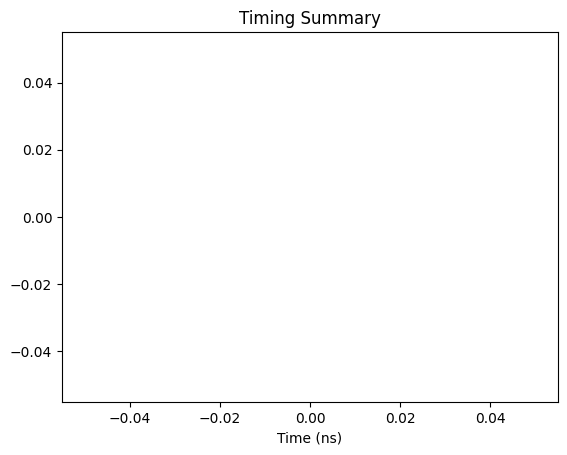

In [38]:
def visualize_summary(timing_summary):
    labels = list(timing_summary.keys())
    values = list(timing_summary.values())
    
    fig, ax = plt.subplots()
    ax.barh(labels, values)
    ax.set_xlabel('Time (ns)')
    ax.set_title('Timing Summary')
    plt.show()

visualize_summary(timing_summary)

# Power_Analysis

In [ ]:
def parse_summary(lines):
    summary = {}
    capture = False
    for line in lines:
        if 'Total On-Chip Power (W)' in line:
            capture = True
        elif '1.1 On-Chip Components' in line:
            capture = False
        elif capture:
            if '|' in line:
                parts = [p.strip() for p in line.split('|') if p.strip()]
                if len(parts) == 2:
                    summary[parts[0]] = parts[1]
    return summary

def parse_on_chip_components(lines):
    components = []
    capture = False
    for line in lines:
        if 'On-Chip Components' in line:
            capture = True
        elif '1.2 Power Supply Summary' in line:
            capture = False
        elif capture:
            if '|' in line:
                parts = [p.strip() for p in line.split('|') if p.strip()]
                if len(parts) == 5:
                    components.append({
                        'Component': parts[0],
                        'Power (W)': parts[1],
                        'Used': parts[2],
                        'Available': parts[3],
                        'Utilization (%)': parts[4]
                    })
    return components

def parse_power_supply_summary(lines):
    power_supply = []
    capture = False
    for line in lines:
        if 'Power Supply Summary' in line:
            capture = True
        elif '1.3 Confidence Level' in line:
            capture = False
        elif capture:
            if '|' in line:
                parts = [p.strip() for p in line.split('|') if p.strip()]
                if len(parts) == 8:
                    power_supply.append({
                        'Source': parts[0],
                        'Voltage (V)': parts[1],
                        'Total (A)': parts[2],
                        'Dynamic (A)': parts[3],
                        'Static (A)': parts[4],
                        'Powerup (A)': parts[5],
                        'Budget (A)': parts[6],
                        'Margin (A)': parts[7]
                    })
    return power_supply

def parse_confidence_level(lines):
    confidence_level = []
    capture = False
    for line in lines:
        if 'Confidence Level' in line:
            capture = True
        elif '2. Settings' in line:
            capture = False
        elif capture:
            if '|' in line:
                parts = [p.strip() for p in line.split('|') if p.strip()]
                if len(parts) == 4:
                    confidence_level.append({
                        'User Input Data': parts[0],
                        'Confidence': parts[1],
                        'Details': parts[2],
                        'Action': parts[3]
                    })
    return confidence_level

def parse_environment(lines):
    environment = {}
    capture = False
    for line in lines:
        if '2.1 Environment' in line:
            capture = True
        elif '2.2 Clock Constraints' in line:
            capture = False
        elif capture:
            if '|' in line:
                parts = [p.strip() for p in line.split('|') if p.strip()]
                if len(parts) == 2:
                    environment[parts[0]] = parts[1]
    return environment

def parse_clock_constraints(lines):
    clock_constraints = []
    capture = False
    for line in lines:
        if '2.2 Clock Constraints' in line:
            capture = True
        elif '3. Detailed Reports' in line:
            capture = False
        elif capture:
            if '|' in line:
                parts = [p.strip() for p in line.split('|') if p.strip()]
                if len(parts) == 3:
                    clock_constraints.append({
                        'Clock': parts[0],
                        'Domain': parts[1],
                        'Constraint (ns)': parts[2]
                    })
    return clock_constraints

def parse_by_hierarchy(lines):
    hierarchy = []
    capture = False
    for line in lines:
        if '3.1 By Hierarchy' in line:
            capture = True
        elif capture:
            if '|' in line:
                parts = [p.strip() for p in line.split('|') if p.strip()]
                if len(parts) == 2:
                    hierarchy.append({
                        'Name': parts[0],
                        'Power (W)': parts[1]
                    })
    return hierarchy

def parse_power_report(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    
    summary = parse_summary(lines)
    on_chip_components = parse_on_chip_components(lines)
    power_supply_summary = parse_power_supply_summary(lines)
    confidence_level = parse_confidence_level(lines)
    environment = parse_environment(lines)
    clock_constraints = parse_clock_constraints(lines)
    by_hierarchy = parse_by_hierarchy(lines)
    
    return {
        'Summary': summary,
        'On-Chip Components': on_chip_components,
        'Power Supply Summary': power_supply_summary,
        'Confidence Level': confidence_level,
        'Environment': environment,
        'Clock Constraints': clock_constraints,
        'By Hierarchy': by_hierarchy
    }

In [ ]:
power_summary_path = 'vivado/power_summary.rpt'
power_data = parse_power_report(power_summary_path)
pprint.pp(power_data)

In [40]:
def save_to_json(data, filename='power_data.json'):
    with open(filename, 'w') as json_file:
        json.dump(data, json_file, indent=4)

save_to_json(power_data)

summary = power_data['Summary']
on_chip_components = power_data['On-Chip Components']
power_supply_summary = power_data['Power Supply Summary']
confidence_level = power_data['Confidence Level']
environment = power_data['Environment']
clock_constraints = power_data['Clock Constraints']
by_hierarchy = power_data['By Hierarchy']

print("Summary:")
pprint.pp(summary)

print("\nOn-Chip Components:")
pprint.pp(on_chip_components)

print("\nPower Supply Summary:")
pprint.pp(power_supply_summary)

print("\nConfidence Level:")
pprint.pp(confidence_level)

print("\nEnvironment:")
pprint.pp(environment)

print("\nClock Constraints:")
pprint.pp(clock_constraints)

print("\nBy Hierarchy:")
pprint.pp(by_hierarchy)

Summary:
{'Design Power Budget (W)': 'Unspecified*',
 'Power Budget Margin (W)': 'NA',
 'Dynamic (W)': '0.927',
 'Device Static (W)': '0.072',
 'Effective TJA (C/W)': '4.8',
 'Max Ambient (C)': '80.2',
 'Junction Temperature (C)': '29.8',
 'Confidence Level': 'Low',
 'Setting File': '---',
 'Simulation Activity File': '---',
 'Design Nets Matched': 'NA'}

On-Chip Components:
[{'Component': 'On-Chip',
  'Power (W)': 'Power (W)',
  'Used': 'Used',
  'Available': 'Available',
  'Utilization (%)': 'Utilization (%)'},
 {'Component': 'Slice Logic',
  'Power (W)': '0.006',
  'Used': '2',
  'Available': '---',
  'Utilization (%)': '---'},
 {'Component': 'LUT as Logic',
  'Power (W)': '0.006',
  'Used': '1',
  'Available': '20800',
  'Utilization (%)': '<0.01'},
 {'Component': 'Signals',
  'Power (W)': '0.036',
  'Used': '5',
  'Available': '---',
  'Utilization (%)': '---'},
 {'Component': 'I/O',
  'Power (W)': '0.886',
  'Used': '5',
  'Available': '210',
  'Utilization (%)': '2.38'}]

Power 

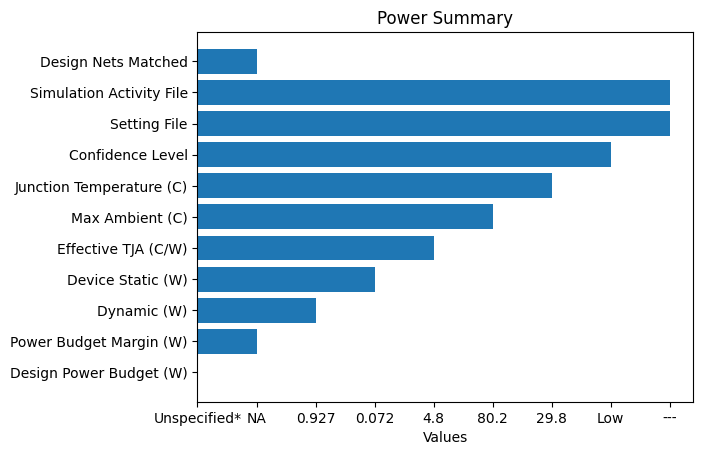

In [41]:
def visualize_power_summary(summary):
    labels = list(summary.keys())
    values = list(summary.values())
    
    fig, ax = plt.subplots()
    ax.barh(labels, values)
    ax.set_xlabel('Values')
    ax.set_title('Power Summary')
    plt.show()

visualize_power_summary(summary)

# Waveform_Analysis

In [47]:
testbench_code = """
`timescale 1ns / 1ps

module full_adder_tb;

  reg a, b, cin;
  wire sum, cout;

  // Instantiate the Full Adder
  full_adder uut (
    .a(a),
    .b(b),
    .cin(cin),
    .sum(sum),
    .cout(cout)
  );

  initial begin
    // Initialize inputs
    a = 0;
    b = 0;
    cin = 0;

    // Apply test vectors
    #10 a = 0; b = 0; cin = 1;
    #10 a = 0; b = 1; cin = 0;
    #10 a = 0; b = 1; cin = 1;
    #10 a = 1; b = 0; cin = 0;
    #10 a = 1; b = 0; cin = 1;
    #10 a = 1; b = 1; cin = 0;
    #10 a = 1; b = 1; cin = 1;
    #10 $stop;
  end

  initial begin
    $dumpfile("full_adder_tb.vcd");
    $dumpvars(0, full_adder_tb);
  end

endmodule
"""

with open("full_adder_tb.v", "w") as f:
    f.write(testbench_code)

In [55]:
#os.chdir("src")
commands = """
vlib work
vlog half_adder.v
vlog full_adder.v
vlog full_adder_tb.v
vsim -c -do "run -all; quit" full_adder_tb
"""

# Write the commands to a script file
with open("run_modelsim.tcl", "w") as f:
    f.write(commands)

# Run the ModelSim script
subprocess.run(["vsim", "-do", "run_modelsim.tcl"])

CompletedProcess(args=['vsim', '-do', 'run_modelsim.tcl'], returncode=0)

In [69]:
#!pip install pyvcd 
from vcd.reader import TokenKind, tokenize

In [ ]:
def parse_vcd(file_path):
    signals = {}
    times = set()

    with open(file_path, 'rb') as f:
        for token in tokenize(f):
            #print(token)
            if token.kind == TokenKind.DATE:
                continue
            elif token.kind == TokenKind.VERSION:
                continue
            elif token.kind == TokenKind.TIMESCALE:
                continue
            elif token.kind == TokenKind.SCOPE:
                continue
            elif token.kind == TokenKind.VAR:
                signals[token.data.reference] = {'name': token.data.reference, 'values': []}
            elif token.kind == TokenKind.CHANGE_SCALAR:
                if token.data.id_code in signals:
                    signals[token.data.id_code]['values'].append((token.time, token.data.value))
                    times.add(token.time)
            elif token.kind == TokenKind.CHANGE_VECTOR:
                if token.data.id_code in signals:
                    signals[token.data.id_code]['values'].append((token.time, token.data.value))
                    times.add(token.time)

    return signals, sorted(times)

In [ ]:
vcd_file = 'full_adder_tb.vcd'
signals, times = parse_vcd(vcd_file)
print(signals, times)

{'a': {'name': 'a', 'values': []}, 'b': {'name': 'b', 'values': []}, 'cin': {'name': 'cin', 'values': []}, 'sum': {'name': 'sum', 'values': []}, 'cout': {'name': 'cout', 'values': []}, 'c1': {'name': 'c1', 'values': []}, 's1': {'name': 's1', 'values': []}, 'c2': {'name': 'c2', 'values': []}, 's': {'name': 's', 'values': []}, 'c': {'name': 'c', 'values': []}} []


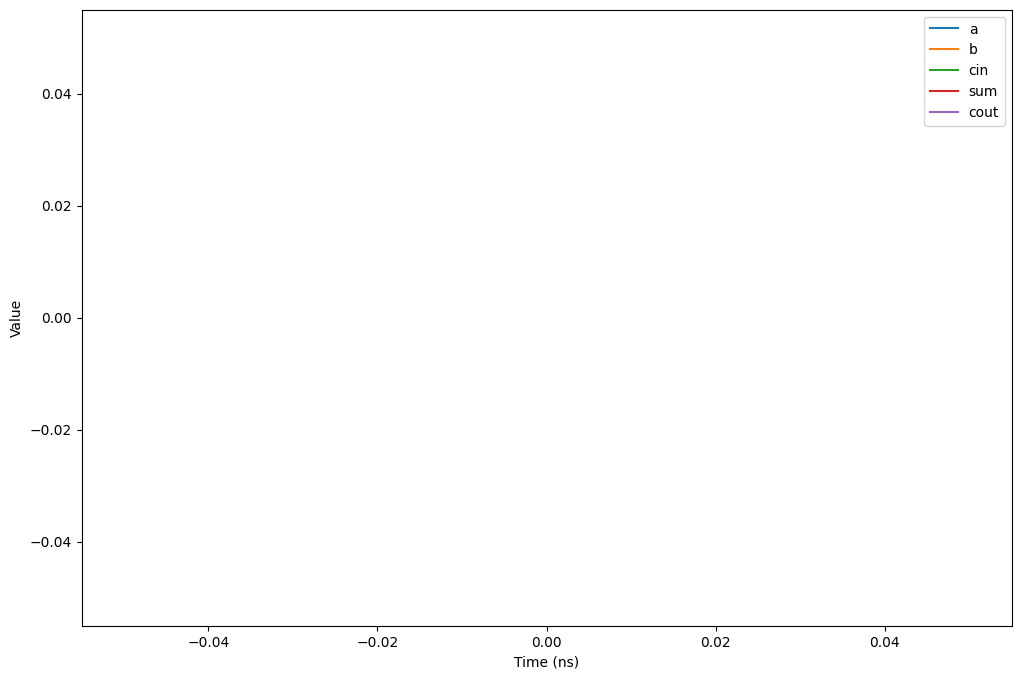

In [ ]:
def plot_signal(signal_name):
    if signal_name in signals:
        data = signals[signal_name]['values']
        times = [x[0] for x in data]
        values = [x[1] for x in data]
        plt.step(times, values, label=signal_name, where='post')

plt.figure(figsize=(12, 8))

for signal_name in ['a', 'b', 'cin', 'sum', 'cout']:
    plot_signal(signal_name)

plt.xlabel('Time (ns)')
plt.ylabel('Value')
plt.legend()
plt.show()

In [60]:
wal_script_test = """
// Load the waveform file
load_waveform "full_adder_tb.vcd"
"""

with open("test_waveforms.wal", "w") as f:
    f.write(wal_script_test)

# Run the simple WAL script
subprocess.run(["wal", "test_waveforms.wal"])

CompletedProcess(args=['wal', 'test_waveforms.wal'], returncode=1)

In [59]:
wal_script = """
load_waveform "full_adder_tb.vcd"

signal a
signal b
signal cin
signal sum
signal cout

extract_signals {
    a -> "a.csv"
    b -> "b.csv"
    cin -> "cin.csv"
    sum -> "sum.csv"
    cout -> "cout.csv"
}
"""

with open("analyze_waveforms.wal", "w") as f:
    f.write(wal_script)

subprocess.run(["wal", "analyze_waveforms.wal"])

CompletedProcess(args=['wal', 'analyze_waveforms.wal'], returncode=1)

# Full_Benchmark

In [275]:
# Step 1: Create Directory Structure
src_folder = "src"
dest_folder = "generated"
verilog_file = os.path.join(src_folder, "alu.v")

if "simulation" in os.getcwd():
    os.chdir("..")

print(os.getcwd())

hierarchy = {}
hierarchy = create_directory_structure(verilog_file, src_folder, dest_folder, hierarchy)
#print(hierarchy)
hierarchy = print_directory_structure(dest_folder)

with open('hierarchy.json', 'w') as f:
    json.dump(hierarchy, f, indent=4)

C:\Users\ugheewala\OneDrive - NVIDIA Corporation\Documents\Projects\benchmarking
generated/
    alu/
        alu.v
        array_multiplier/
            array_multiplier.v
            full_adder/
                full_adder.v
                half_adder/
                    half_adder.v
            half_adder/
                half_adder.v
        booth_multiplier/
            booth_multiplier.v
        borrow_lookahead_subtractor/
            borrow_lookahead_subtractor.v
            full_subtractor/
                full_subtractor.v
                half_subtractor/
                    half_subtractor.v
        carry_lookahead_adder/
            carry_lookahead_adder.v
        carry_lookahead_subtractor/
            carry_lookahead_subtractor.v
            full_subtractor/
                full_subtractor.v
                half_subtractor/
                    half_subtractor.v
        carry_save_adder/
            carry_save_adder.v
        carry_select_adder/
            carry_select_add

In [276]:
# Step 2: Detect component details
print(os.getcwd())

component_name = "alu"
component_details = detect_component_details(component_name, "hierarchy.json", True)
print(json.dumps(component_details, indent=4))

C:\Users\ugheewala\OneDrive - NVIDIA Corporation\Documents\Projects\benchmarking
{
    "component_name": "alu",
    "parameters": [
        {
            "name": "WIDTH",
            "value": "32"
        },
        {
            "name": "BLOCK_SIZE",
            "value": "4"
        },
        {
            "name": "WIDTH",
            "value": "32"
        }
    ],
    "inputs": [
        [
            "input",
            "wire",
            "unsigned",
            "1",
            "WIDTH"
        ],
        [
            "input",
            "wire",
            "unsigned",
            "1",
            "WIDTH"
        ],
        [
            "input",
            "wire",
            "unsigned",
            "3:0",
            "opcode"
        ],
        [
            "input",
            "wire",
            "unsigned",
            "1:0",
            "adder_sel"
        ],
        [
            "input",
            "wire",
            "unsigned",
            "1:0",
            "sub_se

In [ ]:
# Step 3: Define rules for generating expected values for testbench
def adder_rule(test_case):
    if "cin" in test_case:
        outs = {
            "sum": test_case["a"] ^ test_case["b"] ^ test_case["cin"],
            "cout": (test_case["a"] & test_case["b"]) | (test_case["cin"] & (test_case["a"] ^ test_case["b"]))
        }
    else:
        outs = {
            "sum": test_case["a"] ^ test_case["b"],
            "cout": test_case["a"] & test_case["b"]
        }
    print(test_case, outs)
    return outs

def subtractor_rule(test_case):
    if "cin" in test_case:
        outs = {
            "sum": test_case["a"] ^ test_case["b"] ^ test_case["cin"],
            "cout": (test_case["a"] & test_case["b"]) | (test_case["cin"] & (test_case["a"] ^ test_case["b"]))
        }
    else:
        outs = {
            "sum": test_case["a"] ^ test_case["b"],
            "cout": test_case["a"] & test_case["b"]
        }
    print(test_case, outs)
    return outs

def multiplier_rule(test_case):
    if "cin" in test_case:
        outs = {
            "sum": test_case["a"] ^ test_case["b"] ^ test_case["cin"],
            "cout": (test_case["a"] & test_case["b"]) | (test_case["cin"] & (test_case["a"] ^ test_case["b"]))
        }
    else:
        outs = {
            "sum": test_case["a"] ^ test_case["b"],
            "cout": test_case["a"] & test_case["b"]
        }
    print(test_case, outs)
    return outs

def divider_rule(test_case):
    if "cin" in test_case:
        outs = {
            "sum": test_case["a"] ^ test_case["b"] ^ test_case["cin"],
            "cout": (test_case["a"] & test_case["b"]) | (test_case["cin"] & (test_case["a"] ^ test_case["b"]))
        }
    else:
        outs = {
            "sum": test_case["a"] ^ test_case["b"],
            "cout": test_case["a"] & test_case["b"]
        }
    print(test_case, outs)
    return outs

def shifter_rule(test_case):
    if "cin" in test_case:
        outs = {
            "sum": test_case["a"] ^ test_case["b"] ^ test_case["cin"],
            "cout": (test_case["a"] & test_case["b"]) | (test_case["cin"] & (test_case["a"] ^ test_case["b"]))
        }
    else:
        outs = {
            "sum": test_case["a"] ^ test_case["b"],
            "cout": test_case["a"] & test_case["b"]
        }
    print(test_case, outs)
    return outs

In [101]:
# Step 4: Generate testbench
if "simulation" in os.getcwd():
    os.chdir("..")
    
tb_filename, expected_values = generate_testbench(component_name, test_depth, rules, True)

Testbench generated and saved to testbench\tb_full_adder.v
Expected values for each test case: [{'sum': 0, 'cout': 1}, {'sum': 0, 'cout': 1}, {'sum': 1, 'cout': 1}, {'sum': 1, 'cout': 0}, {'sum': 1, 'cout': 0}, {'sum': 1, 'cout': 0}, {'sum': 0, 'cout': 0}, {'sum': 0, 'cout': 1}]


In [102]:
# Step 5: Run and score the testbench using ModelSim
component_name = "alu"
run_testbench(component_name, simulator="modelsim", subs=True)

Compilation failed: Start time: 12:40:20 on Jun 30,2024
vlog tb_full_adder.v 
Model Technology ModelSim - Intel FPGA Edition vlog 10.5b Compiler 2016.10 Oct  5 2016
-- Compiling module tb_full_adder
** Error: tb_full_adder.v(41): (vlog-2110) Illegal reference to net "a".
** Error: tb_full_adder.v(43): (vlog-2110) Illegal reference to net "b".
** Error: tb_full_adder.v(45): (vlog-2110) Illegal reference to net "cin".
** Error: tb_full_adder.v(53): (vlog-2110) Illegal reference to net "a".
** Error: tb_full_adder.v(53): (vlog-2110) Illegal reference to net "b".
** Error: tb_full_adder.v(53): (vlog-2110) Illegal reference to net "cin".
** Error: tb_full_adder.v(62): (vlog-2110) Illegal reference to net "a".
** Error: tb_full_adder.v(62): (vlog-2110) Illegal reference to net "b".
** Error: tb_full_adder.v(62): (vlog-2110) Illegal reference to net "cin".
** Error: tb_full_adder.v(71): (vlog-2110) Illegal reference to net "a".
** Error: tb_full_adder.v(71): (vlog-2110) Illegal reference to n

In [103]:
# Step 6: Run Yosys for netlist generation and analysis
component_name = "alu"
get_netlist(component_name, subs=True, analysis=True)


 /----------------------------------------------------------------------------\
 |  yosys -- Yosys Open SYnthesis Suite                                       |
 |  Copyright (C) 2012 - 2024  Claire Xenia Wolf <claire@yosyshq.com>         |
 |  Distributed under an ISC-like license, type "license" to see terms        |
 \----------------------------------------------------------------------------/
 Yosys 0.42+40 (git sha1 a739e21a5, x86_64-w64-mingw32-g++ 13.2.1 -Os)

-- Executing script file `script.ys' --

ERROR: Can't open input file `src\full_adder.v' for reading: No such file or directory



RuntimeError: Yosys execution failed

In [ ]:
# Step 7: Generate vivado scripts 

In [ ]:
# Step 8: Follow instructions in generated/component_name/run_vivado.txt to manually (sadly) run vivado scripts
# Example
component_name = "alu"
comp_dir = find_component_directory(component_name)
pprint(open(os.path.join(comp_dir, "run_vivado.txt").read())

In [104]:
# Step 9: Parse and visualize timing analysis
component_name = "alu"
get_timing(component_name, subs=True, viz=True)

FileNotFoundError: [Errno 2] No such file or directory: 'vivado/timing_summary.rpt'

In [ ]:
# Step 10: Parse and visualize power analysis
component_name = "alu"
get_power(component_name, subs=True, viz=True)

In [ ]:
# Step 11: Parse and visualize waveform analysis
component_name = "alu"
get_waveform(component_name, subs=True, viz=True)

# Centralized

In [ ]:
def generate_full_report()

In [ ]:
def benchmark()